In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 77xb9byl


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-77xb9byl:best, 58.49MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.4


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                      | 0/2604 [00:00<?, ?it/s]

  0%|                                                                                              | 1/2604 [00:00<32:26,  1.34it/s]

  0%|                                                                                              | 2/2604 [00:00<19:00,  2.28it/s]

  0%|                                                                                              | 3/2604 [00:01<14:41,  2.95it/s]

  0%|▏                                                                                             | 4/2604 [00:01<12:40,  3.42it/s]

  0%|▏                                                                                             | 5/2604 [00:01<11:33,  3.75it/s]

  0%|▏                                                                                             | 6/2604 [00:01<10:52,  3.98it/s]

  0%|▎                                                                                             | 7/2604 [00:02<10:26,  4.15it/s]

  0%|▎                                                                                             | 8/2604 [00:02<10:09,  4.26it/s]

  0%|▎                                                                                             | 9/2604 [00:02<09:57,  4.34it/s]

  0%|▎                                                                                            | 10/2604 [00:02<09:50,  4.40it/s]

  0%|▍                                                                                            | 11/2604 [00:02<09:44,  4.44it/s]

  0%|▍                                                                                            | 12/2604 [00:03<09:40,  4.46it/s]

  0%|▍                                                                                            | 13/2604 [00:03<09:38,  4.48it/s]

  1%|▌                                                                                            | 14/2604 [00:03<09:35,  4.50it/s]

  1%|▌                                                                                            | 15/2604 [00:03<09:34,  4.51it/s]

  1%|▌                                                                                            | 16/2604 [00:04<09:33,  4.51it/s]

  1%|▌                                                                                            | 17/2604 [00:04<09:32,  4.52it/s]

  1%|▋                                                                                            | 18/2604 [00:04<09:32,  4.52it/s]

  1%|▋                                                                                            | 19/2604 [00:04<09:31,  4.52it/s]

  1%|▋                                                                                            | 20/2604 [00:04<09:31,  4.52it/s]

  1%|▊                                                                                            | 21/2604 [00:05<09:30,  4.52it/s]

  1%|▊                                                                                            | 22/2604 [00:05<09:30,  4.52it/s]

  1%|▊                                                                                            | 23/2604 [00:05<09:30,  4.53it/s]

  1%|▊                                                                                            | 24/2604 [00:05<09:29,  4.53it/s]

  1%|▉                                                                                            | 25/2604 [00:06<09:29,  4.52it/s]

  1%|▉                                                                                            | 26/2604 [00:06<09:29,  4.53it/s]

  1%|▉                                                                                            | 27/2604 [00:06<09:29,  4.53it/s]

  1%|█                                                                                            | 28/2604 [00:06<09:29,  4.53it/s]

  1%|█                                                                                            | 29/2604 [00:06<09:28,  4.53it/s]

  1%|█                                                                                            | 30/2604 [00:07<09:28,  4.53it/s]

  1%|█                                                                                            | 31/2604 [00:07<09:28,  4.53it/s]

  1%|█▏                                                                                           | 32/2604 [00:07<09:28,  4.53it/s]

  1%|█▏                                                                                           | 33/2604 [00:07<09:27,  4.53it/s]

  1%|█▏                                                                                           | 34/2604 [00:08<09:27,  4.53it/s]

  1%|█▎                                                                                           | 35/2604 [00:08<09:27,  4.53it/s]

  1%|█▎                                                                                           | 36/2604 [00:08<09:27,  4.53it/s]

  1%|█▎                                                                                           | 37/2604 [00:08<09:26,  4.53it/s]

  1%|█▎                                                                                           | 38/2604 [00:08<09:26,  4.53it/s]

  1%|█▍                                                                                           | 39/2604 [00:09<09:26,  4.53it/s]

  2%|█▍                                                                                           | 40/2604 [00:09<09:25,  4.53it/s]

  2%|█▍                                                                                           | 41/2604 [00:09<09:25,  4.53it/s]

  2%|█▌                                                                                           | 42/2604 [00:09<09:25,  4.53it/s]

  2%|█▌                                                                                           | 43/2604 [00:10<09:25,  4.53it/s]

  2%|█▌                                                                                           | 44/2604 [00:10<09:25,  4.53it/s]

  2%|█▌                                                                                           | 45/2604 [00:10<09:24,  4.53it/s]

  2%|█▋                                                                                           | 46/2604 [00:10<09:24,  4.53it/s]

  2%|█▋                                                                                           | 47/2604 [00:10<09:24,  4.53it/s]

  2%|█▋                                                                                           | 48/2604 [00:11<09:24,  4.53it/s]

  2%|█▊                                                                                           | 49/2604 [00:11<09:24,  4.53it/s]

  2%|█▊                                                                                           | 50/2604 [00:11<09:23,  4.53it/s]

  2%|█▊                                                                                           | 51/2604 [00:11<09:23,  4.53it/s]

  2%|█▊                                                                                           | 52/2604 [00:12<09:23,  4.53it/s]

  2%|█▉                                                                                           | 53/2604 [00:12<09:23,  4.53it/s]

  2%|█▉                                                                                           | 54/2604 [00:12<09:22,  4.53it/s]

  2%|█▉                                                                                           | 55/2604 [00:12<09:22,  4.53it/s]

  2%|██                                                                                           | 56/2604 [00:12<09:22,  4.53it/s]

  2%|██                                                                                           | 57/2604 [00:13<09:22,  4.53it/s]

  2%|██                                                                                           | 58/2604 [00:13<09:22,  4.53it/s]

  2%|██                                                                                           | 59/2604 [00:13<09:21,  4.53it/s]

  2%|██▏                                                                                          | 60/2604 [00:13<09:21,  4.53it/s]

  2%|██▏                                                                                          | 61/2604 [00:13<09:21,  4.53it/s]

  2%|██▏                                                                                          | 62/2604 [00:14<09:20,  4.53it/s]

  2%|██▎                                                                                          | 63/2604 [00:14<09:20,  4.53it/s]

  2%|██▎                                                                                          | 64/2604 [00:14<09:20,  4.53it/s]

  2%|██▎                                                                                          | 65/2604 [00:14<09:20,  4.53it/s]

  3%|██▎                                                                                          | 66/2604 [00:15<09:20,  4.53it/s]

  3%|██▍                                                                                          | 67/2604 [00:15<09:19,  4.53it/s]

  3%|██▍                                                                                          | 68/2604 [00:15<09:19,  4.53it/s]

  3%|██▍                                                                                          | 69/2604 [00:15<09:19,  4.53it/s]

  3%|██▌                                                                                          | 70/2604 [00:15<09:19,  4.53it/s]

  3%|██▌                                                                                          | 71/2604 [00:16<09:18,  4.53it/s]

  3%|██▌                                                                                          | 72/2604 [00:16<09:18,  4.53it/s]

  3%|██▌                                                                                          | 73/2604 [00:16<09:18,  4.53it/s]

  3%|██▋                                                                                          | 74/2604 [00:16<09:18,  4.53it/s]

  3%|██▋                                                                                          | 75/2604 [00:17<09:18,  4.53it/s]

  3%|██▋                                                                                          | 76/2604 [00:17<09:17,  4.53it/s]

  3%|██▊                                                                                          | 77/2604 [00:17<09:17,  4.53it/s]

  3%|██▊                                                                                          | 78/2604 [00:17<09:17,  4.53it/s]

  3%|██▊                                                                                          | 79/2604 [00:17<09:17,  4.53it/s]

  3%|██▊                                                                                          | 80/2604 [00:18<09:17,  4.53it/s]

  3%|██▉                                                                                          | 81/2604 [00:18<09:16,  4.53it/s]

  3%|██▉                                                                                          | 82/2604 [00:18<09:16,  4.53it/s]

  3%|██▉                                                                                          | 83/2604 [00:18<09:16,  4.53it/s]

  3%|███                                                                                          | 84/2604 [00:19<09:16,  4.53it/s]

  3%|███                                                                                          | 85/2604 [00:19<09:15,  4.53it/s]

  3%|███                                                                                          | 86/2604 [00:19<09:15,  4.53it/s]

  3%|███                                                                                          | 87/2604 [00:19<09:15,  4.53it/s]

  3%|███▏                                                                                         | 88/2604 [00:19<09:15,  4.53it/s]

  3%|███▏                                                                                         | 89/2604 [00:20<09:15,  4.53it/s]

  3%|███▏                                                                                         | 90/2604 [00:20<09:14,  4.53it/s]

  3%|███▏                                                                                         | 91/2604 [00:20<09:14,  4.53it/s]

  4%|███▎                                                                                         | 92/2604 [00:20<09:14,  4.53it/s]

  4%|███▎                                                                                         | 93/2604 [00:21<09:14,  4.53it/s]

  4%|███▎                                                                                         | 94/2604 [00:21<09:14,  4.53it/s]

  4%|███▍                                                                                         | 95/2604 [00:21<09:13,  4.53it/s]

  4%|███▍                                                                                         | 96/2604 [00:21<09:13,  4.53it/s]

  4%|███▍                                                                                         | 97/2604 [00:21<09:13,  4.53it/s]

  4%|███▌                                                                                         | 98/2604 [00:22<09:13,  4.53it/s]

  4%|███▌                                                                                         | 99/2604 [00:22<09:12,  4.53it/s]

  4%|███▌                                                                                        | 100/2604 [00:22<09:12,  4.53it/s]

  4%|███▌                                                                                        | 101/2604 [00:22<09:12,  4.53it/s]

  4%|███▌                                                                                        | 102/2604 [00:23<09:11,  4.53it/s]

  4%|███▋                                                                                        | 103/2604 [00:23<09:11,  4.53it/s]

  4%|███▋                                                                                        | 104/2604 [00:23<09:11,  4.53it/s]

  4%|███▋                                                                                        | 105/2604 [00:23<09:11,  4.53it/s]

  4%|███▋                                                                                        | 106/2604 [00:23<09:11,  4.53it/s]

  4%|███▊                                                                                        | 107/2604 [00:24<09:10,  4.53it/s]

  4%|███▊                                                                                        | 108/2604 [00:24<09:10,  4.53it/s]

  4%|███▊                                                                                        | 109/2604 [00:24<09:10,  4.53it/s]

  4%|███▉                                                                                        | 110/2604 [00:24<09:10,  4.53it/s]

  4%|███▉                                                                                        | 111/2604 [00:25<09:10,  4.53it/s]

  4%|███▉                                                                                        | 112/2604 [00:25<09:09,  4.53it/s]

  4%|███▉                                                                                        | 113/2604 [00:25<09:09,  4.53it/s]

  4%|████                                                                                        | 114/2604 [00:25<09:09,  4.53it/s]

  4%|████                                                                                        | 115/2604 [00:25<09:09,  4.53it/s]

  4%|████                                                                                        | 116/2604 [00:26<09:09,  4.53it/s]

  4%|████▏                                                                                       | 117/2604 [00:26<09:08,  4.53it/s]

  5%|████▏                                                                                       | 118/2604 [00:26<09:08,  4.53it/s]

  5%|████▏                                                                                       | 119/2604 [00:26<09:08,  4.53it/s]

  5%|████▏                                                                                       | 120/2604 [00:27<09:08,  4.53it/s]

  5%|████▎                                                                                       | 121/2604 [00:27<09:07,  4.53it/s]

  5%|████▎                                                                                       | 122/2604 [00:27<09:07,  4.53it/s]

  5%|████▎                                                                                       | 123/2604 [00:27<09:07,  4.53it/s]

  5%|████▍                                                                                       | 124/2604 [00:27<09:07,  4.53it/s]

  5%|████▍                                                                                       | 125/2604 [00:28<09:06,  4.53it/s]

  5%|████▍                                                                                       | 126/2604 [00:28<09:06,  4.53it/s]

  5%|████▍                                                                                       | 127/2604 [00:28<09:06,  4.53it/s]

  5%|████▌                                                                                       | 128/2604 [00:28<09:06,  4.53it/s]

  5%|████▌                                                                                       | 129/2604 [00:29<09:05,  4.53it/s]

  5%|████▌                                                                                       | 130/2604 [00:29<09:05,  4.53it/s]

  5%|████▋                                                                                       | 131/2604 [00:29<09:05,  4.53it/s]

  5%|████▋                                                                                       | 132/2604 [00:29<09:05,  4.53it/s]

  5%|████▋                                                                                       | 133/2604 [00:29<09:05,  4.53it/s]

  5%|████▋                                                                                       | 134/2604 [00:30<09:04,  4.53it/s]

  5%|████▊                                                                                       | 135/2604 [00:30<09:04,  4.53it/s]

  5%|████▊                                                                                       | 136/2604 [00:30<09:04,  4.53it/s]

  5%|████▊                                                                                       | 137/2604 [00:30<09:04,  4.53it/s]

  5%|████▉                                                                                       | 138/2604 [00:30<09:04,  4.53it/s]

  5%|████▉                                                                                       | 139/2604 [00:31<09:03,  4.53it/s]

  5%|████▉                                                                                       | 140/2604 [00:31<09:03,  4.53it/s]

  5%|████▉                                                                                       | 141/2604 [00:31<09:03,  4.53it/s]

  5%|█████                                                                                       | 142/2604 [00:31<09:03,  4.53it/s]

  5%|█████                                                                                       | 143/2604 [00:32<09:02,  4.53it/s]

  6%|█████                                                                                       | 144/2604 [00:32<09:02,  4.53it/s]

  6%|█████                                                                                       | 145/2604 [00:32<09:02,  4.53it/s]

  6%|█████▏                                                                                      | 146/2604 [00:32<09:02,  4.53it/s]

  6%|█████▏                                                                                      | 147/2604 [00:32<09:02,  4.53it/s]

  6%|█████▏                                                                                      | 148/2604 [00:33<09:02,  4.53it/s]

  6%|█████▎                                                                                      | 149/2604 [00:33<09:01,  4.53it/s]

  6%|█████▎                                                                                      | 150/2604 [00:33<09:01,  4.53it/s]

  6%|█████▎                                                                                      | 151/2604 [00:33<09:01,  4.53it/s]

  6%|█████▎                                                                                      | 152/2604 [00:34<09:01,  4.53it/s]

  6%|█████▍                                                                                      | 153/2604 [00:34<09:00,  4.53it/s]

  6%|█████▍                                                                                      | 154/2604 [00:34<09:00,  4.53it/s]

  6%|█████▍                                                                                      | 155/2604 [00:34<09:00,  4.53it/s]

  6%|█████▌                                                                                      | 156/2604 [00:34<09:00,  4.53it/s]

  6%|█████▌                                                                                      | 157/2604 [00:35<09:00,  4.53it/s]

  6%|█████▌                                                                                      | 158/2604 [00:35<09:00,  4.53it/s]

  6%|█████▌                                                                                      | 159/2604 [00:35<08:59,  4.53it/s]

  6%|█████▋                                                                                      | 160/2604 [00:35<08:59,  4.53it/s]

  6%|█████▋                                                                                      | 161/2604 [00:36<08:59,  4.53it/s]

  6%|█████▋                                                                                      | 162/2604 [00:36<08:59,  4.53it/s]

  6%|█████▊                                                                                      | 163/2604 [00:36<08:58,  4.53it/s]

  6%|█████▊                                                                                      | 164/2604 [00:36<08:58,  4.53it/s]

  6%|█████▊                                                                                      | 165/2604 [00:36<08:58,  4.53it/s]

  6%|█████▊                                                                                      | 166/2604 [00:37<08:58,  4.53it/s]

  6%|█████▉                                                                                      | 167/2604 [00:37<08:57,  4.53it/s]

  6%|█████▉                                                                                      | 168/2604 [00:37<08:57,  4.53it/s]

  6%|█████▉                                                                                      | 169/2604 [00:37<08:57,  4.53it/s]

  7%|██████                                                                                      | 170/2604 [00:38<08:57,  4.53it/s]

  7%|██████                                                                                      | 171/2604 [00:38<08:57,  4.53it/s]

  7%|██████                                                                                      | 172/2604 [00:38<08:56,  4.53it/s]

  7%|██████                                                                                      | 173/2604 [00:38<08:56,  4.53it/s]

  7%|██████▏                                                                                     | 174/2604 [00:38<08:56,  4.53it/s]

  7%|██████▏                                                                                     | 175/2604 [00:39<08:56,  4.53it/s]

  7%|██████▏                                                                                     | 176/2604 [00:39<08:56,  4.53it/s]

  7%|██████▎                                                                                     | 177/2604 [00:39<08:55,  4.53it/s]

  7%|██████▎                                                                                     | 178/2604 [00:39<08:55,  4.53it/s]

  7%|██████▎                                                                                     | 179/2604 [00:40<08:55,  4.53it/s]

  7%|██████▎                                                                                     | 180/2604 [00:40<08:54,  4.53it/s]

  7%|██████▍                                                                                     | 181/2604 [00:40<08:54,  4.53it/s]

  7%|██████▍                                                                                     | 182/2604 [00:40<08:54,  4.53it/s]

  7%|██████▍                                                                                     | 183/2604 [00:40<08:54,  4.53it/s]

  7%|██████▌                                                                                     | 184/2604 [00:41<08:54,  4.53it/s]

  7%|██████▌                                                                                     | 185/2604 [00:41<08:53,  4.53it/s]

  7%|██████▌                                                                                     | 186/2604 [00:41<08:53,  4.53it/s]

  7%|██████▌                                                                                     | 187/2604 [00:41<08:53,  4.53it/s]

  7%|██████▋                                                                                     | 188/2604 [00:42<08:53,  4.53it/s]

  7%|██████▋                                                                                     | 189/2604 [00:42<08:53,  4.53it/s]

  7%|██████▋                                                                                     | 190/2604 [00:42<08:52,  4.53it/s]

  7%|██████▋                                                                                     | 191/2604 [00:42<08:52,  4.53it/s]

  7%|██████▊                                                                                     | 192/2604 [00:42<08:52,  4.53it/s]

  7%|██████▊                                                                                     | 193/2604 [00:43<08:52,  4.53it/s]

  7%|██████▊                                                                                     | 194/2604 [00:43<08:52,  4.53it/s]

  7%|██████▉                                                                                     | 195/2604 [00:43<08:51,  4.53it/s]

  8%|██████▉                                                                                     | 196/2604 [00:43<08:51,  4.53it/s]

  8%|██████▉                                                                                     | 197/2604 [00:44<08:51,  4.53it/s]

  8%|██████▉                                                                                     | 198/2604 [00:44<08:51,  4.53it/s]

  8%|███████                                                                                     | 199/2604 [00:44<08:51,  4.53it/s]

  8%|███████                                                                                     | 200/2604 [00:44<08:51,  4.53it/s]

  8%|███████                                                                                     | 201/2604 [00:44<08:50,  4.53it/s]

  8%|███████▏                                                                                    | 202/2604 [00:45<08:50,  4.53it/s]

  8%|███████▏                                                                                    | 203/2604 [00:45<08:50,  4.53it/s]

  8%|███████▏                                                                                    | 204/2604 [00:45<08:50,  4.53it/s]

  8%|███████▏                                                                                    | 205/2604 [00:45<08:49,  4.53it/s]

  8%|███████▎                                                                                    | 206/2604 [00:46<08:49,  4.53it/s]

  8%|███████▎                                                                                    | 207/2604 [00:46<08:49,  4.53it/s]

  8%|███████▎                                                                                    | 208/2604 [00:46<08:49,  4.53it/s]

  8%|███████▍                                                                                    | 209/2604 [00:46<08:49,  4.53it/s]

  8%|███████▍                                                                                    | 210/2604 [00:46<08:48,  4.53it/s]

  8%|███████▍                                                                                    | 211/2604 [00:47<08:48,  4.53it/s]

  8%|███████▍                                                                                    | 212/2604 [00:47<08:48,  4.53it/s]

  8%|███████▌                                                                                    | 213/2604 [00:47<08:48,  4.53it/s]

  8%|███████▌                                                                                    | 214/2604 [00:47<08:47,  4.53it/s]

  8%|███████▌                                                                                    | 215/2604 [00:47<08:47,  4.53it/s]

  8%|███████▋                                                                                    | 216/2604 [00:48<08:47,  4.53it/s]

  8%|███████▋                                                                                    | 217/2604 [00:48<08:46,  4.53it/s]

  8%|███████▋                                                                                    | 218/2604 [00:48<08:46,  4.53it/s]

  8%|███████▋                                                                                    | 219/2604 [00:48<08:46,  4.53it/s]

  8%|███████▊                                                                                    | 220/2604 [00:49<08:46,  4.53it/s]

  8%|███████▊                                                                                    | 221/2604 [00:49<08:46,  4.52it/s]

  9%|███████▊                                                                                    | 222/2604 [00:49<08:46,  4.53it/s]

  9%|███████▉                                                                                    | 223/2604 [00:49<08:46,  4.53it/s]

  9%|███████▉                                                                                    | 224/2604 [00:49<08:45,  4.53it/s]

  9%|███████▉                                                                                    | 225/2604 [00:50<08:45,  4.53it/s]

  9%|███████▉                                                                                    | 226/2604 [00:50<08:45,  4.53it/s]

  9%|████████                                                                                    | 227/2604 [00:50<08:44,  4.53it/s]

  9%|████████                                                                                    | 228/2604 [00:50<08:44,  4.53it/s]

  9%|████████                                                                                    | 229/2604 [00:51<08:44,  4.53it/s]

  9%|████████▏                                                                                   | 230/2604 [00:51<08:44,  4.53it/s]

  9%|████████▏                                                                                   | 231/2604 [00:51<08:44,  4.53it/s]

  9%|████████▏                                                                                   | 232/2604 [00:51<08:43,  4.53it/s]

  9%|████████▏                                                                                   | 233/2604 [00:51<08:43,  4.53it/s]

  9%|████████▎                                                                                   | 234/2604 [00:52<08:43,  4.53it/s]

  9%|████████▎                                                                                   | 235/2604 [00:52<08:43,  4.53it/s]

  9%|████████▎                                                                                   | 236/2604 [00:52<08:42,  4.53it/s]

  9%|████████▎                                                                                   | 237/2604 [00:52<08:42,  4.53it/s]

  9%|████████▍                                                                                   | 238/2604 [00:53<08:42,  4.53it/s]

  9%|████████▍                                                                                   | 239/2604 [00:53<08:42,  4.53it/s]

  9%|████████▍                                                                                   | 240/2604 [00:53<08:42,  4.53it/s]

  9%|████████▌                                                                                   | 241/2604 [00:53<08:41,  4.53it/s]

  9%|████████▌                                                                                   | 242/2604 [00:53<08:41,  4.53it/s]

  9%|████████▌                                                                                   | 243/2604 [00:54<08:41,  4.53it/s]

  9%|████████▌                                                                                   | 244/2604 [00:54<08:41,  4.53it/s]

  9%|████████▋                                                                                   | 245/2604 [00:54<08:40,  4.53it/s]

  9%|████████▋                                                                                   | 246/2604 [00:54<08:40,  4.53it/s]

  9%|████████▋                                                                                   | 247/2604 [00:55<08:40,  4.53it/s]

 10%|████████▊                                                                                   | 248/2604 [00:55<08:39,  4.53it/s]

 10%|████████▊                                                                                   | 249/2604 [00:55<08:40,  4.53it/s]

 10%|████████▊                                                                                   | 250/2604 [00:55<08:40,  4.53it/s]

 10%|████████▊                                                                                   | 251/2604 [00:55<08:39,  4.53it/s]

 10%|████████▉                                                                                   | 252/2604 [00:56<08:39,  4.53it/s]

 10%|████████▉                                                                                   | 253/2604 [00:56<08:39,  4.53it/s]

 10%|████████▉                                                                                   | 254/2604 [00:56<08:38,  4.53it/s]

 10%|█████████                                                                                   | 255/2604 [00:56<08:38,  4.53it/s]

 10%|█████████                                                                                   | 256/2604 [00:57<08:38,  4.53it/s]

 10%|█████████                                                                                   | 257/2604 [00:57<08:38,  4.53it/s]

 10%|█████████                                                                                   | 258/2604 [00:57<08:38,  4.53it/s]

 10%|█████████▏                                                                                  | 259/2604 [00:57<08:38,  4.53it/s]

 10%|█████████▏                                                                                  | 260/2604 [00:57<08:37,  4.53it/s]

 10%|█████████▏                                                                                  | 261/2604 [00:58<08:37,  4.53it/s]

 10%|█████████▎                                                                                  | 262/2604 [00:58<08:37,  4.53it/s]

 10%|█████████▎                                                                                  | 263/2604 [00:58<08:37,  4.53it/s]

 10%|█████████▎                                                                                  | 264/2604 [00:58<08:36,  4.53it/s]

 10%|█████████▎                                                                                  | 265/2604 [00:59<08:36,  4.53it/s]

 10%|█████████▍                                                                                  | 266/2604 [00:59<08:36,  4.53it/s]

 10%|█████████▍                                                                                  | 267/2604 [00:59<08:36,  4.53it/s]

 10%|█████████▍                                                                                  | 268/2604 [00:59<08:35,  4.53it/s]

 10%|█████████▌                                                                                  | 269/2604 [00:59<08:35,  4.53it/s]

 10%|█████████▌                                                                                  | 270/2604 [01:00<08:35,  4.53it/s]

 10%|█████████▌                                                                                  | 271/2604 [01:00<08:35,  4.53it/s]

 10%|█████████▌                                                                                  | 272/2604 [01:00<08:35,  4.53it/s]

 10%|█████████▋                                                                                  | 273/2604 [01:00<08:34,  4.53it/s]

 11%|█████████▋                                                                                  | 274/2604 [01:01<08:34,  4.53it/s]

 11%|█████████▋                                                                                  | 275/2604 [01:01<08:34,  4.53it/s]

 11%|█████████▊                                                                                  | 276/2604 [01:01<08:34,  4.53it/s]

 11%|█████████▊                                                                                  | 277/2604 [01:01<08:34,  4.53it/s]

 11%|█████████▊                                                                                  | 278/2604 [01:01<08:33,  4.53it/s]

 11%|█████████▊                                                                                  | 279/2604 [01:02<08:33,  4.53it/s]

 11%|█████████▉                                                                                  | 280/2604 [01:02<08:33,  4.53it/s]

 11%|█████████▉                                                                                  | 281/2604 [01:02<08:33,  4.52it/s]

 11%|█████████▉                                                                                  | 282/2604 [01:02<08:33,  4.53it/s]

 11%|█████████▉                                                                                  | 283/2604 [01:03<08:32,  4.53it/s]

 11%|██████████                                                                                  | 284/2604 [01:03<08:32,  4.53it/s]

 11%|██████████                                                                                  | 285/2604 [01:03<08:32,  4.53it/s]

 11%|██████████                                                                                  | 286/2604 [01:03<08:32,  4.53it/s]

 11%|██████████▏                                                                                 | 287/2604 [01:03<08:31,  4.53it/s]

 11%|██████████▏                                                                                 | 288/2604 [01:04<08:31,  4.53it/s]

 11%|██████████▏                                                                                 | 289/2604 [01:04<08:31,  4.53it/s]

 11%|██████████▏                                                                                 | 290/2604 [01:04<08:30,  4.53it/s]

 11%|██████████▎                                                                                 | 291/2604 [01:04<08:30,  4.53it/s]

 11%|██████████▎                                                                                 | 292/2604 [01:04<08:30,  4.53it/s]

 11%|██████████▎                                                                                 | 293/2604 [01:05<08:30,  4.53it/s]

 11%|██████████▍                                                                                 | 294/2604 [01:05<08:30,  4.53it/s]

 11%|██████████▍                                                                                 | 295/2604 [01:05<08:29,  4.53it/s]

 11%|██████████▍                                                                                 | 296/2604 [01:05<08:29,  4.53it/s]

 11%|██████████▍                                                                                 | 297/2604 [01:06<08:29,  4.53it/s]

 11%|██████████▌                                                                                 | 298/2604 [01:06<08:29,  4.53it/s]

 11%|██████████▌                                                                                 | 299/2604 [01:06<08:28,  4.53it/s]

 12%|██████████▌                                                                                 | 300/2604 [01:06<08:28,  4.53it/s]

 12%|██████████▋                                                                                 | 301/2604 [01:06<08:28,  4.53it/s]

 12%|██████████▋                                                                                 | 302/2604 [01:07<08:28,  4.53it/s]

 12%|██████████▋                                                                                 | 303/2604 [01:07<08:27,  4.53it/s]

 12%|██████████▋                                                                                 | 304/2604 [01:07<08:27,  4.53it/s]

 12%|██████████▊                                                                                 | 305/2604 [01:07<08:27,  4.53it/s]

 12%|██████████▊                                                                                 | 306/2604 [01:08<08:27,  4.53it/s]

 12%|██████████▊                                                                                 | 307/2604 [01:08<08:27,  4.53it/s]

 12%|██████████▉                                                                                 | 308/2604 [01:08<08:27,  4.53it/s]

 12%|██████████▉                                                                                 | 309/2604 [01:08<08:26,  4.53it/s]

 12%|██████████▉                                                                                 | 310/2604 [01:08<08:26,  4.53it/s]

 12%|██████████▉                                                                                 | 311/2604 [01:09<08:26,  4.53it/s]

 12%|███████████                                                                                 | 312/2604 [01:09<08:26,  4.53it/s]

 12%|███████████                                                                                 | 313/2604 [01:09<08:25,  4.53it/s]

 12%|███████████                                                                                 | 314/2604 [01:09<08:25,  4.53it/s]

 12%|███████████▏                                                                                | 315/2604 [01:10<08:25,  4.53it/s]

 12%|███████████▏                                                                                | 316/2604 [01:10<08:25,  4.53it/s]

 12%|███████████▏                                                                                | 317/2604 [01:10<08:25,  4.53it/s]

 12%|███████████▏                                                                                | 318/2604 [01:10<08:25,  4.53it/s]

 12%|███████████▎                                                                                | 319/2604 [01:10<08:24,  4.53it/s]

 12%|███████████▎                                                                                | 320/2604 [01:11<08:24,  4.53it/s]

 12%|███████████▎                                                                                | 321/2604 [01:11<08:24,  4.53it/s]

 12%|███████████▍                                                                                | 322/2604 [01:11<08:24,  4.53it/s]

 12%|███████████▍                                                                                | 323/2604 [01:11<08:23,  4.53it/s]

 12%|███████████▍                                                                                | 324/2604 [01:12<08:23,  4.53it/s]

 12%|███████████▍                                                                                | 325/2604 [01:12<08:23,  4.53it/s]

 13%|███████████▌                                                                                | 326/2604 [01:12<08:23,  4.53it/s]

 13%|███████████▌                                                                                | 327/2604 [01:12<08:22,  4.53it/s]

 13%|███████████▌                                                                                | 328/2604 [01:12<08:22,  4.53it/s]

 13%|███████████▌                                                                                | 329/2604 [01:13<08:22,  4.53it/s]

 13%|███████████▋                                                                                | 330/2604 [01:13<08:22,  4.53it/s]

 13%|███████████▋                                                                                | 331/2604 [01:13<08:21,  4.53it/s]

 13%|███████████▋                                                                                | 332/2604 [01:13<08:21,  4.53it/s]

 13%|███████████▊                                                                                | 333/2604 [01:14<08:21,  4.53it/s]

 13%|███████████▊                                                                                | 334/2604 [01:14<08:21,  4.53it/s]

 13%|███████████▊                                                                                | 335/2604 [01:14<08:21,  4.53it/s]

 13%|███████████▊                                                                                | 336/2604 [01:14<08:20,  4.53it/s]

 13%|███████████▉                                                                                | 337/2604 [01:14<08:20,  4.53it/s]

 13%|███████████▉                                                                                | 338/2604 [01:15<08:20,  4.53it/s]

 13%|███████████▉                                                                                | 339/2604 [01:15<08:20,  4.53it/s]

 13%|████████████                                                                                | 340/2604 [01:15<08:19,  4.53it/s]

 13%|████████████                                                                                | 341/2604 [01:15<08:19,  4.53it/s]

 13%|████████████                                                                                | 342/2604 [01:16<08:19,  4.53it/s]

 13%|████████████                                                                                | 343/2604 [01:16<08:19,  4.53it/s]

 13%|████████████▏                                                                               | 344/2604 [01:16<08:19,  4.53it/s]

 13%|████████████▏                                                                               | 345/2604 [01:16<08:18,  4.53it/s]

 13%|████████████▏                                                                               | 346/2604 [01:16<08:18,  4.53it/s]

 13%|████████████▎                                                                               | 347/2604 [01:17<08:18,  4.53it/s]

 13%|████████████▎                                                                               | 348/2604 [01:17<08:18,  4.53it/s]

 13%|████████████▎                                                                               | 349/2604 [01:17<08:18,  4.53it/s]

 13%|████████████▎                                                                               | 350/2604 [01:17<08:17,  4.53it/s]

 13%|████████████▍                                                                               | 351/2604 [01:18<08:17,  4.53it/s]

 14%|████████████▍                                                                               | 352/2604 [01:18<08:17,  4.52it/s]

 14%|████████████▍                                                                               | 353/2604 [01:18<08:17,  4.52it/s]

 14%|████████████▌                                                                               | 354/2604 [01:18<08:17,  4.52it/s]

 14%|████████████▌                                                                               | 355/2604 [01:18<08:16,  4.53it/s]

 14%|████████████▌                                                                               | 356/2604 [01:19<08:16,  4.53it/s]

 14%|████████████▌                                                                               | 357/2604 [01:19<08:16,  4.52it/s]

 14%|████████████▋                                                                               | 358/2604 [01:19<08:16,  4.52it/s]

 14%|████████████▋                                                                               | 359/2604 [01:19<08:16,  4.52it/s]

 14%|████████████▋                                                                               | 360/2604 [01:20<08:15,  4.53it/s]

 14%|████████████▊                                                                               | 361/2604 [01:20<08:15,  4.53it/s]

 14%|████████████▊                                                                               | 362/2604 [01:20<08:15,  4.53it/s]

 14%|████████████▊                                                                               | 363/2604 [01:20<08:14,  4.53it/s]

 14%|████████████▊                                                                               | 364/2604 [01:20<08:14,  4.53it/s]

 14%|████████████▉                                                                               | 365/2604 [01:21<08:14,  4.53it/s]

 14%|████████████▉                                                                               | 366/2604 [01:21<08:14,  4.53it/s]

 14%|████████████▉                                                                               | 367/2604 [01:21<08:13,  4.53it/s]

 14%|█████████████                                                                               | 368/2604 [01:21<08:13,  4.53it/s]

 14%|█████████████                                                                               | 369/2604 [01:22<08:13,  4.53it/s]

 14%|█████████████                                                                               | 370/2604 [01:22<08:13,  4.53it/s]

 14%|█████████████                                                                               | 371/2604 [01:22<08:12,  4.53it/s]

 14%|█████████████▏                                                                              | 372/2604 [01:22<08:12,  4.53it/s]

 14%|█████████████▏                                                                              | 373/2604 [01:22<08:12,  4.53it/s]

 14%|█████████████▏                                                                              | 374/2604 [01:23<08:12,  4.53it/s]

 14%|█████████████▏                                                                              | 375/2604 [01:23<08:12,  4.53it/s]

 14%|█████████████▎                                                                              | 376/2604 [01:23<08:11,  4.53it/s]

 14%|█████████████▎                                                                              | 377/2604 [01:23<08:11,  4.53it/s]

 15%|█████████████▎                                                                              | 378/2604 [01:23<08:11,  4.53it/s]

 15%|█████████████▍                                                                              | 379/2604 [01:24<08:11,  4.53it/s]

 15%|█████████████▍                                                                              | 380/2604 [01:24<08:11,  4.53it/s]

 15%|█████████████▍                                                                              | 381/2604 [01:24<08:10,  4.53it/s]

 15%|█████████████▍                                                                              | 382/2604 [01:24<08:10,  4.53it/s]

 15%|█████████████▌                                                                              | 383/2604 [01:25<08:10,  4.53it/s]

 15%|█████████████▌                                                                              | 384/2604 [01:25<08:10,  4.53it/s]

 15%|█████████████▌                                                                              | 385/2604 [01:25<08:10,  4.53it/s]

 15%|█████████████▋                                                                              | 386/2604 [01:25<08:09,  4.53it/s]

 15%|█████████████▋                                                                              | 387/2604 [01:25<08:09,  4.53it/s]

 15%|█████████████▋                                                                              | 388/2604 [01:26<08:09,  4.53it/s]

 15%|█████████████▋                                                                              | 389/2604 [01:26<08:08,  4.53it/s]

 15%|█████████████▊                                                                              | 390/2604 [01:26<08:08,  4.53it/s]

 15%|█████████████▊                                                                              | 391/2604 [01:26<08:07,  4.54it/s]

 15%|█████████████▊                                                                              | 392/2604 [01:27<08:07,  4.54it/s]

 15%|█████████████▉                                                                              | 393/2604 [01:27<08:07,  4.54it/s]

 15%|█████████████▉                                                                              | 394/2604 [01:27<08:07,  4.54it/s]

 15%|█████████████▉                                                                              | 395/2604 [01:27<08:06,  4.54it/s]

 15%|█████████████▉                                                                              | 396/2604 [01:27<08:06,  4.54it/s]

 15%|██████████████                                                                              | 397/2604 [01:28<08:06,  4.54it/s]

 15%|██████████████                                                                              | 398/2604 [01:28<08:06,  4.54it/s]

 15%|██████████████                                                                              | 399/2604 [01:28<08:05,  4.54it/s]

 15%|██████████████▏                                                                             | 400/2604 [01:28<08:05,  4.54it/s]

 15%|██████████████▏                                                                             | 401/2604 [01:29<08:05,  4.54it/s]

 15%|██████████████▏                                                                             | 402/2604 [01:29<08:05,  4.53it/s]

 15%|██████████████▏                                                                             | 403/2604 [01:29<08:05,  4.54it/s]

 16%|██████████████▎                                                                             | 404/2604 [01:29<08:04,  4.54it/s]

 16%|██████████████▎                                                                             | 405/2604 [01:29<08:04,  4.54it/s]

 16%|██████████████▎                                                                             | 406/2604 [01:30<08:04,  4.54it/s]

 16%|██████████████▍                                                                             | 407/2604 [01:30<08:03,  4.54it/s]

 16%|██████████████▍                                                                             | 408/2604 [01:30<08:03,  4.54it/s]

 16%|██████████████▍                                                                             | 409/2604 [01:30<08:03,  4.54it/s]

 16%|██████████████▍                                                                             | 410/2604 [01:31<08:03,  4.54it/s]

 16%|██████████████▌                                                                             | 411/2604 [01:31<08:02,  4.54it/s]

 16%|██████████████▌                                                                             | 412/2604 [01:31<08:02,  4.54it/s]

 16%|██████████████▌                                                                             | 413/2604 [01:31<08:02,  4.54it/s]

 16%|██████████████▋                                                                             | 414/2604 [01:31<08:02,  4.54it/s]

 16%|██████████████▋                                                                             | 415/2604 [01:32<08:01,  4.54it/s]

 16%|██████████████▋                                                                             | 416/2604 [01:32<08:01,  4.54it/s]

 16%|██████████████▋                                                                             | 417/2604 [01:32<08:01,  4.54it/s]

 16%|██████████████▊                                                                             | 418/2604 [01:32<08:01,  4.54it/s]

 16%|██████████████▊                                                                             | 419/2604 [01:33<08:01,  4.54it/s]

 16%|██████████████▊                                                                             | 420/2604 [01:33<08:00,  4.54it/s]

 16%|██████████████▊                                                                             | 421/2604 [01:33<08:00,  4.54it/s]

 16%|██████████████▉                                                                             | 422/2604 [01:33<08:00,  4.54it/s]

 16%|██████████████▉                                                                             | 423/2604 [01:33<08:00,  4.54it/s]

 16%|██████████████▉                                                                             | 424/2604 [01:34<07:59,  4.54it/s]

 16%|███████████████                                                                             | 425/2604 [01:34<07:59,  4.54it/s]

 16%|███████████████                                                                             | 426/2604 [01:34<07:59,  4.54it/s]

 16%|███████████████                                                                             | 427/2604 [01:34<07:59,  4.54it/s]

 16%|███████████████                                                                             | 428/2604 [01:35<07:58,  4.54it/s]

 16%|███████████████▏                                                                            | 429/2604 [01:35<07:58,  4.54it/s]

 17%|███████████████▏                                                                            | 430/2604 [01:35<07:58,  4.54it/s]

 17%|███████████████▏                                                                            | 431/2604 [01:35<07:58,  4.54it/s]

 17%|███████████████▎                                                                            | 432/2604 [01:35<07:57,  4.54it/s]

 17%|███████████████▎                                                                            | 433/2604 [01:36<07:57,  4.54it/s]

 17%|███████████████▎                                                                            | 434/2604 [01:36<07:57,  4.54it/s]

 17%|███████████████▎                                                                            | 435/2604 [01:36<07:57,  4.54it/s]

 17%|███████████████▍                                                                            | 436/2604 [01:36<07:57,  4.54it/s]

 17%|███████████████▍                                                                            | 437/2604 [01:36<07:56,  4.54it/s]

 17%|███████████████▍                                                                            | 438/2604 [01:37<07:56,  4.54it/s]

 17%|███████████████▌                                                                            | 439/2604 [01:37<07:56,  4.54it/s]

 17%|███████████████▌                                                                            | 440/2604 [01:37<07:56,  4.54it/s]

 17%|███████████████▌                                                                            | 441/2604 [01:37<07:56,  4.54it/s]

 17%|███████████████▌                                                                            | 442/2604 [01:38<07:55,  4.54it/s]

 17%|███████████████▋                                                                            | 443/2604 [01:38<07:56,  4.54it/s]

 17%|███████████████▋                                                                            | 444/2604 [01:38<07:55,  4.54it/s]

 17%|███████████████▋                                                                            | 445/2604 [01:38<07:55,  4.54it/s]

 17%|███████████████▊                                                                            | 446/2604 [01:38<07:55,  4.54it/s]

 17%|███████████████▊                                                                            | 447/2604 [01:39<07:54,  4.54it/s]

 17%|███████████████▊                                                                            | 448/2604 [01:39<07:54,  4.54it/s]

 17%|███████████████▊                                                                            | 449/2604 [01:39<07:54,  4.54it/s]

 17%|███████████████▉                                                                            | 450/2604 [01:39<07:54,  4.54it/s]

 17%|███████████████▉                                                                            | 451/2604 [01:40<07:54,  4.54it/s]

 17%|███████████████▉                                                                            | 452/2604 [01:40<07:53,  4.54it/s]

 17%|████████████████                                                                            | 453/2604 [01:40<07:54,  4.54it/s]

 17%|████████████████                                                                            | 454/2604 [01:40<07:53,  4.54it/s]

 17%|████████████████                                                                            | 455/2604 [01:40<07:53,  4.54it/s]

 18%|████████████████                                                                            | 456/2604 [01:41<07:52,  4.54it/s]

 18%|████████████████▏                                                                           | 457/2604 [01:41<07:52,  4.54it/s]

 18%|████████████████▏                                                                           | 458/2604 [01:41<07:52,  4.54it/s]

 18%|████████████████▏                                                                           | 459/2604 [01:41<07:52,  4.54it/s]

 18%|████████████████▎                                                                           | 460/2604 [01:42<07:51,  4.54it/s]

 18%|████████████████▎                                                                           | 461/2604 [01:42<07:51,  4.54it/s]

 18%|████████████████▎                                                                           | 462/2604 [01:42<07:51,  4.54it/s]

 18%|████████████████▎                                                                           | 463/2604 [01:42<07:51,  4.54it/s]

 18%|████████████████▍                                                                           | 464/2604 [01:42<07:50,  4.54it/s]

 18%|████████████████▍                                                                           | 465/2604 [01:43<07:50,  4.54it/s]

 18%|████████████████▍                                                                           | 466/2604 [01:43<07:50,  4.54it/s]

 18%|████████████████▍                                                                           | 467/2604 [01:43<07:50,  4.54it/s]

 18%|████████████████▌                                                                           | 468/2604 [01:43<07:50,  4.54it/s]

 18%|████████████████▌                                                                           | 469/2604 [01:44<07:49,  4.54it/s]

 18%|████████████████▌                                                                           | 470/2604 [01:44<07:49,  4.54it/s]

 18%|████████████████▋                                                                           | 471/2604 [01:44<07:49,  4.54it/s]

 18%|████████████████▋                                                                           | 472/2604 [01:44<07:49,  4.54it/s]

 18%|████████████████▋                                                                           | 473/2604 [01:44<07:49,  4.54it/s]

 18%|████████████████▋                                                                           | 474/2604 [01:45<07:48,  4.54it/s]

 18%|████████████████▊                                                                           | 475/2604 [01:45<07:48,  4.54it/s]

 18%|████████████████▊                                                                           | 476/2604 [01:45<07:48,  4.54it/s]

 18%|████████████████▊                                                                           | 477/2604 [01:45<07:48,  4.54it/s]

 18%|████████████████▉                                                                           | 478/2604 [01:46<07:47,  4.54it/s]

 18%|████████████████▉                                                                           | 479/2604 [01:46<07:47,  4.54it/s]

 18%|████████████████▉                                                                           | 480/2604 [01:46<07:47,  4.54it/s]

 18%|████████████████▉                                                                           | 481/2604 [01:46<07:47,  4.54it/s]

 19%|█████████████████                                                                           | 482/2604 [01:46<07:47,  4.54it/s]

 19%|█████████████████                                                                           | 483/2604 [01:47<07:46,  4.54it/s]

 19%|█████████████████                                                                           | 484/2604 [01:47<07:46,  4.54it/s]

 19%|█████████████████▏                                                                          | 485/2604 [01:47<07:46,  4.54it/s]

 19%|█████████████████▏                                                                          | 486/2604 [01:47<07:46,  4.54it/s]

 19%|█████████████████▏                                                                          | 487/2604 [01:47<07:45,  4.54it/s]

 19%|█████████████████▏                                                                          | 488/2604 [01:48<07:45,  4.54it/s]

 19%|█████████████████▎                                                                          | 489/2604 [01:48<07:45,  4.54it/s]

 19%|█████████████████▎                                                                          | 490/2604 [01:48<07:45,  4.54it/s]

 19%|█████████████████▎                                                                          | 491/2604 [01:48<07:45,  4.54it/s]

 19%|█████████████████▍                                                                          | 492/2604 [01:49<07:44,  4.54it/s]

 19%|█████████████████▍                                                                          | 493/2604 [01:49<07:44,  4.54it/s]

 19%|█████████████████▍                                                                          | 494/2604 [01:49<07:44,  4.54it/s]

 19%|█████████████████▍                                                                          | 495/2604 [01:49<07:44,  4.54it/s]

 19%|█████████████████▌                                                                          | 496/2604 [01:49<07:43,  4.54it/s]

 19%|█████████████████▌                                                                          | 497/2604 [01:50<07:43,  4.54it/s]

 19%|█████████████████▌                                                                          | 498/2604 [01:50<07:43,  4.54it/s]

 19%|█████████████████▋                                                                          | 499/2604 [01:50<07:43,  4.54it/s]

 19%|█████████████████▋                                                                          | 500/2604 [01:50<07:43,  4.54it/s]

 19%|█████████████████▋                                                                          | 501/2604 [01:51<07:42,  4.54it/s]

 19%|█████████████████▋                                                                          | 502/2604 [01:51<07:42,  4.54it/s]

 19%|█████████████████▊                                                                          | 503/2604 [01:51<07:42,  4.54it/s]

 19%|█████████████████▊                                                                          | 504/2604 [01:51<07:42,  4.54it/s]

 19%|█████████████████▊                                                                          | 505/2604 [01:51<07:41,  4.54it/s]

 19%|█████████████████▉                                                                          | 506/2604 [01:52<07:41,  4.54it/s]

 19%|█████████████████▉                                                                          | 507/2604 [01:52<07:41,  4.54it/s]

 20%|█████████████████▉                                                                          | 508/2604 [01:52<07:41,  4.54it/s]

 20%|█████████████████▉                                                                          | 509/2604 [01:52<07:41,  4.54it/s]

 20%|██████████████████                                                                          | 510/2604 [01:53<07:41,  4.53it/s]

 20%|██████████████████                                                                          | 511/2604 [01:53<07:41,  4.53it/s]

 20%|██████████████████                                                                          | 512/2604 [01:53<07:41,  4.54it/s]

 20%|██████████████████                                                                          | 513/2604 [01:53<07:40,  4.54it/s]

 20%|██████████████████▏                                                                         | 514/2604 [01:53<07:40,  4.54it/s]

 20%|██████████████████▏                                                                         | 515/2604 [01:54<07:40,  4.54it/s]

 20%|██████████████████▏                                                                         | 516/2604 [01:54<07:39,  4.54it/s]

 20%|██████████████████▎                                                                         | 517/2604 [01:54<07:39,  4.54it/s]

 20%|██████████████████▎                                                                         | 518/2604 [01:54<07:39,  4.54it/s]

 20%|██████████████████▎                                                                         | 519/2604 [01:55<07:38,  4.54it/s]

 20%|██████████████████▎                                                                         | 520/2604 [01:55<07:38,  4.54it/s]

 20%|██████████████████▍                                                                         | 521/2604 [01:55<07:38,  4.54it/s]

 20%|██████████████████▍                                                                         | 522/2604 [01:55<07:38,  4.54it/s]

 20%|██████████████████▍                                                                         | 523/2604 [01:55<07:37,  4.54it/s]

 20%|██████████████████▌                                                                         | 524/2604 [01:56<07:37,  4.54it/s]

 20%|██████████████████▌                                                                         | 525/2604 [01:56<07:37,  4.54it/s]

 20%|██████████████████▌                                                                         | 526/2604 [01:56<07:37,  4.54it/s]

 20%|██████████████████▌                                                                         | 527/2604 [01:56<07:37,  4.54it/s]

 20%|██████████████████▋                                                                         | 528/2604 [01:57<07:36,  4.54it/s]

 20%|██████████████████▋                                                                         | 529/2604 [01:57<07:36,  4.54it/s]

 20%|██████████████████▋                                                                         | 530/2604 [01:57<07:36,  4.54it/s]

 20%|██████████████████▊                                                                         | 531/2604 [01:57<07:36,  4.54it/s]

 20%|██████████████████▊                                                                         | 532/2604 [01:57<07:36,  4.54it/s]

 20%|██████████████████▊                                                                         | 533/2604 [01:58<07:35,  4.54it/s]

 21%|██████████████████▊                                                                         | 534/2604 [01:58<07:35,  4.54it/s]

 21%|██████████████████▉                                                                         | 535/2604 [01:58<07:35,  4.54it/s]

 21%|██████████████████▉                                                                         | 536/2604 [01:58<07:35,  4.54it/s]

 21%|██████████████████▉                                                                         | 537/2604 [01:58<07:34,  4.54it/s]

 21%|███████████████████                                                                         | 538/2604 [01:59<07:34,  4.54it/s]

 21%|███████████████████                                                                         | 539/2604 [01:59<07:34,  4.54it/s]

 21%|███████████████████                                                                         | 540/2604 [01:59<07:34,  4.54it/s]

 21%|███████████████████                                                                         | 541/2604 [01:59<07:34,  4.54it/s]

 21%|███████████████████▏                                                                        | 542/2604 [02:00<07:34,  4.54it/s]

 21%|███████████████████▏                                                                        | 543/2604 [02:00<07:33,  4.54it/s]

 21%|███████████████████▏                                                                        | 544/2604 [02:00<07:33,  4.54it/s]

 21%|███████████████████▎                                                                        | 545/2604 [02:00<07:33,  4.54it/s]

 21%|███████████████████▎                                                                        | 546/2604 [02:00<07:33,  4.54it/s]

 21%|███████████████████▎                                                                        | 547/2604 [02:01<07:33,  4.54it/s]

 21%|███████████████████▎                                                                        | 548/2604 [02:01<07:32,  4.54it/s]

 21%|███████████████████▍                                                                        | 549/2604 [02:01<07:32,  4.54it/s]

 21%|███████████████████▍                                                                        | 550/2604 [02:01<07:32,  4.54it/s]

 21%|███████████████████▍                                                                        | 551/2604 [02:02<07:32,  4.54it/s]

 21%|███████████████████▌                                                                        | 552/2604 [02:02<07:31,  4.54it/s]

 21%|███████████████████▌                                                                        | 553/2604 [02:02<07:31,  4.54it/s]

 21%|███████████████████▌                                                                        | 554/2604 [02:02<07:31,  4.54it/s]

 21%|███████████████████▌                                                                        | 555/2604 [02:02<07:31,  4.54it/s]

 21%|███████████████████▋                                                                        | 556/2604 [02:03<07:30,  4.54it/s]

 21%|███████████████████▋                                                                        | 557/2604 [02:03<07:30,  4.54it/s]

 21%|███████████████████▋                                                                        | 558/2604 [02:03<07:30,  4.54it/s]

 21%|███████████████████▋                                                                        | 559/2604 [02:03<07:30,  4.54it/s]

 22%|███████████████████▊                                                                        | 560/2604 [02:04<07:30,  4.54it/s]

 22%|███████████████████▊                                                                        | 561/2604 [02:04<07:29,  4.54it/s]

 22%|███████████████████▊                                                                        | 562/2604 [02:04<07:29,  4.54it/s]

 22%|███████████████████▉                                                                        | 563/2604 [02:04<07:29,  4.54it/s]

 22%|███████████████████▉                                                                        | 564/2604 [02:04<07:29,  4.54it/s]

 22%|███████████████████▉                                                                        | 565/2604 [02:05<07:28,  4.54it/s]

 22%|███████████████████▉                                                                        | 566/2604 [02:05<07:28,  4.54it/s]

 22%|████████████████████                                                                        | 567/2604 [02:05<07:28,  4.54it/s]

 22%|████████████████████                                                                        | 568/2604 [02:05<07:28,  4.54it/s]

 22%|████████████████████                                                                        | 569/2604 [02:06<07:27,  4.54it/s]

 22%|████████████████████▏                                                                       | 570/2604 [02:06<07:27,  4.54it/s]

 22%|████████████████████▏                                                                       | 571/2604 [02:06<07:27,  4.54it/s]

 22%|████████████████████▏                                                                       | 572/2604 [02:06<07:27,  4.54it/s]

 22%|████████████████████▏                                                                       | 573/2604 [02:06<07:26,  4.54it/s]

 22%|████████████████████▎                                                                       | 574/2604 [02:07<07:27,  4.54it/s]

 22%|████████████████████▎                                                                       | 575/2604 [02:07<07:27,  4.54it/s]

 22%|████████████████████▎                                                                       | 576/2604 [02:07<07:26,  4.54it/s]

 22%|████████████████████▍                                                                       | 577/2604 [02:07<07:26,  4.54it/s]

 22%|████████████████████▍                                                                       | 578/2604 [02:08<07:25,  4.54it/s]

 22%|████████████████████▍                                                                       | 579/2604 [02:08<07:25,  4.54it/s]

 22%|████████████████████▍                                                                       | 580/2604 [02:08<07:25,  4.54it/s]

 22%|████████████████████▌                                                                       | 581/2604 [02:08<07:25,  4.54it/s]

 22%|████████████████████▌                                                                       | 582/2604 [02:08<07:24,  4.54it/s]

 22%|████████████████████▌                                                                       | 583/2604 [02:09<07:24,  4.54it/s]

 22%|████████████████████▋                                                                       | 584/2604 [02:09<07:24,  4.54it/s]

 22%|████████████████████▋                                                                       | 585/2604 [02:09<07:24,  4.54it/s]

 23%|████████████████████▋                                                                       | 586/2604 [02:09<07:24,  4.54it/s]

 23%|████████████████████▋                                                                       | 587/2604 [02:10<07:24,  4.54it/s]

 23%|████████████████████▊                                                                       | 588/2604 [02:10<07:24,  4.54it/s]

 23%|████████████████████▊                                                                       | 589/2604 [02:10<07:24,  4.54it/s]

 23%|████████████████████▊                                                                       | 590/2604 [02:10<07:23,  4.54it/s]

 23%|████████████████████▉                                                                       | 591/2604 [02:10<07:23,  4.54it/s]

 23%|████████████████████▉                                                                       | 592/2604 [02:11<07:23,  4.54it/s]

 23%|████████████████████▉                                                                       | 593/2604 [02:11<07:22,  4.54it/s]

 23%|████████████████████▉                                                                       | 594/2604 [02:11<07:22,  4.54it/s]

 23%|█████████████████████                                                                       | 595/2604 [02:11<07:22,  4.54it/s]

 23%|█████████████████████                                                                       | 596/2604 [02:11<07:22,  4.54it/s]

 23%|█████████████████████                                                                       | 597/2604 [02:12<07:21,  4.54it/s]

 23%|█████████████████████▏                                                                      | 598/2604 [02:12<07:21,  4.54it/s]

 23%|█████████████████████▏                                                                      | 599/2604 [02:12<07:21,  4.54it/s]

 23%|█████████████████████▏                                                                      | 600/2604 [02:12<07:21,  4.54it/s]

 23%|█████████████████████▏                                                                      | 601/2604 [02:13<07:20,  4.54it/s]

 23%|█████████████████████▎                                                                      | 602/2604 [02:13<07:20,  4.54it/s]

 23%|█████████████████████▎                                                                      | 603/2604 [02:13<07:20,  4.54it/s]

 23%|█████████████████████▎                                                                      | 604/2604 [02:13<07:20,  4.54it/s]

 23%|█████████████████████▎                                                                      | 605/2604 [02:13<07:20,  4.54it/s]

 23%|█████████████████████▍                                                                      | 606/2604 [02:14<07:19,  4.54it/s]

 23%|█████████████████████▍                                                                      | 607/2604 [02:14<07:19,  4.54it/s]

 23%|█████████████████████▍                                                                      | 608/2604 [02:14<07:19,  4.54it/s]

 23%|█████████████████████▌                                                                      | 609/2604 [02:14<07:19,  4.54it/s]

 23%|█████████████████████▌                                                                      | 610/2604 [02:15<07:18,  4.54it/s]

 23%|█████████████████████▌                                                                      | 611/2604 [02:15<07:18,  4.54it/s]

 24%|█████████████████████▌                                                                      | 612/2604 [02:15<07:18,  4.54it/s]

 24%|█████████████████████▋                                                                      | 613/2604 [02:15<07:18,  4.54it/s]

 24%|█████████████████████▋                                                                      | 614/2604 [02:15<07:18,  4.54it/s]

 24%|█████████████████████▋                                                                      | 615/2604 [02:16<07:17,  4.54it/s]

 24%|█████████████████████▊                                                                      | 616/2604 [02:16<07:17,  4.54it/s]

 24%|█████████████████████▊                                                                      | 617/2604 [02:16<07:17,  4.54it/s]

 24%|█████████████████████▊                                                                      | 618/2604 [02:16<07:17,  4.54it/s]

 24%|█████████████████████▊                                                                      | 619/2604 [02:17<07:16,  4.54it/s]

 24%|█████████████████████▉                                                                      | 620/2604 [02:17<07:16,  4.54it/s]

 24%|█████████████████████▉                                                                      | 621/2604 [02:17<07:16,  4.54it/s]

 24%|█████████████████████▉                                                                      | 622/2604 [02:17<07:16,  4.54it/s]

 24%|██████████████████████                                                                      | 623/2604 [02:17<07:16,  4.54it/s]

 24%|██████████████████████                                                                      | 624/2604 [02:18<07:15,  4.54it/s]

 24%|██████████████████████                                                                      | 625/2604 [02:18<07:15,  4.54it/s]

 24%|██████████████████████                                                                      | 626/2604 [02:18<07:15,  4.54it/s]

 24%|██████████████████████▏                                                                     | 627/2604 [02:18<07:15,  4.54it/s]

 24%|██████████████████████▏                                                                     | 628/2604 [02:19<07:15,  4.54it/s]

 24%|██████████████████████▏                                                                     | 629/2604 [02:19<07:14,  4.54it/s]

 24%|██████████████████████▎                                                                     | 630/2604 [02:19<07:14,  4.54it/s]

 24%|██████████████████████▎                                                                     | 631/2604 [02:19<07:14,  4.54it/s]

 24%|██████████████████████▎                                                                     | 632/2604 [02:19<07:14,  4.54it/s]

 24%|██████████████████████▎                                                                     | 633/2604 [02:20<07:13,  4.54it/s]

 24%|██████████████████████▍                                                                     | 634/2604 [02:20<07:13,  4.54it/s]

 24%|██████████████████████▍                                                                     | 635/2604 [02:20<07:13,  4.54it/s]

 24%|██████████████████████▍                                                                     | 636/2604 [02:20<07:13,  4.54it/s]

 24%|██████████████████████▌                                                                     | 637/2604 [02:21<07:12,  4.54it/s]

 25%|██████████████████████▌                                                                     | 638/2604 [02:21<07:12,  4.54it/s]

 25%|██████████████████████▌                                                                     | 639/2604 [02:21<07:12,  4.54it/s]

 25%|██████████████████████▌                                                                     | 640/2604 [02:21<07:12,  4.54it/s]

 25%|██████████████████████▋                                                                     | 641/2604 [02:21<07:12,  4.54it/s]

 25%|██████████████████████▋                                                                     | 642/2604 [02:22<07:11,  4.54it/s]

 25%|██████████████████████▋                                                                     | 643/2604 [02:22<07:11,  4.54it/s]

 25%|██████████████████████▊                                                                     | 644/2604 [02:22<07:11,  4.54it/s]

 25%|██████████████████████▊                                                                     | 645/2604 [02:22<07:11,  4.54it/s]

 25%|██████████████████████▊                                                                     | 646/2604 [02:22<07:11,  4.53it/s]

 25%|██████████████████████▊                                                                     | 647/2604 [02:23<07:11,  4.54it/s]

 25%|██████████████████████▉                                                                     | 648/2604 [02:23<07:10,  4.54it/s]

 25%|██████████████████████▉                                                                     | 649/2604 [02:23<07:10,  4.54it/s]

 25%|██████████████████████▉                                                                     | 650/2604 [02:23<07:10,  4.54it/s]

 25%|███████████████████████                                                                     | 651/2604 [02:24<07:09,  4.54it/s]

 25%|███████████████████████                                                                     | 652/2604 [02:24<07:09,  4.54it/s]

 25%|███████████████████████                                                                     | 653/2604 [02:24<07:09,  4.54it/s]

 25%|███████████████████████                                                                     | 654/2604 [02:24<07:09,  4.54it/s]

 25%|███████████████████████▏                                                                    | 655/2604 [02:24<07:09,  4.54it/s]

 25%|███████████████████████▏                                                                    | 656/2604 [02:25<07:08,  4.54it/s]

 25%|███████████████████████▏                                                                    | 657/2604 [02:25<07:08,  4.54it/s]

 25%|███████████████████████▏                                                                    | 658/2604 [02:25<07:08,  4.54it/s]

 25%|███████████████████████▎                                                                    | 659/2604 [02:25<07:08,  4.54it/s]

 25%|███████████████████████▎                                                                    | 660/2604 [02:26<07:07,  4.54it/s]

 25%|███████████████████████▎                                                                    | 661/2604 [02:26<07:07,  4.54it/s]

 25%|███████████████████████▍                                                                    | 662/2604 [02:26<07:07,  4.54it/s]

 25%|███████████████████████▍                                                                    | 663/2604 [02:26<07:07,  4.54it/s]

 25%|███████████████████████▍                                                                    | 664/2604 [02:26<07:07,  4.54it/s]

 26%|███████████████████████▍                                                                    | 665/2604 [02:27<07:06,  4.54it/s]

 26%|███████████████████████▌                                                                    | 666/2604 [02:27<07:06,  4.54it/s]

 26%|███████████████████████▌                                                                    | 667/2604 [02:27<07:06,  4.54it/s]

 26%|███████████████████████▌                                                                    | 668/2604 [02:27<07:06,  4.54it/s]

 26%|███████████████████████▋                                                                    | 669/2604 [02:28<07:06,  4.54it/s]

 26%|███████████████████████▋                                                                    | 670/2604 [02:28<07:05,  4.54it/s]

 26%|███████████████████████▋                                                                    | 671/2604 [02:28<07:05,  4.54it/s]

 26%|███████████████████████▋                                                                    | 672/2604 [02:28<07:05,  4.54it/s]

 26%|███████████████████████▊                                                                    | 673/2604 [02:28<07:05,  4.54it/s]

 26%|███████████████████████▊                                                                    | 674/2604 [02:29<07:05,  4.54it/s]

 26%|███████████████████████▊                                                                    | 675/2604 [02:29<07:04,  4.54it/s]

 26%|███████████████████████▉                                                                    | 676/2604 [02:29<07:04,  4.54it/s]

 26%|███████████████████████▉                                                                    | 677/2604 [02:29<07:04,  4.54it/s]

 26%|███████████████████████▉                                                                    | 678/2604 [02:30<07:04,  4.54it/s]

 26%|███████████████████████▉                                                                    | 679/2604 [02:30<07:03,  4.54it/s]

 26%|████████████████████████                                                                    | 680/2604 [02:30<07:03,  4.54it/s]

 26%|████████████████████████                                                                    | 681/2604 [02:30<07:03,  4.54it/s]

 26%|████████████████████████                                                                    | 682/2604 [02:30<07:03,  4.54it/s]

 26%|████████████████████████▏                                                                   | 683/2604 [02:31<07:02,  4.54it/s]

 26%|████████████████████████▏                                                                   | 684/2604 [02:31<07:02,  4.54it/s]

 26%|████████████████████████▏                                                                   | 685/2604 [02:31<07:02,  4.54it/s]

 26%|████████████████████████▏                                                                   | 686/2604 [02:31<07:02,  4.54it/s]

 26%|████████████████████████▎                                                                   | 687/2604 [02:32<07:02,  4.54it/s]

 26%|████████████████████████▎                                                                   | 688/2604 [02:32<07:01,  4.54it/s]

 26%|████████████████████████▎                                                                   | 689/2604 [02:32<07:01,  4.54it/s]

 26%|████████████████████████▍                                                                   | 690/2604 [02:32<07:01,  4.54it/s]

 27%|████████████████████████▍                                                                   | 691/2604 [02:32<07:01,  4.54it/s]

 27%|████████████████████████▍                                                                   | 692/2604 [02:33<07:00,  4.54it/s]

 27%|████████████████████████▍                                                                   | 693/2604 [02:33<07:00,  4.54it/s]

 27%|████████████████████████▌                                                                   | 694/2604 [02:33<07:00,  4.54it/s]

 27%|████████████████████████▌                                                                   | 695/2604 [02:33<07:00,  4.54it/s]

 27%|████████████████████████▌                                                                   | 696/2604 [02:34<07:00,  4.54it/s]

 27%|████████████████████████▋                                                                   | 697/2604 [02:34<06:59,  4.54it/s]

 27%|████████████████████████▋                                                                   | 698/2604 [02:34<06:59,  4.54it/s]

 27%|████████████████████████▋                                                                   | 699/2604 [02:34<06:59,  4.54it/s]

 27%|████████████████████████▋                                                                   | 700/2604 [02:34<06:59,  4.54it/s]

 27%|████████████████████████▊                                                                   | 701/2604 [02:35<06:58,  4.54it/s]

 27%|████████████████████████▊                                                                   | 702/2604 [02:35<06:58,  4.54it/s]

 27%|████████████████████████▊                                                                   | 703/2604 [02:35<06:58,  4.54it/s]

 27%|████████████████████████▊                                                                   | 704/2604 [02:35<06:58,  4.54it/s]

 27%|████████████████████████▉                                                                   | 705/2604 [02:35<06:57,  4.54it/s]

 27%|████████████████████████▉                                                                   | 706/2604 [02:36<06:57,  4.54it/s]

 27%|████████████████████████▉                                                                   | 707/2604 [02:36<06:57,  4.54it/s]

 27%|█████████████████████████                                                                   | 708/2604 [02:36<06:57,  4.54it/s]

 27%|█████████████████████████                                                                   | 709/2604 [02:36<06:57,  4.54it/s]

 27%|█████████████████████████                                                                   | 710/2604 [02:37<06:56,  4.54it/s]

 27%|█████████████████████████                                                                   | 711/2604 [02:37<06:56,  4.54it/s]

 27%|█████████████████████████▏                                                                  | 712/2604 [02:37<06:56,  4.54it/s]

 27%|█████████████████████████▏                                                                  | 713/2604 [02:37<06:56,  4.54it/s]

 27%|█████████████████████████▏                                                                  | 714/2604 [02:37<06:55,  4.54it/s]

 27%|█████████████████████████▎                                                                  | 715/2604 [02:38<06:55,  4.54it/s]

 27%|█████████████████████████▎                                                                  | 716/2604 [02:38<06:55,  4.54it/s]

 28%|█████████████████████████▎                                                                  | 717/2604 [02:38<06:55,  4.54it/s]

 28%|█████████████████████████▎                                                                  | 718/2604 [02:38<06:55,  4.54it/s]

 28%|█████████████████████████▍                                                                  | 719/2604 [02:39<06:54,  4.54it/s]

 28%|█████████████████████████▍                                                                  | 720/2604 [02:39<06:54,  4.54it/s]

 28%|█████████████████████████▍                                                                  | 721/2604 [02:39<06:54,  4.54it/s]

 28%|█████████████████████████▌                                                                  | 722/2604 [02:39<06:54,  4.54it/s]

 28%|█████████████████████████▌                                                                  | 723/2604 [02:39<06:53,  4.54it/s]

 28%|█████████████████████████▌                                                                  | 724/2604 [02:40<06:53,  4.54it/s]

 28%|█████████████████████████▌                                                                  | 725/2604 [02:40<06:53,  4.54it/s]

 28%|█████████████████████████▋                                                                  | 726/2604 [02:40<06:53,  4.54it/s]

 28%|█████████████████████████▋                                                                  | 727/2604 [02:40<06:54,  4.53it/s]

 28%|█████████████████████████▋                                                                  | 728/2604 [02:41<06:53,  4.54it/s]

 28%|█████████████████████████▊                                                                  | 729/2604 [02:41<06:53,  4.54it/s]

 28%|█████████████████████████▊                                                                  | 730/2604 [02:41<06:52,  4.54it/s]

 28%|█████████████████████████▊                                                                  | 731/2604 [02:41<06:52,  4.54it/s]

 28%|█████████████████████████▊                                                                  | 732/2604 [02:41<06:52,  4.54it/s]

 28%|█████████████████████████▉                                                                  | 733/2604 [02:42<06:51,  4.54it/s]

 28%|█████████████████████████▉                                                                  | 734/2604 [02:42<06:51,  4.55it/s]

 28%|█████████████████████████▉                                                                  | 735/2604 [02:42<06:51,  4.55it/s]

 28%|██████████████████████████                                                                  | 736/2604 [02:42<06:50,  4.55it/s]

 28%|██████████████████████████                                                                  | 737/2604 [02:43<06:50,  4.55it/s]

 28%|██████████████████████████                                                                  | 738/2604 [02:43<06:50,  4.55it/s]

 28%|██████████████████████████                                                                  | 739/2604 [02:43<06:50,  4.54it/s]

 28%|██████████████████████████▏                                                                 | 740/2604 [02:43<06:50,  4.54it/s]

 28%|██████████████████████████▏                                                                 | 741/2604 [02:43<06:50,  4.54it/s]

 28%|██████████████████████████▏                                                                 | 742/2604 [02:44<06:49,  4.54it/s]

 29%|██████████████████████████▎                                                                 | 743/2604 [02:44<06:49,  4.54it/s]

 29%|██████████████████████████▎                                                                 | 744/2604 [02:44<06:49,  4.54it/s]

 29%|██████████████████████████▎                                                                 | 745/2604 [02:44<06:49,  4.54it/s]

 29%|██████████████████████████▎                                                                 | 746/2604 [02:45<06:48,  4.54it/s]

 29%|██████████████████████████▍                                                                 | 747/2604 [02:45<06:48,  4.54it/s]

 29%|██████████████████████████▍                                                                 | 748/2604 [02:45<06:48,  4.54it/s]

 29%|██████████████████████████▍                                                                 | 749/2604 [02:45<06:48,  4.54it/s]

 29%|██████████████████████████▍                                                                 | 750/2604 [02:45<06:48,  4.54it/s]

 29%|██████████████████████████▌                                                                 | 751/2604 [02:46<06:47,  4.54it/s]

 29%|██████████████████████████▌                                                                 | 752/2604 [02:46<06:47,  4.54it/s]

 29%|██████████████████████████▌                                                                 | 753/2604 [02:46<06:47,  4.54it/s]

 29%|██████████████████████████▋                                                                 | 754/2604 [02:46<06:47,  4.54it/s]

 29%|██████████████████████████▋                                                                 | 755/2604 [02:46<06:47,  4.54it/s]

 29%|██████████████████████████▋                                                                 | 756/2604 [02:47<06:46,  4.54it/s]

 29%|██████████████████████████▋                                                                 | 757/2604 [02:47<06:46,  4.54it/s]

 29%|██████████████████████████▊                                                                 | 758/2604 [02:47<06:46,  4.54it/s]

 29%|██████████████████████████▊                                                                 | 759/2604 [02:47<06:46,  4.54it/s]

 29%|██████████████████████████▊                                                                 | 760/2604 [02:48<06:45,  4.54it/s]

 29%|██████████████████████████▉                                                                 | 761/2604 [02:48<06:45,  4.54it/s]

 29%|██████████████████████████▉                                                                 | 762/2604 [02:48<06:45,  4.54it/s]

 29%|██████████████████████████▉                                                                 | 763/2604 [02:48<06:45,  4.54it/s]

 29%|██████████████████████████▉                                                                 | 764/2604 [02:48<06:44,  4.54it/s]

 29%|███████████████████████████                                                                 | 765/2604 [02:49<06:44,  4.54it/s]

 29%|███████████████████████████                                                                 | 766/2604 [02:49<06:44,  4.54it/s]

 29%|███████████████████████████                                                                 | 767/2604 [02:49<06:44,  4.54it/s]

 29%|███████████████████████████▏                                                                | 768/2604 [02:49<06:44,  4.54it/s]

 30%|███████████████████████████▏                                                                | 769/2604 [02:50<06:43,  4.54it/s]

 30%|███████████████████████████▏                                                                | 770/2604 [02:50<06:43,  4.54it/s]

 30%|███████████████████████████▏                                                                | 771/2604 [02:50<06:43,  4.54it/s]

 30%|███████████████████████████▎                                                                | 772/2604 [02:50<06:43,  4.54it/s]

 30%|███████████████████████████▎                                                                | 773/2604 [02:50<06:43,  4.54it/s]

 30%|███████████████████████████▎                                                                | 774/2604 [02:51<06:43,  4.54it/s]

 30%|███████████████████████████▍                                                                | 775/2604 [02:51<06:43,  4.53it/s]

 30%|███████████████████████████▍                                                                | 776/2604 [02:51<06:43,  4.53it/s]

 30%|███████████████████████████▍                                                                | 777/2604 [02:51<06:43,  4.53it/s]

 30%|███████████████████████████▍                                                                | 778/2604 [02:52<06:42,  4.53it/s]

 30%|███████████████████████████▌                                                                | 779/2604 [02:52<06:42,  4.53it/s]

 30%|███████████████████████████▌                                                                | 780/2604 [02:52<06:42,  4.53it/s]

 30%|███████████████████████████▌                                                                | 781/2604 [02:52<06:42,  4.53it/s]

 30%|███████████████████████████▋                                                                | 782/2604 [02:52<06:42,  4.53it/s]

 30%|███████████████████████████▋                                                                | 783/2604 [02:53<06:41,  4.53it/s]

 30%|███████████████████████████▋                                                                | 784/2604 [02:53<06:41,  4.53it/s]

 30%|███████████████████████████▋                                                                | 785/2604 [02:53<06:41,  4.53it/s]

 30%|███████████████████████████▊                                                                | 786/2604 [02:53<06:41,  4.53it/s]

 30%|███████████████████████████▊                                                                | 787/2604 [02:54<06:41,  4.53it/s]

 30%|███████████████████████████▊                                                                | 788/2604 [02:54<06:40,  4.53it/s]

 30%|███████████████████████████▉                                                                | 789/2604 [02:54<06:40,  4.53it/s]

 30%|███████████████████████████▉                                                                | 790/2604 [02:54<06:40,  4.53it/s]

 30%|███████████████████████████▉                                                                | 791/2604 [02:54<06:40,  4.53it/s]

 30%|███████████████████████████▉                                                                | 792/2604 [02:55<06:39,  4.53it/s]

 30%|████████████████████████████                                                                | 793/2604 [02:55<06:39,  4.53it/s]

 30%|████████████████████████████                                                                | 794/2604 [02:55<06:39,  4.53it/s]

 31%|████████████████████████████                                                                | 795/2604 [02:55<06:39,  4.53it/s]

 31%|████████████████████████████                                                                | 796/2604 [02:56<06:39,  4.53it/s]

 31%|████████████████████████████▏                                                               | 797/2604 [02:56<06:38,  4.53it/s]

 31%|████████████████████████████▏                                                               | 798/2604 [02:56<06:38,  4.53it/s]

 31%|████████████████████████████▏                                                               | 799/2604 [02:56<06:38,  4.53it/s]

 31%|████████████████████████████▎                                                               | 800/2604 [02:56<06:38,  4.53it/s]

 31%|████████████████████████████▎                                                               | 801/2604 [02:57<06:37,  4.53it/s]

 31%|████████████████████████████▎                                                               | 802/2604 [02:57<06:37,  4.53it/s]

 31%|████████████████████████████▎                                                               | 803/2604 [02:57<06:37,  4.53it/s]

 31%|████████████████████████████▍                                                               | 804/2604 [02:57<06:37,  4.53it/s]

 31%|████████████████████████████▍                                                               | 805/2604 [02:58<06:37,  4.53it/s]

 31%|████████████████████████████▍                                                               | 806/2604 [02:58<06:36,  4.53it/s]

 31%|████████████████████████████▌                                                               | 807/2604 [02:58<06:36,  4.53it/s]

 31%|████████████████████████████▌                                                               | 808/2604 [02:58<06:36,  4.53it/s]

 31%|████████████████████████████▌                                                               | 809/2604 [02:58<06:35,  4.53it/s]

 31%|████████████████████████████▌                                                               | 810/2604 [02:59<06:35,  4.53it/s]

 31%|████████████████████████████▋                                                               | 811/2604 [02:59<06:35,  4.53it/s]

 31%|████████████████████████████▋                                                               | 812/2604 [02:59<06:35,  4.53it/s]

 31%|████████████████████████████▋                                                               | 813/2604 [02:59<06:35,  4.53it/s]

 31%|████████████████████████████▊                                                               | 814/2604 [03:00<06:34,  4.53it/s]

 31%|████████████████████████████▊                                                               | 815/2604 [03:00<06:34,  4.53it/s]

 31%|████████████████████████████▊                                                               | 816/2604 [03:00<06:34,  4.53it/s]

 31%|████████████████████████████▊                                                               | 817/2604 [03:00<06:34,  4.53it/s]

 31%|████████████████████████████▉                                                               | 818/2604 [03:00<06:35,  4.52it/s]

 31%|████████████████████████████▉                                                               | 819/2604 [03:01<06:34,  4.52it/s]

 31%|████████████████████████████▉                                                               | 820/2604 [03:01<06:34,  4.52it/s]

 32%|█████████████████████████████                                                               | 821/2604 [03:01<06:33,  4.53it/s]

 32%|█████████████████████████████                                                               | 822/2604 [03:01<06:33,  4.53it/s]

 32%|█████████████████████████████                                                               | 823/2604 [03:01<06:33,  4.53it/s]

 32%|█████████████████████████████                                                               | 824/2604 [03:02<06:32,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 825/2604 [03:02<06:32,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 826/2604 [03:02<06:32,  4.53it/s]

 32%|█████████████████████████████▏                                                              | 827/2604 [03:02<06:32,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 828/2604 [03:03<06:31,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 829/2604 [03:03<06:31,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 830/2604 [03:03<06:31,  4.53it/s]

 32%|█████████████████████████████▎                                                              | 831/2604 [03:03<06:31,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 832/2604 [03:03<06:31,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 833/2604 [03:04<06:30,  4.53it/s]

 32%|█████████████████████████████▍                                                              | 834/2604 [03:04<06:30,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 835/2604 [03:04<06:30,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 836/2604 [03:04<06:30,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 837/2604 [03:05<06:30,  4.53it/s]

 32%|█████████████████████████████▌                                                              | 838/2604 [03:05<06:30,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 839/2604 [03:05<06:29,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 840/2604 [03:05<06:29,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 841/2604 [03:05<06:29,  4.53it/s]

 32%|█████████████████████████████▋                                                              | 842/2604 [03:06<06:28,  4.53it/s]

 32%|█████████████████████████████▊                                                              | 843/2604 [03:06<06:28,  4.53it/s]

 32%|█████████████████████████████▊                                                              | 844/2604 [03:06<06:28,  4.53it/s]

 32%|█████████████████████████████▊                                                              | 845/2604 [03:06<06:28,  4.53it/s]

 32%|█████████████████████████████▉                                                              | 846/2604 [03:07<06:27,  4.53it/s]

 33%|█████████████████████████████▉                                                              | 847/2604 [03:07<06:27,  4.53it/s]

 33%|█████████████████████████████▉                                                              | 848/2604 [03:07<06:27,  4.53it/s]

 33%|█████████████████████████████▉                                                              | 849/2604 [03:07<06:27,  4.53it/s]

 33%|██████████████████████████████                                                              | 850/2604 [03:07<06:26,  4.53it/s]

 33%|██████████████████████████████                                                              | 851/2604 [03:08<06:26,  4.53it/s]

 33%|██████████████████████████████                                                              | 852/2604 [03:08<06:26,  4.53it/s]

 33%|██████████████████████████████▏                                                             | 853/2604 [03:08<06:26,  4.53it/s]

 33%|██████████████████████████████▏                                                             | 854/2604 [03:08<06:26,  4.53it/s]

 33%|██████████████████████████████▏                                                             | 855/2604 [03:09<06:25,  4.53it/s]

 33%|██████████████████████████████▏                                                             | 856/2604 [03:09<06:25,  4.53it/s]

 33%|██████████████████████████████▎                                                             | 857/2604 [03:09<06:25,  4.53it/s]

 33%|██████████████████████████████▎                                                             | 858/2604 [03:09<06:25,  4.53it/s]

 33%|██████████████████████████████▎                                                             | 859/2604 [03:09<06:25,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 860/2604 [03:10<06:24,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 861/2604 [03:10<06:24,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 862/2604 [03:10<06:24,  4.53it/s]

 33%|██████████████████████████████▍                                                             | 863/2604 [03:10<06:24,  4.53it/s]

 33%|██████████████████████████████▌                                                             | 864/2604 [03:11<06:24,  4.53it/s]

 33%|██████████████████████████████▌                                                             | 865/2604 [03:11<06:23,  4.53it/s]

 33%|██████████████████████████████▌                                                             | 866/2604 [03:11<06:23,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 867/2604 [03:11<06:23,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 868/2604 [03:11<06:23,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 869/2604 [03:12<06:22,  4.53it/s]

 33%|██████████████████████████████▋                                                             | 870/2604 [03:12<06:22,  4.53it/s]

 33%|██████████████████████████████▊                                                             | 871/2604 [03:12<06:22,  4.53it/s]

 33%|██████████████████████████████▊                                                             | 872/2604 [03:12<06:22,  4.53it/s]

 34%|██████████████████████████████▊                                                             | 873/2604 [03:13<06:22,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 874/2604 [03:13<06:21,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 875/2604 [03:13<06:21,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 876/2604 [03:13<06:21,  4.53it/s]

 34%|██████████████████████████████▉                                                             | 877/2604 [03:13<06:21,  4.53it/s]

 34%|███████████████████████████████                                                             | 878/2604 [03:14<06:20,  4.53it/s]

 34%|███████████████████████████████                                                             | 879/2604 [03:14<06:20,  4.53it/s]

 34%|███████████████████████████████                                                             | 880/2604 [03:14<06:20,  4.53it/s]

 34%|███████████████████████████████▏                                                            | 881/2604 [03:14<06:20,  4.53it/s]

 34%|███████████████████████████████▏                                                            | 882/2604 [03:15<06:19,  4.53it/s]

 34%|███████████████████████████████▏                                                            | 883/2604 [03:15<06:19,  4.53it/s]

 34%|███████████████████████████████▏                                                            | 884/2604 [03:15<06:19,  4.53it/s]

 34%|███████████████████████████████▎                                                            | 885/2604 [03:15<06:19,  4.53it/s]

 34%|███████████████████████████████▎                                                            | 886/2604 [03:15<06:19,  4.53it/s]

 34%|███████████████████████████████▎                                                            | 887/2604 [03:16<06:18,  4.53it/s]

 34%|███████████████████████████████▎                                                            | 888/2604 [03:16<06:18,  4.53it/s]

 34%|███████████████████████████████▍                                                            | 889/2604 [03:16<06:18,  4.53it/s]

 34%|███████████████████████████████▍                                                            | 890/2604 [03:16<06:18,  4.53it/s]

 34%|███████████████████████████████▍                                                            | 891/2604 [03:16<06:17,  4.53it/s]

 34%|███████████████████████████████▌                                                            | 892/2604 [03:17<06:17,  4.54it/s]

 34%|███████████████████████████████▌                                                            | 893/2604 [03:17<06:17,  4.53it/s]

 34%|███████████████████████████████▌                                                            | 894/2604 [03:17<06:17,  4.53it/s]

 34%|███████████████████████████████▌                                                            | 895/2604 [03:17<06:17,  4.53it/s]

 34%|███████████████████████████████▋                                                            | 896/2604 [03:18<06:16,  4.53it/s]

 34%|███████████████████████████████▋                                                            | 897/2604 [03:18<06:16,  4.53it/s]

 34%|███████████████████████████████▋                                                            | 898/2604 [03:18<06:16,  4.53it/s]

 35%|███████████████████████████████▊                                                            | 899/2604 [03:18<06:16,  4.53it/s]

 35%|███████████████████████████████▊                                                            | 900/2604 [03:18<06:16,  4.53it/s]

 35%|███████████████████████████████▊                                                            | 901/2604 [03:19<06:15,  4.53it/s]

 35%|███████████████████████████████▊                                                            | 902/2604 [03:19<06:15,  4.53it/s]

 35%|███████████████████████████████▉                                                            | 903/2604 [03:19<06:15,  4.53it/s]

 35%|███████████████████████████████▉                                                            | 904/2604 [03:19<06:15,  4.53it/s]

 35%|███████████████████████████████▉                                                            | 905/2604 [03:20<06:14,  4.53it/s]

 35%|████████████████████████████████                                                            | 906/2604 [03:20<06:14,  4.53it/s]

 35%|████████████████████████████████                                                            | 907/2604 [03:20<06:14,  4.53it/s]

 35%|████████████████████████████████                                                            | 908/2604 [03:20<06:14,  4.53it/s]

 35%|████████████████████████████████                                                            | 909/2604 [03:20<06:13,  4.53it/s]

 35%|████████████████████████████████▏                                                           | 910/2604 [03:21<06:13,  4.53it/s]

 35%|████████████████████████████████▏                                                           | 911/2604 [03:21<06:13,  4.53it/s]

 35%|████████████████████████████████▏                                                           | 912/2604 [03:21<06:13,  4.53it/s]

 35%|████████████████████████████████▎                                                           | 913/2604 [03:21<06:12,  4.53it/s]

 35%|████████████████████████████████▎                                                           | 914/2604 [03:22<06:12,  4.53it/s]

 35%|████████████████████████████████▎                                                           | 915/2604 [03:22<06:13,  4.52it/s]

 35%|████████████████████████████████▎                                                           | 916/2604 [03:22<06:13,  4.52it/s]

 35%|████████████████████████████████▍                                                           | 917/2604 [03:22<06:12,  4.53it/s]

 35%|████████████████████████████████▍                                                           | 918/2604 [03:22<06:12,  4.53it/s]

 35%|████████████████████████████████▍                                                           | 919/2604 [03:23<06:12,  4.53it/s]

 35%|████████████████████████████████▌                                                           | 920/2604 [03:23<06:11,  4.53it/s]

 35%|████████████████████████████████▌                                                           | 921/2604 [03:23<06:13,  4.51it/s]

 35%|████████████████████████████████▌                                                           | 922/2604 [03:23<06:12,  4.52it/s]

 35%|████████████████████████████████▌                                                           | 923/2604 [03:24<06:11,  4.53it/s]

 35%|████████████████████████████████▋                                                           | 924/2604 [03:24<06:11,  4.53it/s]

 36%|████████████████████████████████▋                                                           | 925/2604 [03:24<06:10,  4.53it/s]

 36%|████████████████████████████████▋                                                           | 926/2604 [03:24<06:10,  4.53it/s]

 36%|████████████████████████████████▊                                                           | 927/2604 [03:24<06:10,  4.53it/s]

 36%|████████████████████████████████▊                                                           | 928/2604 [03:25<06:09,  4.53it/s]

 36%|████████████████████████████████▊                                                           | 929/2604 [03:25<06:09,  4.53it/s]

 36%|████████████████████████████████▊                                                           | 930/2604 [03:25<06:09,  4.53it/s]

 36%|████████████████████████████████▉                                                           | 931/2604 [03:25<06:09,  4.53it/s]

 36%|████████████████████████████████▉                                                           | 932/2604 [03:26<06:08,  4.53it/s]

 36%|████████████████████████████████▉                                                           | 933/2604 [03:26<06:08,  4.53it/s]

 36%|████████████████████████████████▉                                                           | 934/2604 [03:26<06:08,  4.53it/s]

 36%|█████████████████████████████████                                                           | 935/2604 [03:26<06:08,  4.53it/s]

 36%|█████████████████████████████████                                                           | 936/2604 [03:26<06:08,  4.53it/s]

 36%|█████████████████████████████████                                                           | 937/2604 [03:27<06:07,  4.53it/s]

 36%|█████████████████████████████████▏                                                          | 938/2604 [03:27<06:07,  4.53it/s]

 36%|█████████████████████████████████▏                                                          | 939/2604 [03:27<06:07,  4.53it/s]

 36%|█████████████████████████████████▏                                                          | 940/2604 [03:27<06:07,  4.53it/s]

 36%|█████████████████████████████████▏                                                          | 941/2604 [03:28<06:07,  4.53it/s]

 36%|█████████████████████████████████▎                                                          | 942/2604 [03:28<06:06,  4.53it/s]

 36%|█████████████████████████████████▎                                                          | 943/2604 [03:28<06:06,  4.53it/s]

 36%|█████████████████████████████████▎                                                          | 944/2604 [03:28<06:06,  4.53it/s]

 36%|█████████████████████████████████▍                                                          | 945/2604 [03:28<06:05,  4.53it/s]

 36%|█████████████████████████████████▍                                                          | 946/2604 [03:29<06:05,  4.53it/s]

 36%|█████████████████████████████████▍                                                          | 947/2604 [03:29<06:07,  4.51it/s]

 36%|█████████████████████████████████▍                                                          | 948/2604 [03:29<06:06,  4.52it/s]

 36%|█████████████████████████████████▌                                                          | 949/2604 [03:29<06:05,  4.53it/s]

 36%|█████████████████████████████████▌                                                          | 950/2604 [03:30<06:05,  4.52it/s]

 37%|█████████████████████████████████▌                                                          | 951/2604 [03:30<06:05,  4.53it/s]

 37%|█████████████████████████████████▋                                                          | 952/2604 [03:30<06:04,  4.53it/s]

 37%|█████████████████████████████████▋                                                          | 953/2604 [03:30<06:04,  4.53it/s]

 37%|█████████████████████████████████▋                                                          | 954/2604 [03:30<06:04,  4.53it/s]

 37%|█████████████████████████████████▋                                                          | 955/2604 [03:31<06:03,  4.53it/s]

 37%|█████████████████████████████████▊                                                          | 956/2604 [03:31<06:03,  4.53it/s]

 37%|█████████████████████████████████▊                                                          | 957/2604 [03:31<06:03,  4.53it/s]

 37%|█████████████████████████████████▊                                                          | 958/2604 [03:31<06:03,  4.53it/s]

 37%|█████████████████████████████████▉                                                          | 959/2604 [03:32<06:02,  4.53it/s]

 37%|█████████████████████████████████▉                                                          | 960/2604 [03:32<06:02,  4.53it/s]

 37%|█████████████████████████████████▉                                                          | 961/2604 [03:32<06:02,  4.53it/s]

 37%|█████████████████████████████████▉                                                          | 962/2604 [03:32<06:02,  4.53it/s]

 37%|██████████████████████████████████                                                          | 963/2604 [03:32<06:02,  4.53it/s]

 37%|██████████████████████████████████                                                          | 964/2604 [03:33<06:01,  4.53it/s]

 37%|██████████████████████████████████                                                          | 965/2604 [03:33<06:01,  4.53it/s]

 37%|██████████████████████████████████▏                                                         | 966/2604 [03:33<06:01,  4.53it/s]

 37%|██████████████████████████████████▏                                                         | 967/2604 [03:33<06:01,  4.53it/s]

 37%|██████████████████████████████████▏                                                         | 968/2604 [03:33<06:01,  4.53it/s]

 37%|██████████████████████████████████▏                                                         | 969/2604 [03:34<06:00,  4.53it/s]

 37%|██████████████████████████████████▎                                                         | 970/2604 [03:34<06:00,  4.53it/s]

 37%|██████████████████████████████████▎                                                         | 971/2604 [03:34<06:00,  4.53it/s]

 37%|██████████████████████████████████▎                                                         | 972/2604 [03:34<06:00,  4.53it/s]

 37%|██████████████████████████████████▍                                                         | 973/2604 [03:35<06:00,  4.53it/s]

 37%|██████████████████████████████████▍                                                         | 974/2604 [03:35<05:59,  4.53it/s]

 37%|██████████████████████████████████▍                                                         | 975/2604 [03:35<05:59,  4.53it/s]

 37%|██████████████████████████████████▍                                                         | 976/2604 [03:35<05:59,  4.53it/s]

 38%|██████████████████████████████████▌                                                         | 977/2604 [03:35<05:59,  4.53it/s]

 38%|██████████████████████████████████▌                                                         | 978/2604 [03:36<05:59,  4.53it/s]

 38%|██████████████████████████████████▌                                                         | 979/2604 [03:36<05:58,  4.53it/s]

 38%|██████████████████████████████████▌                                                         | 980/2604 [03:36<05:58,  4.53it/s]

 38%|██████████████████████████████████▋                                                         | 981/2604 [03:36<05:58,  4.53it/s]

 38%|██████████████████████████████████▋                                                         | 982/2604 [03:37<05:58,  4.53it/s]

 38%|██████████████████████████████████▋                                                         | 983/2604 [03:37<05:57,  4.53it/s]

 38%|██████████████████████████████████▊                                                         | 984/2604 [03:37<05:57,  4.53it/s]

 38%|██████████████████████████████████▊                                                         | 985/2604 [03:37<05:57,  4.53it/s]

 38%|██████████████████████████████████▊                                                         | 986/2604 [03:37<05:57,  4.53it/s]

 38%|██████████████████████████████████▊                                                         | 987/2604 [03:38<05:57,  4.53it/s]

 38%|██████████████████████████████████▉                                                         | 988/2604 [03:38<05:56,  4.53it/s]

 38%|██████████████████████████████████▉                                                         | 989/2604 [03:38<05:56,  4.53it/s]

 38%|██████████████████████████████████▉                                                         | 990/2604 [03:38<05:56,  4.53it/s]

 38%|███████████████████████████████████                                                         | 991/2604 [03:39<05:56,  4.53it/s]

 38%|███████████████████████████████████                                                         | 992/2604 [03:39<05:55,  4.53it/s]

 38%|███████████████████████████████████                                                         | 993/2604 [03:39<05:55,  4.53it/s]

 38%|███████████████████████████████████                                                         | 994/2604 [03:39<05:55,  4.53it/s]

 38%|███████████████████████████████████▏                                                        | 995/2604 [03:39<05:55,  4.53it/s]

 38%|███████████████████████████████████▏                                                        | 996/2604 [03:40<05:54,  4.53it/s]

 38%|███████████████████████████████████▏                                                        | 997/2604 [03:40<05:54,  4.53it/s]

 38%|███████████████████████████████████▎                                                        | 998/2604 [03:40<05:54,  4.53it/s]

 38%|███████████████████████████████████▎                                                        | 999/2604 [03:40<05:54,  4.53it/s]

 38%|██████████████████████████████████▉                                                        | 1000/2604 [03:41<05:54,  4.53it/s]

 38%|██████████████████████████████████▉                                                        | 1001/2604 [03:41<05:53,  4.53it/s]

 38%|███████████████████████████████████                                                        | 1002/2604 [03:41<05:53,  4.53it/s]

 39%|███████████████████████████████████                                                        | 1003/2604 [03:41<05:53,  4.53it/s]

 39%|███████████████████████████████████                                                        | 1004/2604 [03:41<05:53,  4.53it/s]

 39%|███████████████████████████████████                                                        | 1005/2604 [03:42<05:53,  4.53it/s]

 39%|███████████████████████████████████▏                                                       | 1006/2604 [03:42<05:52,  4.53it/s]

 39%|███████████████████████████████████▏                                                       | 1007/2604 [03:42<05:52,  4.53it/s]

 39%|███████████████████████████████████▏                                                       | 1008/2604 [03:42<05:52,  4.53it/s]

 39%|███████████████████████████████████▎                                                       | 1009/2604 [03:43<05:52,  4.53it/s]

 39%|███████████████████████████████████▎                                                       | 1010/2604 [03:43<05:52,  4.53it/s]

 39%|███████████████████████████████████▎                                                       | 1011/2604 [03:43<05:51,  4.53it/s]

 39%|███████████████████████████████████▎                                                       | 1012/2604 [03:43<05:51,  4.53it/s]

 39%|███████████████████████████████████▍                                                       | 1013/2604 [03:43<05:51,  4.53it/s]

 39%|███████████████████████████████████▍                                                       | 1014/2604 [03:44<05:51,  4.53it/s]

 39%|███████████████████████████████████▍                                                       | 1015/2604 [03:44<05:50,  4.53it/s]

 39%|███████████████████████████████████▌                                                       | 1016/2604 [03:44<05:50,  4.53it/s]

 39%|███████████████████████████████████▌                                                       | 1017/2604 [03:44<05:50,  4.53it/s]

 39%|███████████████████████████████████▌                                                       | 1018/2604 [03:45<05:50,  4.53it/s]

 39%|███████████████████████████████████▌                                                       | 1019/2604 [03:45<05:49,  4.53it/s]

 39%|███████████████████████████████████▋                                                       | 1020/2604 [03:45<05:49,  4.53it/s]

 39%|███████████████████████████████████▋                                                       | 1021/2604 [03:45<05:49,  4.53it/s]

 39%|███████████████████████████████████▋                                                       | 1022/2604 [03:45<05:49,  4.53it/s]

 39%|███████████████████████████████████▊                                                       | 1023/2604 [03:46<05:49,  4.53it/s]

 39%|███████████████████████████████████▊                                                       | 1024/2604 [03:46<05:48,  4.53it/s]

 39%|███████████████████████████████████▊                                                       | 1025/2604 [03:46<05:48,  4.53it/s]

 39%|███████████████████████████████████▊                                                       | 1026/2604 [03:46<05:48,  4.53it/s]

 39%|███████████████████████████████████▉                                                       | 1027/2604 [03:47<05:48,  4.53it/s]

 39%|███████████████████████████████████▉                                                       | 1028/2604 [03:47<05:47,  4.53it/s]

 40%|███████████████████████████████████▉                                                       | 1029/2604 [03:47<05:47,  4.53it/s]

 40%|███████████████████████████████████▉                                                       | 1030/2604 [03:47<05:47,  4.53it/s]

 40%|████████████████████████████████████                                                       | 1031/2604 [03:47<05:47,  4.53it/s]

 40%|████████████████████████████████████                                                       | 1032/2604 [03:48<05:46,  4.53it/s]

 40%|████████████████████████████████████                                                       | 1033/2604 [03:48<05:46,  4.53it/s]

 40%|████████████████████████████████████▏                                                      | 1034/2604 [03:48<05:46,  4.53it/s]

 40%|████████████████████████████████████▏                                                      | 1035/2604 [03:48<05:46,  4.53it/s]

 40%|████████████████████████████████████▏                                                      | 1036/2604 [03:49<05:46,  4.53it/s]

 40%|████████████████████████████████████▏                                                      | 1037/2604 [03:49<05:47,  4.51it/s]

 40%|████████████████████████████████████▎                                                      | 1038/2604 [03:49<05:46,  4.52it/s]

 40%|████████████████████████████████████▎                                                      | 1039/2604 [03:49<05:46,  4.52it/s]

 40%|████████████████████████████████████▎                                                      | 1040/2604 [03:49<05:45,  4.52it/s]

 40%|████████████████████████████████████▍                                                      | 1041/2604 [03:50<05:45,  4.53it/s]

 40%|████████████████████████████████████▍                                                      | 1042/2604 [03:50<05:44,  4.53it/s]

 40%|████████████████████████████████████▍                                                      | 1043/2604 [03:50<05:44,  4.53it/s]

 40%|████████████████████████████████████▍                                                      | 1044/2604 [03:50<05:44,  4.53it/s]

 40%|████████████████████████████████████▌                                                      | 1045/2604 [03:50<05:44,  4.53it/s]

 40%|████████████████████████████████████▌                                                      | 1046/2604 [03:51<05:43,  4.53it/s]

 40%|████████████████████████████████████▌                                                      | 1047/2604 [03:51<05:43,  4.53it/s]

 40%|████████████████████████████████████▌                                                      | 1048/2604 [03:51<05:43,  4.53it/s]

 40%|████████████████████████████████████▋                                                      | 1049/2604 [03:51<05:43,  4.53it/s]

 40%|████████████████████████████████████▋                                                      | 1050/2604 [03:52<05:43,  4.53it/s]

 40%|████████████████████████████████████▋                                                      | 1051/2604 [03:52<05:42,  4.53it/s]

 40%|████████████████████████████████████▊                                                      | 1052/2604 [03:52<05:42,  4.53it/s]

 40%|████████████████████████████████████▊                                                      | 1053/2604 [03:52<05:42,  4.53it/s]

 40%|████████████████████████████████████▊                                                      | 1054/2604 [03:52<05:42,  4.53it/s]

 41%|████████████████████████████████████▊                                                      | 1055/2604 [03:53<05:41,  4.53it/s]

 41%|████████████████████████████████████▉                                                      | 1056/2604 [03:53<05:41,  4.53it/s]

 41%|████████████████████████████████████▉                                                      | 1057/2604 [03:53<05:41,  4.53it/s]

 41%|████████████████████████████████████▉                                                      | 1058/2604 [03:53<05:41,  4.53it/s]

 41%|█████████████████████████████████████                                                      | 1059/2604 [03:54<05:41,  4.53it/s]

 41%|█████████████████████████████████████                                                      | 1060/2604 [03:54<05:40,  4.53it/s]

 41%|█████████████████████████████████████                                                      | 1061/2604 [03:54<05:40,  4.53it/s]

 41%|█████████████████████████████████████                                                      | 1062/2604 [03:54<05:40,  4.53it/s]

 41%|█████████████████████████████████████▏                                                     | 1063/2604 [03:54<05:40,  4.53it/s]

 41%|█████████████████████████████████████▏                                                     | 1064/2604 [03:55<05:39,  4.53it/s]

 41%|█████████████████████████████████████▏                                                     | 1065/2604 [03:55<05:39,  4.53it/s]

 41%|█████████████████████████████████████▎                                                     | 1066/2604 [03:55<05:39,  4.53it/s]

 41%|█████████████████████████████████████▎                                                     | 1067/2604 [03:55<05:39,  4.53it/s]

 41%|█████████████████████████████████████▎                                                     | 1068/2604 [03:56<05:38,  4.53it/s]

 41%|█████████████████████████████████████▎                                                     | 1069/2604 [03:56<05:38,  4.53it/s]

 41%|█████████████████████████████████████▍                                                     | 1070/2604 [03:56<05:38,  4.53it/s]

 41%|█████████████████████████████████████▍                                                     | 1071/2604 [03:56<05:38,  4.53it/s]

 41%|█████████████████████████████████████▍                                                     | 1072/2604 [03:56<05:38,  4.53it/s]

 41%|█████████████████████████████████████▍                                                     | 1073/2604 [03:57<05:37,  4.53it/s]

 41%|█████████████████████████████████████▌                                                     | 1074/2604 [03:57<05:37,  4.53it/s]

 41%|█████████████████████████████████████▌                                                     | 1075/2604 [03:57<05:37,  4.53it/s]

 41%|█████████████████████████████████████▌                                                     | 1076/2604 [03:57<05:37,  4.53it/s]

 41%|█████████████████████████████████████▋                                                     | 1077/2604 [03:58<05:37,  4.53it/s]

 41%|█████████████████████████████████████▋                                                     | 1078/2604 [03:58<05:36,  4.53it/s]

 41%|█████████████████████████████████████▋                                                     | 1079/2604 [03:58<05:36,  4.53it/s]

 41%|█████████████████████████████████████▋                                                     | 1080/2604 [03:58<05:36,  4.53it/s]

 42%|█████████████████████████████████████▊                                                     | 1081/2604 [03:58<05:36,  4.53it/s]

 42%|█████████████████████████████████████▊                                                     | 1082/2604 [03:59<05:36,  4.53it/s]

 42%|█████████████████████████████████████▊                                                     | 1083/2604 [03:59<05:35,  4.53it/s]

 42%|█████████████████████████████████████▉                                                     | 1084/2604 [03:59<05:35,  4.53it/s]

 42%|█████████████████████████████████████▉                                                     | 1085/2604 [03:59<05:35,  4.53it/s]

 42%|█████████████████████████████████████▉                                                     | 1086/2604 [04:00<05:35,  4.53it/s]

 42%|█████████████████████████████████████▉                                                     | 1087/2604 [04:00<05:34,  4.53it/s]

 42%|██████████████████████████████████████                                                     | 1088/2604 [04:00<05:34,  4.53it/s]

 42%|██████████████████████████████████████                                                     | 1089/2604 [04:00<05:34,  4.53it/s]

 42%|██████████████████████████████████████                                                     | 1090/2604 [04:00<05:33,  4.54it/s]

 42%|██████████████████████████████████████▏                                                    | 1091/2604 [04:01<05:33,  4.53it/s]

 42%|██████████████████████████████████████▏                                                    | 1092/2604 [04:01<05:33,  4.53it/s]

 42%|██████████████████████████████████████▏                                                    | 1093/2604 [04:01<05:33,  4.53it/s]

 42%|██████████████████████████████████████▏                                                    | 1094/2604 [04:01<05:33,  4.53it/s]

 42%|██████████████████████████████████████▎                                                    | 1095/2604 [04:02<05:32,  4.53it/s]

 42%|██████████████████████████████████████▎                                                    | 1096/2604 [04:02<05:32,  4.53it/s]

 42%|██████████████████████████████████████▎                                                    | 1097/2604 [04:02<05:32,  4.53it/s]

 42%|██████████████████████████████████████▎                                                    | 1098/2604 [04:02<05:32,  4.53it/s]

 42%|██████████████████████████████████████▍                                                    | 1099/2604 [04:02<05:32,  4.53it/s]

 42%|██████████████████████████████████████▍                                                    | 1100/2604 [04:03<05:31,  4.53it/s]

 42%|██████████████████████████████████████▍                                                    | 1101/2604 [04:03<05:31,  4.53it/s]

 42%|██████████████████████████████████████▌                                                    | 1102/2604 [04:03<05:31,  4.53it/s]

 42%|██████████████████████████████████████▌                                                    | 1103/2604 [04:03<05:31,  4.53it/s]

 42%|██████████████████████████████████████▌                                                    | 1104/2604 [04:04<05:31,  4.53it/s]

 42%|██████████████████████████████████████▌                                                    | 1105/2604 [04:04<05:30,  4.53it/s]

 42%|██████████████████████████████████████▋                                                    | 1106/2604 [04:04<05:30,  4.53it/s]

 43%|██████████████████████████████████████▋                                                    | 1107/2604 [04:04<05:30,  4.53it/s]

 43%|██████████████████████████████████████▋                                                    | 1108/2604 [04:04<05:30,  4.53it/s]

 43%|██████████████████████████████████████▊                                                    | 1109/2604 [04:05<05:29,  4.53it/s]

 43%|██████████████████████████████████████▊                                                    | 1110/2604 [04:05<05:29,  4.53it/s]

 43%|██████████████████████████████████████▊                                                    | 1111/2604 [04:05<05:29,  4.53it/s]

 43%|██████████████████████████████████████▊                                                    | 1112/2604 [04:05<05:29,  4.53it/s]

 43%|██████████████████████████████████████▉                                                    | 1113/2604 [04:06<05:29,  4.53it/s]

 43%|██████████████████████████████████████▉                                                    | 1114/2604 [04:06<05:28,  4.53it/s]

 43%|██████████████████████████████████████▉                                                    | 1115/2604 [04:06<05:28,  4.53it/s]

 43%|███████████████████████████████████████                                                    | 1116/2604 [04:06<05:28,  4.53it/s]

 43%|███████████████████████████████████████                                                    | 1117/2604 [04:06<05:28,  4.53it/s]

 43%|███████████████████████████████████████                                                    | 1118/2604 [04:07<05:28,  4.53it/s]

 43%|███████████████████████████████████████                                                    | 1119/2604 [04:07<05:27,  4.53it/s]

 43%|███████████████████████████████████████▏                                                   | 1120/2604 [04:07<05:27,  4.53it/s]

 43%|███████████████████████████████████████▏                                                   | 1121/2604 [04:07<05:27,  4.53it/s]

 43%|███████████████████████████████████████▏                                                   | 1122/2604 [04:07<05:27,  4.53it/s]

 43%|███████████████████████████████████████▏                                                   | 1123/2604 [04:08<05:26,  4.53it/s]

 43%|███████████████████████████████████████▎                                                   | 1124/2604 [04:08<05:26,  4.53it/s]

 43%|███████████████████████████████████████▎                                                   | 1125/2604 [04:08<05:26,  4.53it/s]

 43%|███████████████████████████████████████▎                                                   | 1126/2604 [04:08<05:26,  4.53it/s]

 43%|███████████████████████████████████████▍                                                   | 1127/2604 [04:09<05:25,  4.53it/s]

 43%|███████████████████████████████████████▍                                                   | 1128/2604 [04:09<05:25,  4.53it/s]

 43%|███████████████████████████████████████▍                                                   | 1129/2604 [04:09<05:25,  4.53it/s]

 43%|███████████████████████████████████████▍                                                   | 1130/2604 [04:09<05:25,  4.53it/s]

 43%|███████████████████████████████████████▌                                                   | 1131/2604 [04:09<05:25,  4.53it/s]

 43%|███████████████████████████████████████▌                                                   | 1132/2604 [04:10<05:24,  4.53it/s]

 44%|███████████████████████████████████████▌                                                   | 1133/2604 [04:10<05:24,  4.53it/s]

 44%|███████████████████████████████████████▋                                                   | 1134/2604 [04:10<05:24,  4.53it/s]

 44%|███████████████████████████████████████▋                                                   | 1135/2604 [04:10<05:24,  4.53it/s]

 44%|███████████████████████████████████████▋                                                   | 1136/2604 [04:11<05:24,  4.53it/s]

 44%|███████████████████████████████████████▋                                                   | 1137/2604 [04:11<05:23,  4.53it/s]

 44%|███████████████████████████████████████▊                                                   | 1138/2604 [04:11<05:23,  4.53it/s]

 44%|███████████████████████████████████████▊                                                   | 1139/2604 [04:11<05:23,  4.53it/s]

 44%|███████████████████████████████████████▊                                                   | 1140/2604 [04:11<05:23,  4.53it/s]

 44%|███████████████████████████████████████▊                                                   | 1141/2604 [04:12<05:22,  4.53it/s]

 44%|███████████████████████████████████████▉                                                   | 1142/2604 [04:12<05:22,  4.53it/s]

 44%|███████████████████████████████████████▉                                                   | 1143/2604 [04:12<05:22,  4.53it/s]

 44%|███████████████████████████████████████▉                                                   | 1144/2604 [04:12<05:22,  4.53it/s]

 44%|████████████████████████████████████████                                                   | 1145/2604 [04:13<05:22,  4.53it/s]

 44%|████████████████████████████████████████                                                   | 1146/2604 [04:13<05:21,  4.53it/s]

 44%|████████████████████████████████████████                                                   | 1147/2604 [04:13<05:21,  4.53it/s]

 44%|████████████████████████████████████████                                                   | 1148/2604 [04:13<05:21,  4.53it/s]

 44%|████████████████████████████████████████▏                                                  | 1149/2604 [04:13<05:21,  4.53it/s]

 44%|████████████████████████████████████████▏                                                  | 1150/2604 [04:14<05:20,  4.53it/s]

 44%|████████████████████████████████████████▏                                                  | 1151/2604 [04:14<05:20,  4.53it/s]

 44%|████████████████████████████████████████▎                                                  | 1152/2604 [04:14<05:20,  4.53it/s]

 44%|████████████████████████████████████████▎                                                  | 1153/2604 [04:14<05:20,  4.53it/s]

 44%|████████████████████████████████████████▎                                                  | 1154/2604 [04:15<05:20,  4.53it/s]

 44%|████████████████████████████████████████▎                                                  | 1155/2604 [04:15<05:19,  4.53it/s]

 44%|████████████████████████████████████████▍                                                  | 1156/2604 [04:15<05:19,  4.53it/s]

 44%|████████████████████████████████████████▍                                                  | 1157/2604 [04:15<05:19,  4.53it/s]

 44%|████████████████████████████████████████▍                                                  | 1158/2604 [04:15<05:19,  4.53it/s]

 45%|████████████████████████████████████████▌                                                  | 1159/2604 [04:16<05:18,  4.53it/s]

 45%|████████████████████████████████████████▌                                                  | 1160/2604 [04:16<05:18,  4.53it/s]

 45%|████████████████████████████████████████▌                                                  | 1161/2604 [04:16<05:18,  4.53it/s]

 45%|████████████████████████████████████████▌                                                  | 1162/2604 [04:16<05:18,  4.53it/s]

 45%|████████████████████████████████████████▋                                                  | 1163/2604 [04:17<05:18,  4.53it/s]

 45%|████████████████████████████████████████▋                                                  | 1164/2604 [04:17<05:17,  4.53it/s]

 45%|████████████████████████████████████████▋                                                  | 1165/2604 [04:17<05:17,  4.53it/s]

 45%|████████████████████████████████████████▋                                                  | 1166/2604 [04:17<05:17,  4.53it/s]

 45%|████████████████████████████████████████▊                                                  | 1167/2604 [04:17<05:18,  4.51it/s]

 45%|████████████████████████████████████████▊                                                  | 1168/2604 [04:18<05:17,  4.52it/s]

 45%|████████████████████████████████████████▊                                                  | 1169/2604 [04:18<05:17,  4.52it/s]

 45%|████████████████████████████████████████▉                                                  | 1170/2604 [04:18<05:17,  4.52it/s]

 45%|████████████████████████████████████████▉                                                  | 1171/2604 [04:18<05:16,  4.53it/s]

 45%|████████████████████████████████████████▉                                                  | 1172/2604 [04:19<05:16,  4.53it/s]

 45%|████████████████████████████████████████▉                                                  | 1173/2604 [04:19<05:15,  4.53it/s]

 45%|█████████████████████████████████████████                                                  | 1174/2604 [04:19<05:15,  4.53it/s]

 45%|█████████████████████████████████████████                                                  | 1175/2604 [04:19<05:15,  4.53it/s]

 45%|█████████████████████████████████████████                                                  | 1176/2604 [04:19<05:15,  4.53it/s]

 45%|█████████████████████████████████████████▏                                                 | 1177/2604 [04:20<05:14,  4.53it/s]

 45%|█████████████████████████████████████████▏                                                 | 1178/2604 [04:20<05:14,  4.53it/s]

 45%|█████████████████████████████████████████▏                                                 | 1179/2604 [04:20<05:14,  4.53it/s]

 45%|█████████████████████████████████████████▏                                                 | 1180/2604 [04:20<05:14,  4.53it/s]

 45%|█████████████████████████████████████████▎                                                 | 1181/2604 [04:21<05:13,  4.53it/s]

 45%|█████████████████████████████████████████▎                                                 | 1182/2604 [04:21<05:13,  4.53it/s]

 45%|█████████████████████████████████████████▎                                                 | 1183/2604 [04:21<05:13,  4.53it/s]

 45%|█████████████████████████████████████████▍                                                 | 1184/2604 [04:21<05:13,  4.53it/s]

 46%|█████████████████████████████████████████▍                                                 | 1185/2604 [04:21<05:13,  4.53it/s]

 46%|█████████████████████████████████████████▍                                                 | 1186/2604 [04:22<05:13,  4.53it/s]

 46%|█████████████████████████████████████████▍                                                 | 1187/2604 [04:22<05:12,  4.53it/s]

 46%|█████████████████████████████████████████▌                                                 | 1188/2604 [04:22<05:12,  4.54it/s]

 46%|█████████████████████████████████████████▌                                                 | 1189/2604 [04:22<05:12,  4.53it/s]

 46%|█████████████████████████████████████████▌                                                 | 1190/2604 [04:23<05:11,  4.53it/s]

 46%|█████████████████████████████████████████▌                                                 | 1191/2604 [04:23<05:11,  4.53it/s]

 46%|█████████████████████████████████████████▋                                                 | 1192/2604 [04:23<05:11,  4.53it/s]

 46%|█████████████████████████████████████████▋                                                 | 1193/2604 [04:23<05:11,  4.53it/s]

 46%|█████████████████████████████████████████▋                                                 | 1194/2604 [04:23<05:11,  4.53it/s]

 46%|█████████████████████████████████████████▊                                                 | 1195/2604 [04:24<05:10,  4.53it/s]

 46%|█████████████████████████████████████████▊                                                 | 1196/2604 [04:24<05:10,  4.53it/s]

 46%|█████████████████████████████████████████▊                                                 | 1197/2604 [04:24<05:10,  4.53it/s]

 46%|█████████████████████████████████████████▊                                                 | 1198/2604 [04:24<05:10,  4.53it/s]

 46%|█████████████████████████████████████████▉                                                 | 1199/2604 [04:24<05:10,  4.53it/s]

 46%|█████████████████████████████████████████▉                                                 | 1200/2604 [04:25<05:09,  4.53it/s]

 46%|█████████████████████████████████████████▉                                                 | 1201/2604 [04:25<05:09,  4.53it/s]

 46%|██████████████████████████████████████████                                                 | 1202/2604 [04:25<05:09,  4.53it/s]

 46%|██████████████████████████████████████████                                                 | 1203/2604 [04:25<05:09,  4.53it/s]

 46%|██████████████████████████████████████████                                                 | 1204/2604 [04:26<05:08,  4.53it/s]

 46%|██████████████████████████████████████████                                                 | 1205/2604 [04:26<05:08,  4.53it/s]

 46%|██████████████████████████████████████████▏                                                | 1206/2604 [04:26<05:08,  4.53it/s]

 46%|██████████████████████████████████████████▏                                                | 1207/2604 [04:26<05:08,  4.53it/s]

 46%|██████████████████████████████████████████▏                                                | 1208/2604 [04:26<05:07,  4.53it/s]

 46%|██████████████████████████████████████████▎                                                | 1209/2604 [04:27<05:07,  4.53it/s]

 46%|██████████████████████████████████████████▎                                                | 1210/2604 [04:27<05:07,  4.53it/s]

 47%|██████████████████████████████████████████▎                                                | 1211/2604 [04:27<05:07,  4.53it/s]

 47%|██████████████████████████████████████████▎                                                | 1212/2604 [04:27<05:07,  4.53it/s]

 47%|██████████████████████████████████████████▍                                                | 1213/2604 [04:28<05:06,  4.53it/s]

 47%|██████████████████████████████████████████▍                                                | 1214/2604 [04:28<05:06,  4.53it/s]

 47%|██████████████████████████████████████████▍                                                | 1215/2604 [04:28<05:06,  4.53it/s]

 47%|██████████████████████████████████████████▍                                                | 1216/2604 [04:28<05:06,  4.53it/s]

 47%|██████████████████████████████████████████▌                                                | 1217/2604 [04:28<05:06,  4.53it/s]

 47%|██████████████████████████████████████████▌                                                | 1218/2604 [04:29<05:05,  4.53it/s]

 47%|██████████████████████████████████████████▌                                                | 1219/2604 [04:29<05:05,  4.53it/s]

 47%|██████████████████████████████████████████▋                                                | 1220/2604 [04:29<05:05,  4.53it/s]

 47%|██████████████████████████████████████████▋                                                | 1221/2604 [04:29<05:05,  4.53it/s]

 47%|██████████████████████████████████████████▋                                                | 1222/2604 [04:30<05:05,  4.53it/s]

 47%|██████████████████████████████████████████▋                                                | 1223/2604 [04:30<05:04,  4.53it/s]

 47%|██████████████████████████████████████████▊                                                | 1224/2604 [04:30<05:04,  4.53it/s]

 47%|██████████████████████████████████████████▊                                                | 1225/2604 [04:30<05:04,  4.53it/s]

 47%|██████████████████████████████████████████▊                                                | 1226/2604 [04:30<05:04,  4.53it/s]

 47%|██████████████████████████████████████████▉                                                | 1227/2604 [04:31<05:03,  4.53it/s]

 47%|██████████████████████████████████████████▉                                                | 1228/2604 [04:31<05:03,  4.53it/s]

 47%|██████████████████████████████████████████▉                                                | 1229/2604 [04:31<05:03,  4.53it/s]

 47%|██████████████████████████████████████████▉                                                | 1230/2604 [04:31<05:03,  4.53it/s]

 47%|███████████████████████████████████████████                                                | 1231/2604 [04:32<05:02,  4.53it/s]

 47%|███████████████████████████████████████████                                                | 1232/2604 [04:32<05:02,  4.53it/s]

 47%|███████████████████████████████████████████                                                | 1233/2604 [04:32<05:02,  4.53it/s]

 47%|███████████████████████████████████████████                                                | 1234/2604 [04:32<05:02,  4.53it/s]

 47%|███████████████████████████████████████████▏                                               | 1235/2604 [04:32<05:01,  4.53it/s]

 47%|███████████████████████████████████████████▏                                               | 1236/2604 [04:33<05:01,  4.53it/s]

 48%|███████████████████████████████████████████▏                                               | 1237/2604 [04:33<05:01,  4.53it/s]

 48%|███████████████████████████████████████████▎                                               | 1238/2604 [04:33<05:01,  4.53it/s]

 48%|███████████████████████████████████████████▎                                               | 1239/2604 [04:33<05:01,  4.53it/s]

 48%|███████████████████████████████████████████▎                                               | 1240/2604 [04:34<05:00,  4.53it/s]

 48%|███████████████████████████████████████████▎                                               | 1241/2604 [04:34<05:00,  4.53it/s]

 48%|███████████████████████████████████████████▍                                               | 1242/2604 [04:34<05:00,  4.53it/s]

 48%|███████████████████████████████████████████▍                                               | 1243/2604 [04:34<05:00,  4.53it/s]

 48%|███████████████████████████████████████████▍                                               | 1244/2604 [04:34<05:00,  4.53it/s]

 48%|███████████████████████████████████████████▌                                               | 1245/2604 [04:35<04:59,  4.53it/s]

 48%|███████████████████████████████████████████▌                                               | 1246/2604 [04:35<04:59,  4.53it/s]

 48%|███████████████████████████████████████████▌                                               | 1247/2604 [04:35<04:59,  4.53it/s]

 48%|███████████████████████████████████████████▌                                               | 1248/2604 [04:35<04:59,  4.53it/s]

 48%|███████████████████████████████████████████▋                                               | 1249/2604 [04:36<04:58,  4.53it/s]

 48%|███████████████████████████████████████████▋                                               | 1250/2604 [04:36<04:58,  4.53it/s]

 48%|███████████████████████████████████████████▋                                               | 1251/2604 [04:36<04:58,  4.53it/s]

 48%|███████████████████████████████████████████▊                                               | 1252/2604 [04:36<04:58,  4.53it/s]

 48%|███████████████████████████████████████████▊                                               | 1253/2604 [04:36<04:58,  4.53it/s]

 48%|███████████████████████████████████████████▊                                               | 1254/2604 [04:37<04:57,  4.53it/s]

 48%|███████████████████████████████████████████▊                                               | 1255/2604 [04:37<04:57,  4.53it/s]

 48%|███████████████████████████████████████████▉                                               | 1256/2604 [04:37<04:57,  4.53it/s]

 48%|███████████████████████████████████████████▉                                               | 1257/2604 [04:37<04:57,  4.53it/s]

 48%|███████████████████████████████████████████▉                                               | 1258/2604 [04:38<04:57,  4.53it/s]

 48%|███████████████████████████████████████████▉                                               | 1259/2604 [04:38<04:56,  4.53it/s]

 48%|████████████████████████████████████████████                                               | 1260/2604 [04:38<04:56,  4.53it/s]

 48%|████████████████████████████████████████████                                               | 1261/2604 [04:38<04:56,  4.53it/s]

 48%|████████████████████████████████████████████                                               | 1262/2604 [04:38<04:56,  4.53it/s]

 49%|████████████████████████████████████████████▏                                              | 1263/2604 [04:39<04:55,  4.53it/s]

 49%|████████████████████████████████████████████▏                                              | 1264/2604 [04:39<04:55,  4.53it/s]

 49%|████████████████████████████████████████████▏                                              | 1265/2604 [04:39<04:55,  4.53it/s]

 49%|████████████████████████████████████████████▏                                              | 1266/2604 [04:39<04:55,  4.53it/s]

 49%|████████████████████████████████████████████▎                                              | 1267/2604 [04:39<04:55,  4.53it/s]

 49%|████████████████████████████████████████████▎                                              | 1268/2604 [04:40<04:54,  4.53it/s]

 49%|████████████████████████████████████████████▎                                              | 1269/2604 [04:40<04:54,  4.53it/s]

 49%|████████████████████████████████████████████▍                                              | 1270/2604 [04:40<04:54,  4.53it/s]

 49%|████████████████████████████████████████████▍                                              | 1271/2604 [04:40<04:54,  4.53it/s]

 49%|████████████████████████████████████████████▍                                              | 1272/2604 [04:41<04:53,  4.53it/s]

 49%|████████████████████████████████████████████▍                                              | 1273/2604 [04:41<04:53,  4.53it/s]

 49%|████████████████████████████████████████████▌                                              | 1274/2604 [04:41<04:53,  4.53it/s]

 49%|████████████████████████████████████████████▌                                              | 1275/2604 [04:41<04:53,  4.53it/s]

 49%|████████████████████████████████████████████▌                                              | 1276/2604 [04:41<04:52,  4.54it/s]

 49%|████████████████████████████████████████████▋                                              | 1277/2604 [04:42<04:52,  4.53it/s]

 49%|████████████████████████████████████████████▋                                              | 1278/2604 [04:42<04:52,  4.53it/s]

 49%|████████████████████████████████████████████▋                                              | 1279/2604 [04:42<04:52,  4.53it/s]

 49%|████████████████████████████████████████████▋                                              | 1280/2604 [04:42<04:52,  4.53it/s]

 49%|████████████████████████████████████████████▊                                              | 1281/2604 [04:43<04:51,  4.53it/s]

 49%|████████████████████████████████████████████▊                                              | 1282/2604 [04:43<04:51,  4.53it/s]

 49%|████████████████████████████████████████████▊                                              | 1283/2604 [04:43<04:51,  4.53it/s]

 49%|████████████████████████████████████████████▊                                              | 1284/2604 [04:43<04:51,  4.53it/s]

 49%|████████████████████████████████████████████▉                                              | 1285/2604 [04:43<04:51,  4.53it/s]

 49%|████████████████████████████████████████████▉                                              | 1286/2604 [04:44<04:50,  4.53it/s]

 49%|████████████████████████████████████████████▉                                              | 1287/2604 [04:44<04:50,  4.53it/s]

 49%|█████████████████████████████████████████████                                              | 1288/2604 [04:44<04:50,  4.53it/s]

 50%|█████████████████████████████████████████████                                              | 1289/2604 [04:44<04:50,  4.53it/s]

 50%|█████████████████████████████████████████████                                              | 1290/2604 [04:45<04:50,  4.53it/s]

 50%|█████████████████████████████████████████████                                              | 1291/2604 [04:45<04:49,  4.53it/s]

 50%|█████████████████████████████████████████████▏                                             | 1292/2604 [04:45<04:49,  4.53it/s]

 50%|█████████████████████████████████████████████▏                                             | 1293/2604 [04:45<04:49,  4.53it/s]

 50%|█████████████████████████████████████████████▏                                             | 1294/2604 [04:45<04:49,  4.53it/s]

 50%|█████████████████████████████████████████████▎                                             | 1295/2604 [04:46<04:48,  4.53it/s]

 50%|█████████████████████████████████████████████▎                                             | 1296/2604 [04:46<04:48,  4.53it/s]

 50%|█████████████████████████████████████████████▎                                             | 1297/2604 [04:46<04:48,  4.53it/s]

 50%|█████████████████████████████████████████████▎                                             | 1298/2604 [04:46<04:48,  4.53it/s]

 50%|█████████████████████████████████████████████▍                                             | 1299/2604 [04:47<04:47,  4.53it/s]

 50%|█████████████████████████████████████████████▍                                             | 1300/2604 [04:47<04:47,  4.53it/s]

 50%|█████████████████████████████████████████████▍                                             | 1301/2604 [04:47<04:47,  4.53it/s]

 50%|█████████████████████████████████████████████▌                                             | 1302/2604 [04:47<04:47,  4.53it/s]

 50%|█████████████████████████████████████████████▌                                             | 1303/2604 [04:47<04:47,  4.53it/s]

 50%|█████████████████████████████████████████████▌                                             | 1304/2604 [04:48<04:46,  4.53it/s]

 50%|█████████████████████████████████████████████▌                                             | 1305/2604 [04:48<04:46,  4.53it/s]

 50%|█████████████████████████████████████████████▋                                             | 1306/2604 [04:48<04:46,  4.53it/s]

 50%|█████████████████████████████████████████████▋                                             | 1307/2604 [04:48<04:46,  4.53it/s]

 50%|█████████████████████████████████████████████▋                                             | 1308/2604 [04:49<04:45,  4.53it/s]

 50%|█████████████████████████████████████████████▋                                             | 1309/2604 [04:49<04:46,  4.53it/s]

 50%|█████████████████████████████████████████████▊                                             | 1310/2604 [04:49<04:45,  4.53it/s]

 50%|█████████████████████████████████████████████▊                                             | 1311/2604 [04:49<04:45,  4.53it/s]

 50%|█████████████████████████████████████████████▊                                             | 1312/2604 [04:49<04:45,  4.53it/s]

 50%|█████████████████████████████████████████████▉                                             | 1313/2604 [04:50<04:46,  4.51it/s]

 50%|█████████████████████████████████████████████▉                                             | 1314/2604 [04:50<04:45,  4.51it/s]

 50%|█████████████████████████████████████████████▉                                             | 1315/2604 [04:50<04:45,  4.52it/s]

 51%|█████████████████████████████████████████████▉                                             | 1316/2604 [04:50<04:44,  4.52it/s]

 51%|██████████████████████████████████████████████                                             | 1317/2604 [04:51<04:44,  4.53it/s]

 51%|██████████████████████████████████████████████                                             | 1318/2604 [04:51<04:43,  4.53it/s]

 51%|██████████████████████████████████████████████                                             | 1319/2604 [04:51<04:43,  4.53it/s]

 51%|██████████████████████████████████████████████▏                                            | 1320/2604 [04:51<04:43,  4.53it/s]

 51%|██████████████████████████████████████████████▏                                            | 1321/2604 [04:51<04:43,  4.53it/s]

 51%|██████████████████████████████████████████████▏                                            | 1322/2604 [04:52<04:42,  4.53it/s]

 51%|██████████████████████████████████████████████▏                                            | 1323/2604 [04:52<04:42,  4.53it/s]

 51%|██████████████████████████████████████████████▎                                            | 1324/2604 [04:52<04:42,  4.53it/s]

 51%|██████████████████████████████████████████████▎                                            | 1325/2604 [04:52<04:42,  4.53it/s]

 51%|██████████████████████████████████████████████▎                                            | 1326/2604 [04:53<04:42,  4.53it/s]

 51%|██████████████████████████████████████████████▎                                            | 1327/2604 [04:53<04:41,  4.53it/s]

 51%|██████████████████████████████████████████████▍                                            | 1328/2604 [04:53<04:41,  4.53it/s]

 51%|██████████████████████████████████████████████▍                                            | 1329/2604 [04:53<04:41,  4.53it/s]

 51%|██████████████████████████████████████████████▍                                            | 1330/2604 [04:53<04:41,  4.53it/s]

 51%|██████████████████████████████████████████████▌                                            | 1331/2604 [04:54<04:41,  4.53it/s]

 51%|██████████████████████████████████████████████▌                                            | 1332/2604 [04:54<04:40,  4.53it/s]

 51%|██████████████████████████████████████████████▌                                            | 1333/2604 [04:54<04:40,  4.53it/s]

 51%|██████████████████████████████████████████████▌                                            | 1334/2604 [04:54<04:40,  4.53it/s]

 51%|██████████████████████████████████████████████▋                                            | 1335/2604 [04:55<04:40,  4.53it/s]

 51%|██████████████████████████████████████████████▋                                            | 1336/2604 [04:55<04:39,  4.53it/s]

 51%|██████████████████████████████████████████████▋                                            | 1337/2604 [04:55<04:39,  4.53it/s]

 51%|██████████████████████████████████████████████▊                                            | 1338/2604 [04:55<04:39,  4.53it/s]

 51%|██████████████████████████████████████████████▊                                            | 1339/2604 [04:55<04:39,  4.53it/s]

 51%|██████████████████████████████████████████████▊                                            | 1340/2604 [04:56<04:38,  4.53it/s]

 51%|██████████████████████████████████████████████▊                                            | 1341/2604 [04:56<04:38,  4.53it/s]

 52%|██████████████████████████████████████████████▉                                            | 1342/2604 [04:56<04:38,  4.53it/s]

 52%|██████████████████████████████████████████████▉                                            | 1343/2604 [04:56<04:38,  4.53it/s]

 52%|██████████████████████████████████████████████▉                                            | 1344/2604 [04:56<04:38,  4.53it/s]

 52%|███████████████████████████████████████████████                                            | 1345/2604 [04:57<04:37,  4.53it/s]

 52%|███████████████████████████████████████████████                                            | 1346/2604 [04:57<04:37,  4.53it/s]

 52%|███████████████████████████████████████████████                                            | 1347/2604 [04:57<04:37,  4.53it/s]

 52%|███████████████████████████████████████████████                                            | 1348/2604 [04:57<04:37,  4.53it/s]

 52%|███████████████████████████████████████████████▏                                           | 1349/2604 [04:58<04:37,  4.53it/s]

 52%|███████████████████████████████████████████████▏                                           | 1350/2604 [04:58<04:36,  4.53it/s]

 52%|███████████████████████████████████████████████▏                                           | 1351/2604 [04:58<04:36,  4.53it/s]

 52%|███████████████████████████████████████████████▏                                           | 1352/2604 [04:58<04:36,  4.53it/s]

 52%|███████████████████████████████████████████████▎                                           | 1353/2604 [04:58<04:36,  4.53it/s]

 52%|███████████████████████████████████████████████▎                                           | 1354/2604 [04:59<04:35,  4.53it/s]

 52%|███████████████████████████████████████████████▎                                           | 1355/2604 [04:59<04:35,  4.53it/s]

 52%|███████████████████████████████████████████████▍                                           | 1356/2604 [04:59<04:35,  4.53it/s]

 52%|███████████████████████████████████████████████▍                                           | 1357/2604 [04:59<04:35,  4.53it/s]

 52%|███████████████████████████████████████████████▍                                           | 1358/2604 [05:00<04:35,  4.53it/s]

 52%|███████████████████████████████████████████████▍                                           | 1359/2604 [05:00<04:34,  4.53it/s]

 52%|███████████████████████████████████████████████▌                                           | 1360/2604 [05:00<04:34,  4.53it/s]

 52%|███████████████████████████████████████████████▌                                           | 1361/2604 [05:00<04:34,  4.53it/s]

 52%|███████████████████████████████████████████████▌                                           | 1362/2604 [05:00<04:34,  4.53it/s]

 52%|███████████████████████████████████████████████▋                                           | 1363/2604 [05:01<04:33,  4.53it/s]

 52%|███████████████████████████████████████████████▋                                           | 1364/2604 [05:01<04:33,  4.53it/s]

 52%|███████████████████████████████████████████████▋                                           | 1365/2604 [05:01<04:33,  4.53it/s]

 52%|███████████████████████████████████████████████▋                                           | 1366/2604 [05:01<04:33,  4.53it/s]

 52%|███████████████████████████████████████████████▊                                           | 1367/2604 [05:02<04:33,  4.53it/s]

 53%|███████████████████████████████████████████████▊                                           | 1368/2604 [05:02<04:32,  4.53it/s]

 53%|███████████████████████████████████████████████▊                                           | 1369/2604 [05:02<04:32,  4.53it/s]

 53%|███████████████████████████████████████████████▉                                           | 1370/2604 [05:02<04:32,  4.53it/s]

 53%|███████████████████████████████████████████████▉                                           | 1371/2604 [05:02<04:32,  4.53it/s]

 53%|███████████████████████████████████████████████▉                                           | 1372/2604 [05:03<04:31,  4.53it/s]

 53%|███████████████████████████████████████████████▉                                           | 1373/2604 [05:03<04:31,  4.53it/s]

 53%|████████████████████████████████████████████████                                           | 1374/2604 [05:03<04:31,  4.53it/s]

 53%|████████████████████████████████████████████████                                           | 1375/2604 [05:03<04:31,  4.53it/s]

 53%|████████████████████████████████████████████████                                           | 1376/2604 [05:04<04:30,  4.53it/s]

 53%|████████████████████████████████████████████████                                           | 1377/2604 [05:04<04:30,  4.53it/s]

 53%|████████████████████████████████████████████████▏                                          | 1378/2604 [05:04<04:30,  4.53it/s]

 53%|████████████████████████████████████████████████▏                                          | 1379/2604 [05:04<04:30,  4.53it/s]

 53%|████████████████████████████████████████████████▏                                          | 1380/2604 [05:04<04:29,  4.53it/s]

 53%|████████████████████████████████████████████████▎                                          | 1381/2604 [05:05<04:29,  4.53it/s]

 53%|████████████████████████████████████████████████▎                                          | 1382/2604 [05:05<04:29,  4.53it/s]

 53%|████████████████████████████████████████████████▎                                          | 1383/2604 [05:05<04:29,  4.53it/s]

 53%|████████████████████████████████████████████████▎                                          | 1384/2604 [05:05<04:29,  4.53it/s]

 53%|████████████████████████████████████████████████▍                                          | 1385/2604 [05:06<04:28,  4.53it/s]

 53%|████████████████████████████████████████████████▍                                          | 1386/2604 [05:06<04:28,  4.53it/s]

 53%|████████████████████████████████████████████████▍                                          | 1387/2604 [05:06<04:28,  4.53it/s]

 53%|████████████████████████████████████████████████▌                                          | 1388/2604 [05:06<04:28,  4.53it/s]

 53%|████████████████████████████████████████████████▌                                          | 1389/2604 [05:06<04:28,  4.53it/s]

 53%|████████████████████████████████████████████████▌                                          | 1390/2604 [05:07<04:27,  4.53it/s]

 53%|████████████████████████████████████████████████▌                                          | 1391/2604 [05:07<04:27,  4.53it/s]

 53%|████████████████████████████████████████████████▋                                          | 1392/2604 [05:07<04:27,  4.53it/s]

 53%|████████████████████████████████████████████████▋                                          | 1393/2604 [05:07<04:27,  4.53it/s]

 54%|████████████████████████████████████████████████▋                                          | 1394/2604 [05:08<04:27,  4.53it/s]

 54%|████████████████████████████████████████████████▊                                          | 1395/2604 [05:08<04:26,  4.53it/s]

 54%|████████████████████████████████████████████████▊                                          | 1396/2604 [05:08<04:26,  4.53it/s]

 54%|████████████████████████████████████████████████▊                                          | 1397/2604 [05:08<04:26,  4.53it/s]

 54%|████████████████████████████████████████████████▊                                          | 1398/2604 [05:08<04:26,  4.53it/s]

 54%|████████████████████████████████████████████████▉                                          | 1399/2604 [05:09<04:25,  4.53it/s]

 54%|████████████████████████████████████████████████▉                                          | 1400/2604 [05:09<04:25,  4.53it/s]

 54%|████████████████████████████████████████████████▉                                          | 1401/2604 [05:09<04:25,  4.53it/s]

 54%|████████████████████████████████████████████████▉                                          | 1402/2604 [05:09<04:25,  4.53it/s]

 54%|█████████████████████████████████████████████████                                          | 1403/2604 [05:10<04:24,  4.53it/s]

 54%|█████████████████████████████████████████████████                                          | 1404/2604 [05:10<04:24,  4.53it/s]

 54%|█████████████████████████████████████████████████                                          | 1405/2604 [05:10<04:24,  4.53it/s]

 54%|█████████████████████████████████████████████████▏                                         | 1406/2604 [05:10<04:24,  4.53it/s]

 54%|█████████████████████████████████████████████████▏                                         | 1407/2604 [05:10<04:24,  4.53it/s]

 54%|█████████████████████████████████████████████████▏                                         | 1408/2604 [05:11<04:23,  4.53it/s]

 54%|█████████████████████████████████████████████████▏                                         | 1409/2604 [05:11<04:23,  4.53it/s]

 54%|█████████████████████████████████████████████████▎                                         | 1410/2604 [05:11<04:23,  4.53it/s]

 54%|█████████████████████████████████████████████████▎                                         | 1411/2604 [05:11<04:23,  4.53it/s]

 54%|█████████████████████████████████████████████████▎                                         | 1412/2604 [05:11<04:23,  4.53it/s]

 54%|█████████████████████████████████████████████████▍                                         | 1413/2604 [05:12<04:23,  4.52it/s]

 54%|█████████████████████████████████████████████████▍                                         | 1414/2604 [05:12<04:22,  4.53it/s]

 54%|█████████████████████████████████████████████████▍                                         | 1415/2604 [05:12<04:22,  4.53it/s]

 54%|█████████████████████████████████████████████████▍                                         | 1416/2604 [05:12<04:22,  4.53it/s]

 54%|█████████████████████████████████████████████████▌                                         | 1417/2604 [05:13<04:21,  4.53it/s]

 54%|█████████████████████████████████████████████████▌                                         | 1418/2604 [05:13<04:21,  4.53it/s]

 54%|█████████████████████████████████████████████████▌                                         | 1419/2604 [05:13<04:21,  4.53it/s]

 55%|█████████████████████████████████████████████████▌                                         | 1420/2604 [05:13<04:21,  4.53it/s]

 55%|█████████████████████████████████████████████████▋                                         | 1421/2604 [05:13<04:20,  4.53it/s]

 55%|█████████████████████████████████████████████████▋                                         | 1422/2604 [05:14<04:20,  4.54it/s]

 55%|█████████████████████████████████████████████████▋                                         | 1423/2604 [05:14<04:20,  4.54it/s]

 55%|█████████████████████████████████████████████████▊                                         | 1424/2604 [05:14<04:19,  4.54it/s]

 55%|█████████████████████████████████████████████████▊                                         | 1425/2604 [05:14<04:19,  4.54it/s]

 55%|█████████████████████████████████████████████████▊                                         | 1426/2604 [05:15<04:19,  4.54it/s]

 55%|█████████████████████████████████████████████████▊                                         | 1427/2604 [05:15<04:19,  4.54it/s]

 55%|█████████████████████████████████████████████████▉                                         | 1428/2604 [05:15<04:18,  4.54it/s]

 55%|█████████████████████████████████████████████████▉                                         | 1429/2604 [05:15<04:18,  4.54it/s]

 55%|█████████████████████████████████████████████████▉                                         | 1430/2604 [05:15<04:18,  4.54it/s]

 55%|██████████████████████████████████████████████████                                         | 1431/2604 [05:16<04:18,  4.54it/s]

 55%|██████████████████████████████████████████████████                                         | 1432/2604 [05:16<04:18,  4.54it/s]

 55%|██████████████████████████████████████████████████                                         | 1433/2604 [05:16<04:17,  4.54it/s]

 55%|██████████████████████████████████████████████████                                         | 1434/2604 [05:16<04:17,  4.54it/s]

 55%|██████████████████████████████████████████████████▏                                        | 1435/2604 [05:17<04:17,  4.54it/s]

 55%|██████████████████████████████████████████████████▏                                        | 1436/2604 [05:17<04:17,  4.54it/s]

 55%|██████████████████████████████████████████████████▏                                        | 1437/2604 [05:17<04:16,  4.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 1438/2604 [05:17<04:16,  4.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 1439/2604 [05:17<04:16,  4.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 1440/2604 [05:18<04:16,  4.54it/s]

 55%|██████████████████████████████████████████████████▎                                        | 1441/2604 [05:18<04:16,  4.54it/s]

 55%|██████████████████████████████████████████████████▍                                        | 1442/2604 [05:18<04:15,  4.54it/s]

 55%|██████████████████████████████████████████████████▍                                        | 1443/2604 [05:18<04:15,  4.54it/s]

 55%|██████████████████████████████████████████████████▍                                        | 1444/2604 [05:19<04:15,  4.54it/s]

 55%|██████████████████████████████████████████████████▍                                        | 1445/2604 [05:19<04:15,  4.54it/s]

 56%|██████████████████████████████████████████████████▌                                        | 1446/2604 [05:19<04:14,  4.54it/s]

 56%|██████████████████████████████████████████████████▌                                        | 1447/2604 [05:19<04:14,  4.54it/s]

 56%|██████████████████████████████████████████████████▌                                        | 1448/2604 [05:19<04:14,  4.54it/s]

 56%|██████████████████████████████████████████████████▋                                        | 1449/2604 [05:20<04:14,  4.54it/s]

 56%|██████████████████████████████████████████████████▋                                        | 1450/2604 [05:20<04:13,  4.54it/s]

 56%|██████████████████████████████████████████████████▋                                        | 1451/2604 [05:20<04:13,  4.54it/s]

 56%|██████████████████████████████████████████████████▋                                        | 1452/2604 [05:20<04:13,  4.54it/s]

 56%|██████████████████████████████████████████████████▊                                        | 1453/2604 [05:21<04:13,  4.54it/s]

 56%|██████████████████████████████████████████████████▊                                        | 1454/2604 [05:21<04:13,  4.54it/s]

 56%|██████████████████████████████████████████████████▊                                        | 1455/2604 [05:21<04:12,  4.54it/s]

 56%|██████████████████████████████████████████████████▉                                        | 1456/2604 [05:21<04:12,  4.54it/s]

 56%|██████████████████████████████████████████████████▉                                        | 1457/2604 [05:21<04:12,  4.54it/s]

 56%|██████████████████████████████████████████████████▉                                        | 1458/2604 [05:22<04:12,  4.54it/s]

 56%|██████████████████████████████████████████████████▉                                        | 1459/2604 [05:22<04:11,  4.54it/s]

 56%|███████████████████████████████████████████████████                                        | 1460/2604 [05:22<04:11,  4.54it/s]

 56%|███████████████████████████████████████████████████                                        | 1461/2604 [05:22<04:11,  4.54it/s]

 56%|███████████████████████████████████████████████████                                        | 1462/2604 [05:23<04:11,  4.54it/s]

 56%|███████████████████████████████████████████████████▏                                       | 1463/2604 [05:23<04:11,  4.54it/s]

 56%|███████████████████████████████████████████████████▏                                       | 1464/2604 [05:23<04:10,  4.54it/s]

 56%|███████████████████████████████████████████████████▏                                       | 1465/2604 [05:23<04:10,  4.54it/s]

 56%|███████████████████████████████████████████████████▏                                       | 1466/2604 [05:23<04:10,  4.54it/s]

 56%|███████████████████████████████████████████████████▎                                       | 1467/2604 [05:24<04:10,  4.54it/s]

 56%|███████████████████████████████████████████████████▎                                       | 1468/2604 [05:24<04:10,  4.54it/s]

 56%|███████████████████████████████████████████████████▎                                       | 1469/2604 [05:24<04:09,  4.54it/s]

 56%|███████████████████████████████████████████████████▎                                       | 1470/2604 [05:24<04:09,  4.54it/s]

 56%|███████████████████████████████████████████████████▍                                       | 1471/2604 [05:24<04:09,  4.54it/s]

 57%|███████████████████████████████████████████████████▍                                       | 1472/2604 [05:25<04:09,  4.54it/s]

 57%|███████████████████████████████████████████████████▍                                       | 1473/2604 [05:25<04:08,  4.54it/s]

 57%|███████████████████████████████████████████████████▌                                       | 1474/2604 [05:25<04:08,  4.54it/s]

 57%|███████████████████████████████████████████████████▌                                       | 1475/2604 [05:25<04:08,  4.54it/s]

 57%|███████████████████████████████████████████████████▌                                       | 1476/2604 [05:26<04:08,  4.54it/s]

 57%|███████████████████████████████████████████████████▌                                       | 1477/2604 [05:26<04:07,  4.54it/s]

 57%|███████████████████████████████████████████████████▋                                       | 1478/2604 [05:26<04:09,  4.52it/s]

 57%|███████████████████████████████████████████████████▋                                       | 1479/2604 [05:26<04:08,  4.53it/s]

 57%|███████████████████████████████████████████████████▋                                       | 1480/2604 [05:26<04:07,  4.53it/s]

 57%|███████████████████████████████████████████████████▊                                       | 1481/2604 [05:27<04:07,  4.54it/s]

 57%|███████████████████████████████████████████████████▊                                       | 1482/2604 [05:27<04:07,  4.54it/s]

 57%|███████████████████████████████████████████████████▊                                       | 1483/2604 [05:27<04:06,  4.54it/s]

 57%|███████████████████████████████████████████████████▊                                       | 1484/2604 [05:27<04:06,  4.54it/s]

 57%|███████████████████████████████████████████████████▉                                       | 1485/2604 [05:28<04:06,  4.54it/s]

 57%|███████████████████████████████████████████████████▉                                       | 1486/2604 [05:28<04:06,  4.54it/s]

 57%|███████████████████████████████████████████████████▉                                       | 1487/2604 [05:28<04:05,  4.54it/s]

 57%|████████████████████████████████████████████████████                                       | 1488/2604 [05:28<04:05,  4.54it/s]

 57%|████████████████████████████████████████████████████                                       | 1489/2604 [05:28<04:05,  4.55it/s]

 57%|████████████████████████████████████████████████████                                       | 1490/2604 [05:29<04:05,  4.55it/s]

 57%|████████████████████████████████████████████████████                                       | 1491/2604 [05:29<04:04,  4.55it/s]

 57%|████████████████████████████████████████████████████▏                                      | 1492/2604 [05:29<04:04,  4.55it/s]

 57%|████████████████████████████████████████████████████▏                                      | 1493/2604 [05:29<04:04,  4.55it/s]

 57%|████████████████████████████████████████████████████▏                                      | 1494/2604 [05:30<04:04,  4.55it/s]

 57%|████████████████████████████████████████████████████▏                                      | 1495/2604 [05:30<04:04,  4.54it/s]

 57%|████████████████████████████████████████████████████▎                                      | 1496/2604 [05:30<04:03,  4.54it/s]

 57%|████████████████████████████████████████████████████▎                                      | 1497/2604 [05:30<04:03,  4.54it/s]

 58%|████████████████████████████████████████████████████▎                                      | 1498/2604 [05:30<04:03,  4.54it/s]

 58%|████████████████████████████████████████████████████▍                                      | 1499/2604 [05:31<04:03,  4.54it/s]

 58%|████████████████████████████████████████████████████▍                                      | 1500/2604 [05:31<04:02,  4.55it/s]

 58%|████████████████████████████████████████████████████▍                                      | 1501/2604 [05:31<04:02,  4.55it/s]

 58%|████████████████████████████████████████████████████▍                                      | 1502/2604 [05:31<04:02,  4.54it/s]

 58%|████████████████████████████████████████████████████▌                                      | 1503/2604 [05:32<04:02,  4.54it/s]

 58%|████████████████████████████████████████████████████▌                                      | 1504/2604 [05:32<04:02,  4.54it/s]

 58%|████████████████████████████████████████████████████▌                                      | 1505/2604 [05:32<04:01,  4.54it/s]

 58%|████████████████████████████████████████████████████▋                                      | 1506/2604 [05:32<04:01,  4.54it/s]

 58%|████████████████████████████████████████████████████▋                                      | 1507/2604 [05:32<04:01,  4.54it/s]

 58%|████████████████████████████████████████████████████▋                                      | 1508/2604 [05:33<04:01,  4.54it/s]

 58%|████████████████████████████████████████████████████▋                                      | 1509/2604 [05:33<04:00,  4.54it/s]

 58%|████████████████████████████████████████████████████▊                                      | 1510/2604 [05:33<04:00,  4.54it/s]

 58%|████████████████████████████████████████████████████▊                                      | 1511/2604 [05:33<04:00,  4.54it/s]

 58%|████████████████████████████████████████████████████▊                                      | 1512/2604 [05:34<04:00,  4.54it/s]

 58%|████████████████████████████████████████████████████▊                                      | 1513/2604 [05:34<04:00,  4.55it/s]

 58%|████████████████████████████████████████████████████▉                                      | 1514/2604 [05:34<03:59,  4.55it/s]

 58%|████████████████████████████████████████████████████▉                                      | 1515/2604 [05:34<03:59,  4.55it/s]

 58%|████████████████████████████████████████████████████▉                                      | 1516/2604 [05:34<03:59,  4.54it/s]

 58%|█████████████████████████████████████████████████████                                      | 1517/2604 [05:35<03:59,  4.54it/s]

 58%|█████████████████████████████████████████████████████                                      | 1518/2604 [05:35<03:58,  4.54it/s]

 58%|█████████████████████████████████████████████████████                                      | 1519/2604 [05:35<03:58,  4.54it/s]

 58%|█████████████████████████████████████████████████████                                      | 1520/2604 [05:35<03:58,  4.54it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 1521/2604 [05:35<03:58,  4.54it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 1522/2604 [05:36<03:58,  4.54it/s]

 58%|█████████████████████████████████████████████████████▏                                     | 1523/2604 [05:36<03:57,  4.54it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 1524/2604 [05:36<03:57,  4.54it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 1525/2604 [05:36<03:57,  4.54it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 1526/2604 [05:37<03:57,  4.54it/s]

 59%|█████████████████████████████████████████████████████▎                                     | 1527/2604 [05:37<03:57,  4.54it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 1528/2604 [05:37<03:56,  4.54it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 1529/2604 [05:37<03:56,  4.54it/s]

 59%|█████████████████████████████████████████████████████▍                                     | 1530/2604 [05:37<03:56,  4.54it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 1531/2604 [05:38<03:56,  4.54it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 1532/2604 [05:38<03:55,  4.54it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 1533/2604 [05:38<03:55,  4.54it/s]

 59%|█████████████████████████████████████████████████████▌                                     | 1534/2604 [05:38<03:55,  4.54it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 1535/2604 [05:39<03:55,  4.54it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 1536/2604 [05:39<03:55,  4.54it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 1537/2604 [05:39<03:54,  4.54it/s]

 59%|█████████████████████████████████████████████████████▋                                     | 1538/2604 [05:39<03:54,  4.54it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 1539/2604 [05:39<03:54,  4.54it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 1540/2604 [05:40<03:54,  4.54it/s]

 59%|█████████████████████████████████████████████████████▊                                     | 1541/2604 [05:40<03:53,  4.54it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 1542/2604 [05:40<03:53,  4.54it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 1543/2604 [05:40<03:53,  4.54it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 1544/2604 [05:41<03:53,  4.54it/s]

 59%|█████████████████████████████████████████████████████▉                                     | 1545/2604 [05:41<03:53,  4.54it/s]

 59%|██████████████████████████████████████████████████████                                     | 1546/2604 [05:41<03:52,  4.54it/s]

 59%|██████████████████████████████████████████████████████                                     | 1547/2604 [05:41<03:52,  4.54it/s]

 59%|██████████████████████████████████████████████████████                                     | 1548/2604 [05:41<03:52,  4.54it/s]

 59%|██████████████████████████████████████████████████████▏                                    | 1549/2604 [05:42<03:52,  4.54it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 1550/2604 [05:42<03:51,  4.54it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 1551/2604 [05:42<03:51,  4.54it/s]

 60%|██████████████████████████████████████████████████████▏                                    | 1552/2604 [05:42<03:51,  4.54it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 1553/2604 [05:43<03:51,  4.54it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 1554/2604 [05:43<03:51,  4.54it/s]

 60%|██████████████████████████████████████████████████████▎                                    | 1555/2604 [05:43<03:50,  4.54it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 1556/2604 [05:43<03:50,  4.54it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 1557/2604 [05:43<03:50,  4.54it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 1558/2604 [05:44<03:50,  4.54it/s]

 60%|██████████████████████████████████████████████████████▍                                    | 1559/2604 [05:44<03:49,  4.54it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 1560/2604 [05:44<03:49,  4.54it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 1561/2604 [05:44<03:49,  4.54it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 1562/2604 [05:45<03:49,  4.54it/s]

 60%|██████████████████████████████████████████████████████▌                                    | 1563/2604 [05:45<03:49,  4.54it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 1564/2604 [05:45<03:48,  4.54it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 1565/2604 [05:45<03:48,  4.54it/s]

 60%|██████████████████████████████████████████████████████▋                                    | 1566/2604 [05:45<03:48,  4.54it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 1567/2604 [05:46<03:48,  4.54it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 1568/2604 [05:46<03:47,  4.54it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 1569/2604 [05:46<03:47,  4.54it/s]

 60%|██████████████████████████████████████████████████████▊                                    | 1570/2604 [05:46<03:47,  4.54it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 1571/2604 [05:46<03:47,  4.54it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 1572/2604 [05:47<03:47,  4.54it/s]

 60%|██████████████████████████████████████████████████████▉                                    | 1573/2604 [05:47<03:46,  4.54it/s]

 60%|███████████████████████████████████████████████████████                                    | 1574/2604 [05:47<03:46,  4.54it/s]

 60%|███████████████████████████████████████████████████████                                    | 1575/2604 [05:47<03:46,  4.54it/s]

 61%|███████████████████████████████████████████████████████                                    | 1576/2604 [05:48<03:46,  4.54it/s]

 61%|███████████████████████████████████████████████████████                                    | 1577/2604 [05:48<03:46,  4.54it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 1578/2604 [05:48<03:45,  4.54it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 1579/2604 [05:48<03:45,  4.54it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 1580/2604 [05:48<03:45,  4.54it/s]

 61%|███████████████████████████████████████████████████████▏                                   | 1581/2604 [05:49<03:45,  4.54it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 1582/2604 [05:49<03:44,  4.54it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 1583/2604 [05:49<03:44,  4.54it/s]

 61%|███████████████████████████████████████████████████████▎                                   | 1584/2604 [05:49<03:44,  4.54it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 1585/2604 [05:50<03:44,  4.54it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 1586/2604 [05:50<03:44,  4.54it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 1587/2604 [05:50<03:43,  4.54it/s]

 61%|███████████████████████████████████████████████████████▍                                   | 1588/2604 [05:50<03:43,  4.54it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 1589/2604 [05:50<03:43,  4.54it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 1590/2604 [05:51<03:43,  4.54it/s]

 61%|███████████████████████████████████████████████████████▌                                   | 1591/2604 [05:51<03:43,  4.54it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 1592/2604 [05:51<03:42,  4.54it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 1593/2604 [05:51<03:42,  4.54it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 1594/2604 [05:52<03:42,  4.54it/s]

 61%|███████████████████████████████████████████████████████▋                                   | 1595/2604 [05:52<03:42,  4.54it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 1596/2604 [05:52<03:41,  4.54it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 1597/2604 [05:52<03:41,  4.54it/s]

 61%|███████████████████████████████████████████████████████▊                                   | 1598/2604 [05:52<03:41,  4.54it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 1599/2604 [05:53<03:41,  4.54it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 1600/2604 [05:53<03:41,  4.54it/s]

 61%|███████████████████████████████████████████████████████▉                                   | 1601/2604 [05:53<03:40,  4.54it/s]

 62%|███████████████████████████████████████████████████████▉                                   | 1602/2604 [05:53<03:40,  4.54it/s]

 62%|████████████████████████████████████████████████████████                                   | 1603/2604 [05:54<03:40,  4.54it/s]

 62%|████████████████████████████████████████████████████████                                   | 1604/2604 [05:54<03:40,  4.54it/s]

 62%|████████████████████████████████████████████████████████                                   | 1605/2604 [05:54<03:40,  4.54it/s]

 62%|████████████████████████████████████████████████████████                                   | 1606/2604 [05:54<03:39,  4.54it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 1607/2604 [05:54<03:39,  4.54it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 1608/2604 [05:55<03:39,  4.54it/s]

 62%|████████████████████████████████████████████████████████▏                                  | 1609/2604 [05:55<03:39,  4.54it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 1610/2604 [05:55<03:38,  4.54it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 1611/2604 [05:55<03:38,  4.54it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 1612/2604 [05:56<03:38,  4.54it/s]

 62%|████████████████████████████████████████████████████████▎                                  | 1613/2604 [05:56<03:38,  4.54it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 1614/2604 [05:56<03:37,  4.54it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 1615/2604 [05:56<03:37,  4.54it/s]

 62%|████████████████████████████████████████████████████████▍                                  | 1616/2604 [05:56<03:37,  4.54it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 1617/2604 [05:57<03:37,  4.54it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 1618/2604 [05:57<03:37,  4.54it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 1619/2604 [05:57<03:36,  4.54it/s]

 62%|████████████████████████████████████████████████████████▌                                  | 1620/2604 [05:57<03:36,  4.54it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 1621/2604 [05:58<03:36,  4.54it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 1622/2604 [05:58<03:36,  4.54it/s]

 62%|████████████████████████████████████████████████████████▋                                  | 1623/2604 [05:58<03:35,  4.54it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 1624/2604 [05:58<03:35,  4.54it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 1625/2604 [05:58<03:35,  4.54it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 1626/2604 [05:59<03:35,  4.54it/s]

 62%|████████████████████████████████████████████████████████▊                                  | 1627/2604 [05:59<03:35,  4.54it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 1628/2604 [05:59<03:34,  4.54it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 1629/2604 [05:59<03:34,  4.54it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 1630/2604 [05:59<03:34,  4.54it/s]

 63%|████████████████████████████████████████████████████████▉                                  | 1631/2604 [06:00<03:34,  4.54it/s]

 63%|█████████████████████████████████████████████████████████                                  | 1632/2604 [06:00<03:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████                                  | 1633/2604 [06:00<03:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████                                  | 1634/2604 [06:00<03:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 1635/2604 [06:01<03:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 1636/2604 [06:01<03:33,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 1637/2604 [06:01<03:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▏                                 | 1638/2604 [06:01<03:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 1639/2604 [06:01<03:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 1640/2604 [06:02<03:32,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▎                                 | 1641/2604 [06:02<03:31,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 1642/2604 [06:02<03:31,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 1643/2604 [06:02<03:31,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 1644/2604 [06:03<03:31,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▍                                 | 1645/2604 [06:03<03:31,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 1646/2604 [06:03<03:30,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 1647/2604 [06:03<03:30,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▌                                 | 1648/2604 [06:03<03:30,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 1649/2604 [06:04<03:30,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 1650/2604 [06:04<03:29,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 1651/2604 [06:04<03:29,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▋                                 | 1652/2604 [06:04<03:29,  4.54it/s]

 63%|█████████████████████████████████████████████████████████▊                                 | 1653/2604 [06:05<03:29,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 1654/2604 [06:05<03:29,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 1655/2604 [06:05<03:28,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▊                                 | 1656/2604 [06:05<03:28,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 1657/2604 [06:05<03:28,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 1658/2604 [06:06<03:28,  4.54it/s]

 64%|█████████████████████████████████████████████████████████▉                                 | 1659/2604 [06:06<03:27,  4.54it/s]

 64%|██████████████████████████████████████████████████████████                                 | 1660/2604 [06:06<03:27,  4.54it/s]

 64%|██████████████████████████████████████████████████████████                                 | 1661/2604 [06:06<03:27,  4.54it/s]

 64%|██████████████████████████████████████████████████████████                                 | 1662/2604 [06:07<03:27,  4.54it/s]

 64%|██████████████████████████████████████████████████████████                                 | 1663/2604 [06:07<03:28,  4.52it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 1664/2604 [06:07<03:27,  4.52it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 1665/2604 [06:07<03:27,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▏                                | 1666/2604 [06:07<03:26,  4.53it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 1667/2604 [06:08<03:26,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 1668/2604 [06:08<03:26,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 1669/2604 [06:08<03:25,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▎                                | 1670/2604 [06:08<03:25,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 1671/2604 [06:09<03:25,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 1672/2604 [06:09<03:25,  4.54it/s]

 64%|██████████████████████████████████████████████████████████▍                                | 1673/2604 [06:09<03:24,  4.55it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 1674/2604 [06:09<03:24,  4.55it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 1675/2604 [06:09<03:24,  4.55it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 1676/2604 [06:10<03:24,  4.55it/s]

 64%|██████████████████████████████████████████████████████████▌                                | 1677/2604 [06:10<03:23,  4.55it/s]

 64%|██████████████████████████████████████████████████████████▋                                | 1678/2604 [06:10<03:23,  4.55it/s]

 64%|██████████████████████████████████████████████████████████▋                                | 1679/2604 [06:10<03:23,  4.55it/s]

 65%|██████████████████████████████████████████████████████████▋                                | 1680/2604 [06:10<03:23,  4.55it/s]

 65%|██████████████████████████████████████████████████████████▋                                | 1681/2604 [06:11<03:23,  4.55it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 1682/2604 [06:11<03:22,  4.54it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 1683/2604 [06:11<03:22,  4.55it/s]

 65%|██████████████████████████████████████████████████████████▊                                | 1684/2604 [06:11<03:22,  4.55it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 1685/2604 [06:12<03:22,  4.55it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 1686/2604 [06:12<03:21,  4.55it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 1687/2604 [06:12<03:21,  4.55it/s]

 65%|██████████████████████████████████████████████████████████▉                                | 1688/2604 [06:12<03:21,  4.55it/s]

 65%|███████████████████████████████████████████████████████████                                | 1689/2604 [06:12<03:21,  4.55it/s]

 65%|███████████████████████████████████████████████████████████                                | 1690/2604 [06:13<03:21,  4.55it/s]

 65%|███████████████████████████████████████████████████████████                                | 1691/2604 [06:13<03:20,  4.55it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 1692/2604 [06:13<03:20,  4.55it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 1693/2604 [06:13<03:20,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 1694/2604 [06:14<03:20,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▏                               | 1695/2604 [06:14<03:20,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 1696/2604 [06:14<03:19,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 1697/2604 [06:14<03:19,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 1698/2604 [06:14<03:19,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▎                               | 1699/2604 [06:15<03:19,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 1700/2604 [06:15<03:19,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 1701/2604 [06:15<03:18,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▍                               | 1702/2604 [06:15<03:18,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▌                               | 1703/2604 [06:16<03:18,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▌                               | 1704/2604 [06:16<03:18,  4.54it/s]

 65%|███████████████████████████████████████████████████████████▌                               | 1705/2604 [06:16<03:17,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▌                               | 1706/2604 [06:16<03:17,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 1707/2604 [06:16<03:17,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 1708/2604 [06:17<03:17,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▋                               | 1709/2604 [06:17<03:16,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 1710/2604 [06:17<03:16,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 1711/2604 [06:17<03:16,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 1712/2604 [06:18<03:16,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▊                               | 1713/2604 [06:18<03:16,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 1714/2604 [06:18<03:15,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 1715/2604 [06:18<03:15,  4.54it/s]

 66%|███████████████████████████████████████████████████████████▉                               | 1716/2604 [06:18<03:15,  4.54it/s]

 66%|████████████████████████████████████████████████████████████                               | 1717/2604 [06:19<03:15,  4.54it/s]

 66%|████████████████████████████████████████████████████████████                               | 1718/2604 [06:19<03:14,  4.54it/s]

 66%|████████████████████████████████████████████████████████████                               | 1719/2604 [06:19<03:14,  4.54it/s]

 66%|████████████████████████████████████████████████████████████                               | 1720/2604 [06:19<03:14,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 1721/2604 [06:20<03:14,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 1722/2604 [06:20<03:14,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 1723/2604 [06:20<03:13,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▏                              | 1724/2604 [06:20<03:13,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 1725/2604 [06:20<03:13,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 1726/2604 [06:21<03:13,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▎                              | 1727/2604 [06:21<03:12,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 1728/2604 [06:21<03:12,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 1729/2604 [06:21<03:12,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 1730/2604 [06:21<03:12,  4.54it/s]

 66%|████████████████████████████████████████████████████████████▍                              | 1731/2604 [06:22<03:12,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 1732/2604 [06:22<03:11,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 1733/2604 [06:22<03:11,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▌                              | 1734/2604 [06:22<03:11,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 1735/2604 [06:23<03:11,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 1736/2604 [06:23<03:11,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 1737/2604 [06:23<03:10,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▋                              | 1738/2604 [06:23<03:10,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 1739/2604 [06:23<03:10,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 1740/2604 [06:24<03:10,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▊                              | 1741/2604 [06:24<03:09,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 1742/2604 [06:24<03:09,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 1743/2604 [06:24<03:09,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 1744/2604 [06:25<03:09,  4.54it/s]

 67%|████████████████████████████████████████████████████████████▉                              | 1745/2604 [06:25<03:09,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████                              | 1746/2604 [06:25<03:08,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████                              | 1747/2604 [06:25<03:08,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████                              | 1748/2604 [06:25<03:08,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████                              | 1749/2604 [06:26<03:08,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 1750/2604 [06:26<03:07,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 1751/2604 [06:26<03:07,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▏                             | 1752/2604 [06:26<03:07,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 1753/2604 [06:27<03:07,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 1754/2604 [06:27<03:07,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 1755/2604 [06:27<03:06,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▎                             | 1756/2604 [06:27<03:06,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████▍                             | 1757/2604 [06:27<03:06,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▍                             | 1758/2604 [06:28<03:06,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▍                             | 1759/2604 [06:28<03:05,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 1760/2604 [06:28<03:05,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 1761/2604 [06:28<03:05,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 1762/2604 [06:29<03:05,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▌                             | 1763/2604 [06:29<03:05,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 1764/2604 [06:29<03:04,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 1765/2604 [06:29<03:04,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▋                             | 1766/2604 [06:29<03:04,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 1767/2604 [06:30<03:04,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 1768/2604 [06:30<03:03,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 1769/2604 [06:30<03:03,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████▊                             | 1770/2604 [06:30<03:03,  4.54it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 1771/2604 [06:31<03:03,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 1772/2604 [06:31<03:03,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 1773/2604 [06:31<03:02,  4.55it/s]

 68%|█████████████████████████████████████████████████████████████▉                             | 1774/2604 [06:31<03:02,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████                             | 1775/2604 [06:31<03:02,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████                             | 1776/2604 [06:32<03:02,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████                             | 1777/2604 [06:32<03:01,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 1778/2604 [06:32<03:01,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 1779/2604 [06:32<03:01,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 1780/2604 [06:32<03:01,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▏                            | 1781/2604 [06:33<03:01,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▎                            | 1782/2604 [06:33<03:00,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▎                            | 1783/2604 [06:33<03:00,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▎                            | 1784/2604 [06:33<03:00,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 1785/2604 [06:34<03:00,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 1786/2604 [06:34<03:00,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 1787/2604 [06:34<03:00,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▍                            | 1788/2604 [06:34<02:59,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 1789/2604 [06:34<02:59,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 1790/2604 [06:35<02:59,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 1791/2604 [06:35<02:58,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▌                            | 1792/2604 [06:35<02:58,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 1793/2604 [06:35<02:58,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 1794/2604 [06:36<02:58,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▋                            | 1795/2604 [06:36<02:58,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 1796/2604 [06:36<02:57,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 1797/2604 [06:36<02:57,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 1798/2604 [06:36<02:57,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▊                            | 1799/2604 [06:37<02:57,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 1800/2604 [06:37<02:56,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 1801/2604 [06:37<02:56,  4.54it/s]

 69%|██████████████████████████████████████████████████████████████▉                            | 1802/2604 [06:37<02:56,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████                            | 1803/2604 [06:38<02:56,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████                            | 1804/2604 [06:38<02:56,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████                            | 1805/2604 [06:38<02:55,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████                            | 1806/2604 [06:38<02:55,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 1807/2604 [06:38<02:55,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 1808/2604 [06:39<02:55,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████▏                           | 1809/2604 [06:39<02:55,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 1810/2604 [06:39<02:55,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 1811/2604 [06:39<02:54,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 1812/2604 [06:40<02:54,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▎                           | 1813/2604 [06:40<02:54,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 1814/2604 [06:40<02:54,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 1815/2604 [06:40<02:54,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 1816/2604 [06:40<02:53,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▍                           | 1817/2604 [06:41<02:53,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 1818/2604 [06:41<02:53,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 1819/2604 [06:41<02:53,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▌                           | 1820/2604 [06:41<02:53,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 1821/2604 [06:42<02:52,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 1822/2604 [06:42<02:52,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 1823/2604 [06:42<02:52,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▋                           | 1824/2604 [06:42<02:52,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 1825/2604 [06:42<02:51,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 1826/2604 [06:43<02:51,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▊                           | 1827/2604 [06:43<02:51,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 1828/2604 [06:43<02:51,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 1829/2604 [06:43<02:51,  4.52it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 1830/2604 [06:44<02:51,  4.53it/s]

 70%|███████████████████████████████████████████████████████████████▉                           | 1831/2604 [06:44<02:50,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████                           | 1832/2604 [06:44<02:50,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████                           | 1833/2604 [06:44<02:50,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████                           | 1834/2604 [06:44<02:49,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▏                          | 1835/2604 [06:45<02:49,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 1836/2604 [06:45<02:49,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 1837/2604 [06:45<02:49,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▏                          | 1838/2604 [06:45<02:49,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 1839/2604 [06:46<02:48,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 1840/2604 [06:46<02:48,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 1841/2604 [06:46<02:48,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▎                          | 1842/2604 [06:46<02:48,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 1843/2604 [06:46<02:47,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 1844/2604 [06:47<02:47,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▍                          | 1845/2604 [06:47<02:47,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 1846/2604 [06:47<02:47,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 1847/2604 [06:47<02:47,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 1848/2604 [06:47<02:46,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▌                          | 1849/2604 [06:48<02:46,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 1850/2604 [06:48<02:46,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 1851/2604 [06:48<02:46,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▋                          | 1852/2604 [06:48<02:46,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 1853/2604 [06:49<02:45,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 1854/2604 [06:49<02:45,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 1855/2604 [06:49<02:45,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▊                          | 1856/2604 [06:49<02:45,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 1857/2604 [06:49<02:44,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 1858/2604 [06:50<02:44,  4.53it/s]

 71%|████████████████████████████████████████████████████████████████▉                          | 1859/2604 [06:50<02:44,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████                          | 1860/2604 [06:50<02:44,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████                          | 1861/2604 [06:50<02:43,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████                          | 1862/2604 [06:51<02:43,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████                          | 1863/2604 [06:51<02:43,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 1864/2604 [06:51<02:43,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 1865/2604 [06:51<02:43,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 1866/2604 [06:51<02:43,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▏                         | 1867/2604 [06:52<02:42,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 1868/2604 [06:52<02:42,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 1869/2604 [06:52<02:42,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▎                         | 1870/2604 [06:52<02:42,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 1871/2604 [06:53<02:43,  4.47it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 1872/2604 [06:53<02:43,  4.49it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 1873/2604 [06:53<02:42,  4.50it/s]

 72%|█████████████████████████████████████████████████████████████████▍                         | 1874/2604 [06:53<02:41,  4.51it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 1875/2604 [06:53<02:41,  4.52it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 1876/2604 [06:54<02:41,  4.52it/s]

 72%|█████████████████████████████████████████████████████████████████▌                         | 1877/2604 [06:54<02:40,  4.52it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 1878/2604 [06:54<02:40,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 1879/2604 [06:54<02:40,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 1880/2604 [06:55<02:39,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▋                         | 1881/2604 [06:55<02:39,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 1882/2604 [06:55<02:39,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 1883/2604 [06:55<02:39,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 1884/2604 [06:55<02:38,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▊                         | 1885/2604 [06:56<02:38,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▉                         | 1886/2604 [06:56<02:38,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████▉                         | 1887/2604 [06:56<02:38,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████▉                         | 1888/2604 [06:56<02:37,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 1889/2604 [06:57<02:37,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 1890/2604 [06:57<02:37,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 1891/2604 [06:57<02:37,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████                         | 1892/2604 [06:57<02:37,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 1893/2604 [06:57<02:36,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 1894/2604 [06:58<02:36,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▏                        | 1895/2604 [06:58<02:36,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 1896/2604 [06:58<02:36,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 1897/2604 [06:58<02:36,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 1898/2604 [06:59<02:35,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▎                        | 1899/2604 [06:59<02:35,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 1900/2604 [06:59<02:35,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 1901/2604 [06:59<02:35,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▍                        | 1902/2604 [06:59<02:34,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 1903/2604 [07:00<02:34,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 1904/2604 [07:00<02:34,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 1905/2604 [07:00<02:34,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▌                        | 1906/2604 [07:00<02:34,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 1907/2604 [07:01<02:33,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 1908/2604 [07:01<02:33,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 1909/2604 [07:01<02:33,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▋                        | 1910/2604 [07:01<02:33,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 1911/2604 [07:01<02:32,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 1912/2604 [07:02<02:32,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████▊                        | 1913/2604 [07:02<02:32,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 1914/2604 [07:02<02:32,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 1915/2604 [07:02<02:32,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 1916/2604 [07:03<02:31,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████▉                        | 1917/2604 [07:03<02:31,  4.53it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 1918/2604 [07:03<02:31,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 1919/2604 [07:03<02:30,  4.55it/s]

 74%|███████████████████████████████████████████████████████████████████                        | 1920/2604 [07:03<02:29,  4.56it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 1921/2604 [07:04<02:29,  4.57it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 1922/2604 [07:04<02:29,  4.57it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 1923/2604 [07:04<02:28,  4.57it/s]

 74%|███████████████████████████████████████████████████████████████████▏                       | 1924/2604 [07:04<02:28,  4.57it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 1925/2604 [07:04<02:28,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 1926/2604 [07:05<02:28,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▎                       | 1927/2604 [07:05<02:27,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 1928/2604 [07:05<02:27,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 1929/2604 [07:05<02:27,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 1930/2604 [07:06<02:27,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▍                       | 1931/2604 [07:06<02:26,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 1932/2604 [07:06<02:26,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 1933/2604 [07:06<02:26,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 1934/2604 [07:06<02:26,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▌                       | 1935/2604 [07:07<02:26,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 1936/2604 [07:07<02:25,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 1937/2604 [07:07<02:25,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▋                       | 1938/2604 [07:07<02:25,  4.58it/s]

 74%|███████████████████████████████████████████████████████████████████▊                       | 1939/2604 [07:08<02:25,  4.58it/s]

 75%|███████████████████████████████████████████████████████████████████▊                       | 1940/2604 [07:08<02:25,  4.58it/s]

 75%|███████████████████████████████████████████████████████████████████▊                       | 1941/2604 [07:08<02:24,  4.58it/s]

 75%|███████████████████████████████████████████████████████████████████▊                       | 1942/2604 [07:08<02:24,  4.58it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 1943/2604 [07:08<02:24,  4.58it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 1944/2604 [07:09<02:24,  4.58it/s]

 75%|███████████████████████████████████████████████████████████████████▉                       | 1945/2604 [07:09<02:23,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 1946/2604 [07:09<02:23,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 1947/2604 [07:09<02:23,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 1948/2604 [07:10<02:23,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████                       | 1949/2604 [07:10<02:23,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 1950/2604 [07:10<02:22,  4.57it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 1951/2604 [07:10<02:22,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████▏                      | 1952/2604 [07:10<02:22,  4.57it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 1953/2604 [07:11<02:22,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 1954/2604 [07:11<02:22,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 1955/2604 [07:11<02:22,  4.55it/s]

 75%|████████████████████████████████████████████████████████████████████▎                      | 1956/2604 [07:11<02:22,  4.56it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 1957/2604 [07:11<02:21,  4.57it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 1958/2604 [07:12<02:21,  4.57it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 1959/2604 [07:12<02:21,  4.57it/s]

 75%|████████████████████████████████████████████████████████████████████▍                      | 1960/2604 [07:12<02:20,  4.57it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 1961/2604 [07:12<02:20,  4.57it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 1962/2604 [07:13<02:20,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████▌                      | 1963/2604 [07:13<02:20,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████▋                      | 1964/2604 [07:13<02:19,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████▋                      | 1965/2604 [07:13<02:19,  4.58it/s]

 75%|████████████████████████████████████████████████████████████████████▋                      | 1966/2604 [07:13<02:19,  4.58it/s]

 76%|████████████████████████████████████████████████████████████████████▋                      | 1967/2604 [07:14<02:19,  4.58it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 1968/2604 [07:14<02:18,  4.58it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 1969/2604 [07:14<02:18,  4.58it/s]

 76%|████████████████████████████████████████████████████████████████████▊                      | 1970/2604 [07:14<02:18,  4.57it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 1971/2604 [07:15<02:18,  4.57it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 1972/2604 [07:15<02:18,  4.57it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 1973/2604 [07:15<02:17,  4.57it/s]

 76%|████████████████████████████████████████████████████████████████████▉                      | 1974/2604 [07:15<02:17,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 1975/2604 [07:15<02:17,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 1976/2604 [07:16<02:17,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 1977/2604 [07:16<02:17,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████                      | 1978/2604 [07:16<02:16,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 1979/2604 [07:16<02:16,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 1980/2604 [07:16<02:16,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▏                     | 1981/2604 [07:17<02:16,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 1982/2604 [07:17<02:15,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 1983/2604 [07:17<02:15,  4.58it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 1984/2604 [07:17<02:15,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▎                     | 1985/2604 [07:18<02:15,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 1986/2604 [07:18<02:15,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 1987/2604 [07:18<02:14,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▍                     | 1988/2604 [07:18<02:14,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 1989/2604 [07:18<02:14,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 1990/2604 [07:19<02:14,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 1991/2604 [07:19<02:14,  4.57it/s]

 76%|█████████████████████████████████████████████████████████████████████▌                     | 1992/2604 [07:19<02:13,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 1993/2604 [07:19<02:13,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 1994/2604 [07:20<02:13,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▋                     | 1995/2604 [07:20<02:13,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 1996/2604 [07:20<02:12,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 1997/2604 [07:20<02:12,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 1998/2604 [07:20<02:12,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▊                     | 1999/2604 [07:21<02:12,  4.58it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 2000/2604 [07:21<02:12,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 2001/2604 [07:21<02:11,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 2002/2604 [07:21<02:11,  4.57it/s]

 77%|█████████████████████████████████████████████████████████████████████▉                     | 2003/2604 [07:22<02:11,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 2004/2604 [07:22<02:11,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 2005/2604 [07:22<02:10,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████                     | 2006/2604 [07:22<02:10,  4.57it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 2007/2604 [07:22<02:10,  4.57it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 2008/2604 [07:23<02:10,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 2009/2604 [07:23<02:09,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████▏                    | 2010/2604 [07:23<02:09,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 2011/2604 [07:23<02:09,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 2012/2604 [07:23<02:09,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████▎                    | 2013/2604 [07:24<02:09,  4.57it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 2014/2604 [07:24<02:08,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 2015/2604 [07:24<02:08,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 2016/2604 [07:24<02:08,  4.58it/s]

 77%|██████████████████████████████████████████████████████████████████████▍                    | 2017/2604 [07:25<02:08,  4.57it/s]

 77%|██████████████████████████████████████████████████████████████████████▌                    | 2018/2604 [07:25<02:08,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 2019/2604 [07:25<02:07,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▌                    | 2020/2604 [07:25<02:07,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 2021/2604 [07:25<02:07,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 2022/2604 [07:26<02:07,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 2023/2604 [07:26<02:06,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▋                    | 2024/2604 [07:26<02:06,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 2025/2604 [07:26<02:06,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 2026/2604 [07:27<02:06,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 2027/2604 [07:27<02:06,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▊                    | 2028/2604 [07:27<02:05,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 2029/2604 [07:27<02:05,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 2030/2604 [07:27<02:05,  4.58it/s]

 78%|██████████████████████████████████████████████████████████████████████▉                    | 2031/2604 [07:28<02:05,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 2032/2604 [07:28<02:04,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 2033/2604 [07:28<02:04,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 2034/2604 [07:28<02:04,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████                    | 2035/2604 [07:29<02:04,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 2036/2604 [07:29<02:04,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 2037/2604 [07:29<02:03,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████▏                   | 2038/2604 [07:29<02:03,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 2039/2604 [07:29<02:03,  4.57it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 2040/2604 [07:30<02:03,  4.57it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 2041/2604 [07:30<02:03,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████▎                   | 2042/2604 [07:30<02:02,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████▍                   | 2043/2604 [07:30<02:02,  4.58it/s]

 78%|███████████████████████████████████████████████████████████████████████▍                   | 2044/2604 [07:30<02:02,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▍                   | 2045/2604 [07:31<02:02,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 2046/2604 [07:31<02:01,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 2047/2604 [07:31<02:01,  4.58it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 2048/2604 [07:31<02:01,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▌                   | 2049/2604 [07:32<02:01,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 2050/2604 [07:32<02:01,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 2051/2604 [07:32<02:00,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 2052/2604 [07:32<02:00,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▋                   | 2053/2604 [07:32<02:00,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 2054/2604 [07:33<02:00,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 2055/2604 [07:33<02:00,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▊                   | 2056/2604 [07:33<01:59,  4.57it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 2057/2604 [07:33<01:59,  4.58it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 2058/2604 [07:34<01:59,  4.58it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 2059/2604 [07:34<01:59,  4.58it/s]

 79%|███████████████████████████████████████████████████████████████████████▉                   | 2060/2604 [07:34<01:58,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 2061/2604 [07:34<01:58,  4.57it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 2062/2604 [07:34<01:58,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████                   | 2063/2604 [07:35<01:58,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 2064/2604 [07:35<01:57,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 2065/2604 [07:35<01:57,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 2066/2604 [07:35<01:57,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████▏                  | 2067/2604 [07:36<01:57,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                  | 2068/2604 [07:36<01:57,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                  | 2069/2604 [07:36<01:56,  4.58it/s]

 79%|████████████████████████████████████████████████████████████████████████▎                  | 2070/2604 [07:36<01:56,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▎                  | 2071/2604 [07:36<01:56,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 2072/2604 [07:37<01:56,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 2073/2604 [07:37<01:55,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▍                  | 2074/2604 [07:37<01:55,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 2075/2604 [07:37<01:55,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 2076/2604 [07:37<01:55,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 2077/2604 [07:38<01:55,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▌                  | 2078/2604 [07:38<01:54,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 2079/2604 [07:38<01:54,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 2080/2604 [07:38<01:54,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▋                  | 2081/2604 [07:39<01:54,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 2082/2604 [07:39<01:54,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 2083/2604 [07:39<01:53,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 2084/2604 [07:39<01:53,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▊                  | 2085/2604 [07:39<01:53,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 2086/2604 [07:40<01:53,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 2087/2604 [07:40<01:52,  4.58it/s]

 80%|████████████████████████████████████████████████████████████████████████▉                  | 2088/2604 [07:40<01:52,  4.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 2089/2604 [07:40<01:52,  4.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 2090/2604 [07:41<01:52,  4.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 2091/2604 [07:41<01:52,  4.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████                  | 2092/2604 [07:41<01:51,  4.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 2093/2604 [07:41<01:51,  4.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 2094/2604 [07:41<01:51,  4.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 2095/2604 [07:42<01:51,  4.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████▏                 | 2096/2604 [07:42<01:50,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 2097/2604 [07:42<01:50,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 2098/2604 [07:42<01:50,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▎                 | 2099/2604 [07:43<01:50,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 2100/2604 [07:43<01:50,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 2101/2604 [07:43<01:49,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 2102/2604 [07:43<01:49,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▍                 | 2103/2604 [07:43<01:49,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 2104/2604 [07:44<01:49,  4.58it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 2105/2604 [07:44<01:50,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████▌                 | 2106/2604 [07:44<01:49,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 2107/2604 [07:44<01:49,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 2108/2604 [07:44<01:49,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 2109/2604 [07:45<01:49,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▋                 | 2110/2604 [07:45<01:48,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 2111/2604 [07:45<01:48,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 2112/2604 [07:45<01:48,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▊                 | 2113/2604 [07:46<01:48,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 2114/2604 [07:46<01:47,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 2115/2604 [07:46<01:47,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 2116/2604 [07:46<01:47,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████▉                 | 2117/2604 [07:46<01:47,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 2118/2604 [07:47<01:47,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 2119/2604 [07:47<01:46,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 2120/2604 [07:47<01:46,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████                 | 2121/2604 [07:47<01:46,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▏                | 2122/2604 [07:48<01:46,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏                | 2123/2604 [07:48<01:46,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████▏                | 2124/2604 [07:48<01:45,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 2125/2604 [07:48<01:45,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 2126/2604 [07:48<01:45,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 2127/2604 [07:49<01:45,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▎                | 2128/2604 [07:49<01:44,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 2129/2604 [07:49<01:44,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 2130/2604 [07:49<01:44,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▍                | 2131/2604 [07:50<01:44,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 2132/2604 [07:50<01:43,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 2133/2604 [07:50<01:43,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 2134/2604 [07:50<01:43,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▌                | 2135/2604 [07:50<01:43,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 2136/2604 [07:51<01:43,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 2137/2604 [07:51<01:42,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▋                | 2138/2604 [07:51<01:42,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 2139/2604 [07:51<01:42,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 2140/2604 [07:52<01:42,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 2141/2604 [07:52<01:42,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▊                | 2142/2604 [07:52<01:41,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 2143/2604 [07:52<01:41,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 2144/2604 [07:52<01:41,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 2145/2604 [07:53<01:41,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████▉                | 2146/2604 [07:53<01:40,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████                | 2147/2604 [07:53<01:40,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████                | 2148/2604 [07:53<01:40,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████                | 2149/2604 [07:54<01:40,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 2150/2604 [07:54<01:40,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 2151/2604 [07:54<01:39,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 2152/2604 [07:54<01:39,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▏               | 2153/2604 [07:54<01:39,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 2154/2604 [07:55<01:39,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 2155/2604 [07:55<01:38,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▎               | 2156/2604 [07:55<01:38,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 2157/2604 [07:55<01:38,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 2158/2604 [07:56<01:38,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 2159/2604 [07:56<01:38,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▍               | 2160/2604 [07:56<01:37,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 2161/2604 [07:56<01:37,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 2162/2604 [07:56<01:37,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 2163/2604 [07:57<01:37,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▌               | 2164/2604 [07:57<01:36,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 2165/2604 [07:57<01:36,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 2166/2604 [07:57<01:36,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▋               | 2167/2604 [07:57<01:36,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 2168/2604 [07:58<01:36,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 2169/2604 [07:58<01:35,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 2170/2604 [07:58<01:35,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▊               | 2171/2604 [07:58<01:35,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 2172/2604 [07:59<01:35,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 2173/2604 [07:59<01:34,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████▉               | 2174/2604 [07:59<01:34,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 2175/2604 [07:59<01:34,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 2176/2604 [07:59<01:34,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 2177/2604 [08:00<01:34,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████               | 2178/2604 [08:00<01:33,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 2179/2604 [08:00<01:33,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 2180/2604 [08:00<01:33,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▏              | 2181/2604 [08:01<01:33,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 2182/2604 [08:01<01:32,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 2183/2604 [08:01<01:32,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 2184/2604 [08:01<01:32,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▎              | 2185/2604 [08:01<01:32,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 2186/2604 [08:02<01:32,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 2187/2604 [08:02<01:31,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 2188/2604 [08:02<01:31,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▍              | 2189/2604 [08:02<01:31,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 2190/2604 [08:03<01:31,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 2191/2604 [08:03<01:30,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▌              | 2192/2604 [08:03<01:30,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 2193/2604 [08:03<01:30,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 2194/2604 [08:03<01:30,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 2195/2604 [08:04<01:30,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▋              | 2196/2604 [08:04<01:29,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 2197/2604 [08:04<01:29,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 2198/2604 [08:04<01:29,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▊              | 2199/2604 [08:05<01:29,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████▉              | 2200/2604 [08:05<01:29,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 2201/2604 [08:05<01:28,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 2202/2604 [08:05<01:28,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████▉              | 2203/2604 [08:05<01:28,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 2204/2604 [08:06<01:28,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 2205/2604 [08:06<01:27,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████              | 2206/2604 [08:06<01:27,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 2207/2604 [08:06<01:27,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 2208/2604 [08:07<01:27,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 2209/2604 [08:07<01:27,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▏             | 2210/2604 [08:07<01:26,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 2211/2604 [08:07<01:26,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 2212/2604 [08:07<01:26,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 2213/2604 [08:08<01:26,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 2214/2604 [08:08<01:25,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 2215/2604 [08:08<01:25,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 2216/2604 [08:08<01:25,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▍             | 2217/2604 [08:08<01:25,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 2218/2604 [08:09<01:25,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 2219/2604 [08:09<01:24,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 2220/2604 [08:09<01:24,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▌             | 2221/2604 [08:09<01:24,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 2222/2604 [08:10<01:24,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 2223/2604 [08:10<01:23,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▋             | 2224/2604 [08:10<01:23,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊             | 2225/2604 [08:10<01:23,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████▊             | 2226/2604 [08:10<01:23,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊             | 2227/2604 [08:11<01:23,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▊             | 2228/2604 [08:11<01:22,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 2229/2604 [08:11<01:22,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 2230/2604 [08:11<01:22,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████▉             | 2231/2604 [08:12<01:22,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 2232/2604 [08:12<01:22,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 2233/2604 [08:12<01:21,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 2234/2604 [08:12<01:21,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████             | 2235/2604 [08:12<01:21,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 2236/2604 [08:13<01:21,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 2237/2604 [08:13<01:20,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 2238/2604 [08:13<01:20,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▏            | 2239/2604 [08:13<01:20,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 2240/2604 [08:14<01:20,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 2241/2604 [08:14<01:19,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▎            | 2242/2604 [08:14<01:19,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 2243/2604 [08:14<01:19,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 2244/2604 [08:14<01:19,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 2245/2604 [08:15<01:19,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▍            | 2246/2604 [08:15<01:18,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 2247/2604 [08:15<01:18,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 2248/2604 [08:15<01:18,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▌            | 2249/2604 [08:16<01:18,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋            | 2250/2604 [08:16<01:17,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋            | 2251/2604 [08:16<01:17,  4.54it/s]

 86%|██████████████████████████████████████████████████████████████████████████████▋            | 2252/2604 [08:16<01:17,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▋            | 2253/2604 [08:16<01:17,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 2254/2604 [08:17<01:17,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 2255/2604 [08:17<01:16,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 2256/2604 [08:17<01:16,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▊            | 2257/2604 [08:17<01:16,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 2258/2604 [08:18<01:16,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 2259/2604 [08:18<01:16,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████▉            | 2260/2604 [08:18<01:15,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 2261/2604 [08:18<01:15,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 2262/2604 [08:18<01:15,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 2263/2604 [08:19<01:15,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████            | 2264/2604 [08:19<01:14,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 2265/2604 [08:19<01:14,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 2266/2604 [08:19<01:14,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▏           | 2267/2604 [08:20<01:14,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 2268/2604 [08:20<01:14,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 2269/2604 [08:20<01:13,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 2270/2604 [08:20<01:13,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▎           | 2271/2604 [08:20<01:13,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 2272/2604 [08:21<01:13,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 2273/2604 [08:21<01:12,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▍           | 2274/2604 [08:21<01:12,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 2275/2604 [08:21<01:12,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 2276/2604 [08:21<01:12,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 2277/2604 [08:22<01:12,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████▌           | 2278/2604 [08:22<01:11,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 2279/2604 [08:22<01:11,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 2280/2604 [08:22<01:11,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 2281/2604 [08:23<01:11,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▋           | 2282/2604 [08:23<01:10,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 2283/2604 [08:23<01:10,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 2284/2604 [08:23<01:10,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▊           | 2285/2604 [08:23<01:10,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 2286/2604 [08:24<01:10,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 2287/2604 [08:24<01:09,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 2288/2604 [08:24<01:09,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████▉           | 2289/2604 [08:24<01:09,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 2290/2604 [08:25<01:09,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 2291/2604 [08:25<01:08,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████           | 2292/2604 [08:25<01:08,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 2293/2604 [08:25<01:08,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 2294/2604 [08:25<01:08,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 2295/2604 [08:26<01:08,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▏          | 2296/2604 [08:26<01:07,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 2297/2604 [08:26<01:07,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 2298/2604 [08:26<01:07,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▎          | 2299/2604 [08:27<01:07,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 2300/2604 [08:27<01:07,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 2301/2604 [08:27<01:06,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 2302/2604 [08:27<01:06,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▍          | 2303/2604 [08:27<01:06,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████▌          | 2304/2604 [08:28<01:06,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 2305/2604 [08:28<01:05,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 2306/2604 [08:28<01:05,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▌          | 2307/2604 [08:28<01:05,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 2308/2604 [08:29<01:05,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 2309/2604 [08:29<01:05,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▋          | 2310/2604 [08:29<01:04,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 2311/2604 [08:29<01:04,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 2312/2604 [08:29<01:04,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 2313/2604 [08:30<01:04,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▊          | 2314/2604 [08:30<01:03,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 2315/2604 [08:30<01:03,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 2316/2604 [08:30<01:03,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████▉          | 2317/2604 [08:31<01:03,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 2318/2604 [08:31<01:02,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 2319/2604 [08:31<01:02,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 2320/2604 [08:31<01:02,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████          | 2321/2604 [08:31<01:02,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 2322/2604 [08:32<01:02,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 2323/2604 [08:32<01:01,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▏         | 2324/2604 [08:32<01:01,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 2325/2604 [08:32<01:01,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 2326/2604 [08:33<01:01,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 2327/2604 [08:33<01:01,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▎         | 2328/2604 [08:33<01:00,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▍         | 2329/2604 [08:33<01:00,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████▍         | 2330/2604 [08:33<01:00,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍         | 2331/2604 [08:34<01:00,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▍         | 2332/2604 [08:34<00:59,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 2333/2604 [08:34<00:59,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 2334/2604 [08:34<00:59,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▌         | 2335/2604 [08:34<00:59,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 2336/2604 [08:35<00:59,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 2337/2604 [08:35<00:58,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 2338/2604 [08:35<00:58,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▋         | 2339/2604 [08:35<00:58,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 2340/2604 [08:36<00:58,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 2341/2604 [08:36<00:58,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▊         | 2342/2604 [08:36<00:57,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 2343/2604 [08:36<00:57,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 2344/2604 [08:36<00:57,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 2345/2604 [08:37<00:57,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 2346/2604 [08:37<00:56,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 2347/2604 [08:37<00:56,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 2348/2604 [08:37<00:56,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 2349/2604 [08:38<00:56,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████         | 2350/2604 [08:38<00:55,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 2351/2604 [08:38<00:55,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 2352/2604 [08:38<00:55,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▏        | 2353/2604 [08:38<00:55,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 2354/2604 [08:39<00:55,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 2355/2604 [08:39<00:54,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████▎        | 2356/2604 [08:39<00:54,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▎        | 2357/2604 [08:39<00:54,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 2358/2604 [08:40<00:54,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 2359/2604 [08:40<00:53,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 2360/2604 [08:40<00:53,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 2361/2604 [08:40<00:53,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 2362/2604 [08:40<00:53,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 2363/2604 [08:41<00:53,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▌        | 2364/2604 [08:41<00:52,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 2365/2604 [08:41<00:52,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 2366/2604 [08:41<00:52,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▋        | 2367/2604 [08:42<00:52,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 2368/2604 [08:42<00:52,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 2369/2604 [08:42<00:52,  4.49it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 2370/2604 [08:42<00:51,  4.52it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 2371/2604 [08:42<00:51,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 2372/2604 [08:43<00:51,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 2373/2604 [08:43<00:50,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 2374/2604 [08:43<00:50,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████▉        | 2375/2604 [08:43<00:50,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 2376/2604 [08:44<00:50,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 2377/2604 [08:44<00:50,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████        | 2378/2604 [08:44<00:49,  4.53it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 2379/2604 [08:44<00:49,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 2380/2604 [08:44<00:49,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 2381/2604 [08:45<00:49,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████▏       | 2382/2604 [08:45<00:48,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 2383/2604 [08:45<00:48,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 2384/2604 [08:45<00:48,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▎       | 2385/2604 [08:46<00:48,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 2386/2604 [08:46<00:48,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 2387/2604 [08:46<00:47,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 2388/2604 [08:46<00:47,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▍       | 2389/2604 [08:46<00:47,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 2390/2604 [08:47<00:47,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 2391/2604 [08:47<00:46,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▌       | 2392/2604 [08:47<00:46,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 2393/2604 [08:47<00:46,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 2394/2604 [08:48<00:46,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 2395/2604 [08:48<00:46,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▋       | 2396/2604 [08:48<00:45,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 2397/2604 [08:48<00:45,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 2398/2604 [08:48<00:45,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 2399/2604 [08:49<00:45,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▊       | 2400/2604 [08:49<00:44,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 2401/2604 [08:49<00:44,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 2402/2604 [08:49<00:44,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████▉       | 2403/2604 [08:49<00:44,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 2404/2604 [08:50<00:44,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 2405/2604 [08:50<00:43,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 2406/2604 [08:50<00:43,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████       | 2407/2604 [08:50<00:43,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████▏      | 2408/2604 [08:51<00:43,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏      | 2409/2604 [08:51<00:42,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▏      | 2410/2604 [08:51<00:42,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 2411/2604 [08:51<00:42,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 2412/2604 [08:51<00:42,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 2413/2604 [08:52<00:42,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▎      | 2414/2604 [08:52<00:41,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 2415/2604 [08:52<00:41,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 2416/2604 [08:52<00:41,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▍      | 2417/2604 [08:53<00:41,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 2418/2604 [08:53<00:41,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 2419/2604 [08:53<00:40,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 2420/2604 [08:53<00:40,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 2421/2604 [08:53<00:40,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 2422/2604 [08:54<00:40,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 2423/2604 [08:54<00:39,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 2424/2604 [08:54<00:39,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▋      | 2425/2604 [08:54<00:39,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 2426/2604 [08:55<00:39,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 2427/2604 [08:55<00:38,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▊      | 2428/2604 [08:55<00:38,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 2429/2604 [08:55<00:38,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 2430/2604 [08:55<00:38,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 2431/2604 [08:56<00:38,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████▉      | 2432/2604 [08:56<00:37,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 2433/2604 [08:56<00:37,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████      | 2434/2604 [08:56<00:37,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████      | 2435/2604 [08:57<00:37,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 2436/2604 [08:57<00:37,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 2437/2604 [08:57<00:36,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 2438/2604 [08:57<00:36,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▏     | 2439/2604 [08:57<00:36,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 2440/2604 [08:58<00:36,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 2441/2604 [08:58<00:35,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 2442/2604 [08:58<00:35,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▎     | 2443/2604 [08:58<00:35,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 2444/2604 [08:59<00:35,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 2445/2604 [08:59<00:35,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▍     | 2446/2604 [08:59<00:34,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 2447/2604 [08:59<00:34,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 2448/2604 [08:59<00:34,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 2449/2604 [09:00<00:34,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▌     | 2450/2604 [09:00<00:33,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 2451/2604 [09:00<00:33,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 2452/2604 [09:00<00:33,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▋     | 2453/2604 [09:01<00:33,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 2454/2604 [09:01<00:33,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 2455/2604 [09:01<00:32,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 2456/2604 [09:01<00:32,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▊     | 2457/2604 [09:01<00:32,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 2458/2604 [09:02<00:32,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 2459/2604 [09:02<00:31,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 2460/2604 [09:02<00:31,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 2461/2604 [09:02<00:31,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 2462/2604 [09:02<00:31,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 2463/2604 [09:03<00:30,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████     | 2464/2604 [09:03<00:30,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 2465/2604 [09:03<00:30,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 2466/2604 [09:03<00:30,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 2467/2604 [09:04<00:30,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▏    | 2468/2604 [09:04<00:29,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 2469/2604 [09:04<00:29,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 2470/2604 [09:04<00:29,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▎    | 2471/2604 [09:04<00:29,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 2472/2604 [09:05<00:28,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 2473/2604 [09:05<00:28,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 2474/2604 [09:05<00:28,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 2475/2604 [09:05<00:28,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 2476/2604 [09:06<00:28,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 2477/2604 [09:06<00:27,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▌    | 2478/2604 [09:06<00:27,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 2479/2604 [09:06<00:27,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 2480/2604 [09:06<00:27,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 2481/2604 [09:07<00:27,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▋    | 2482/2604 [09:07<00:26,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 2483/2604 [09:07<00:26,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 2484/2604 [09:07<00:26,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▊    | 2485/2604 [09:08<00:26,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████▉    | 2486/2604 [09:08<00:25,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 2487/2604 [09:08<00:25,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 2488/2604 [09:08<00:25,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 2489/2604 [09:08<00:25,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 2490/2604 [09:09<00:25,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 2491/2604 [09:09<00:24,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 2492/2604 [09:09<00:24,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████    | 2493/2604 [09:09<00:24,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 2494/2604 [09:10<00:24,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 2495/2604 [09:10<00:23,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▏   | 2496/2604 [09:10<00:23,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 2497/2604 [09:10<00:23,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 2498/2604 [09:10<00:23,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 2499/2604 [09:11<00:23,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▎   | 2500/2604 [09:11<00:22,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 2501/2604 [09:11<00:22,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 2502/2604 [09:11<00:22,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▍   | 2503/2604 [09:11<00:22,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 2504/2604 [09:12<00:21,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 2505/2604 [09:12<00:21,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 2506/2604 [09:12<00:21,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▌   | 2507/2604 [09:12<00:21,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 2508/2604 [09:13<00:21,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 2509/2604 [09:13<00:20,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▋   | 2510/2604 [09:13<00:20,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 2511/2604 [09:13<00:20,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████▊   | 2512/2604 [09:13<00:20,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 2513/2604 [09:14<00:19,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▊   | 2514/2604 [09:14<00:19,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 2515/2604 [09:14<00:19,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 2516/2604 [09:14<00:19,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 2517/2604 [09:15<00:19,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████▉   | 2518/2604 [09:15<00:18,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 2519/2604 [09:15<00:18,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 2520/2604 [09:15<00:18,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████   | 2521/2604 [09:15<00:18,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 2522/2604 [09:16<00:18,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 2523/2604 [09:16<00:17,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 2524/2604 [09:16<00:17,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▏  | 2525/2604 [09:16<00:17,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 2526/2604 [09:17<00:17,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 2527/2604 [09:17<00:16,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▎  | 2528/2604 [09:17<00:16,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 2529/2604 [09:17<00:16,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 2530/2604 [09:17<00:16,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 2531/2604 [09:18<00:16,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▍  | 2532/2604 [09:18<00:15,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 2533/2604 [09:18<00:15,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 2534/2604 [09:18<00:15,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 2535/2604 [09:19<00:15,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▌  | 2536/2604 [09:19<00:14,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 2537/2604 [09:19<00:14,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████▋  | 2538/2604 [09:19<00:14,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▋  | 2539/2604 [09:19<00:14,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 2540/2604 [09:20<00:14,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 2541/2604 [09:20<00:13,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 2542/2604 [09:20<00:13,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▊  | 2543/2604 [09:20<00:13,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 2544/2604 [09:20<00:13,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 2545/2604 [09:21<00:12,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████▉  | 2546/2604 [09:21<00:12,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 2547/2604 [09:21<00:12,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 2548/2604 [09:21<00:12,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 2549/2604 [09:22<00:12,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████  | 2550/2604 [09:22<00:11,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 2551/2604 [09:22<00:11,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 2552/2604 [09:22<00:11,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▏ | 2553/2604 [09:22<00:11,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 2554/2604 [09:23<00:10,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 2555/2604 [09:23<00:10,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 2556/2604 [09:23<00:10,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 2557/2604 [09:23<00:10,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 2558/2604 [09:24<00:10,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 2559/2604 [09:24<00:09,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 2560/2604 [09:24<00:09,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▍ | 2561/2604 [09:24<00:09,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 2562/2604 [09:24<00:09,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 2563/2604 [09:25<00:09,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████▌ | 2564/2604 [09:25<00:08,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 2565/2604 [09:25<00:08,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 2566/2604 [09:25<00:08,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 2567/2604 [09:26<00:08,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 2568/2604 [09:26<00:07,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 2569/2604 [09:26<00:07,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 2570/2604 [09:26<00:07,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▊ | 2571/2604 [09:26<00:07,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 2572/2604 [09:27<00:07,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 2573/2604 [09:27<00:06,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 2574/2604 [09:27<00:06,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████▉ | 2575/2604 [09:27<00:06,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 2576/2604 [09:28<00:06,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 2577/2604 [09:28<00:05,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████ | 2578/2604 [09:28<00:05,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 2579/2604 [09:28<00:05,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 2580/2604 [09:28<00:05,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 2581/2604 [09:29<00:05,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▏| 2582/2604 [09:29<00:04,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 2583/2604 [09:29<00:04,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 2584/2604 [09:29<00:04,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 2585/2604 [09:30<00:04,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▎| 2586/2604 [09:30<00:03,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 2587/2604 [09:30<00:03,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 2588/2604 [09:30<00:03,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▍| 2589/2604 [09:30<00:03,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████▌| 2590/2604 [09:31<00:03,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▌| 2591/2604 [09:31<00:02,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▌| 2592/2604 [09:31<00:02,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▌| 2593/2604 [09:31<00:02,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 2594/2604 [09:31<00:02,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 2595/2604 [09:32<00:01,  4.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▋| 2596/2604 [09:32<00:01,  4.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 2597/2604 [09:32<00:01,  4.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 2598/2604 [09:32<00:01,  4.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 2599/2604 [09:33<00:01,  4.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▊| 2600/2604 [09:33<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 2601/2604 [09:33<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 2602/2604 [09:33<00:00,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████▉| 2603/2604 [09:33<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [09:34<00:00,  4.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████| 2604/2604 [09:34<00:00,  4.53it/s]

train - OK


  0%|                                                                                                       | 0/339 [00:00<?, ?it/s]

  0%|▎                                                                                              | 1/339 [00:00<04:11,  1.34it/s]

  1%|▌                                                                                              | 2/339 [00:00<02:27,  2.29it/s]

  1%|▊                                                                                              | 3/339 [00:01<01:53,  2.96it/s]

  1%|█                                                                                              | 4/339 [00:01<01:37,  3.43it/s]

  1%|█▍                                                                                             | 5/339 [00:01<01:28,  3.77it/s]

  2%|█▋                                                                                             | 6/339 [00:01<01:23,  4.00it/s]

  2%|█▉                                                                                             | 7/339 [00:02<01:19,  4.16it/s]

  2%|██▏                                                                                            | 8/339 [00:02<01:17,  4.28it/s]

  3%|██▌                                                                                            | 9/339 [00:02<01:15,  4.36it/s]

  3%|██▊                                                                                           | 10/339 [00:02<01:14,  4.41it/s]

  3%|███                                                                                           | 11/339 [00:02<01:13,  4.46it/s]

  4%|███▎                                                                                          | 12/339 [00:03<01:12,  4.48it/s]

  4%|███▌                                                                                          | 13/339 [00:03<01:12,  4.50it/s]

  4%|███▉                                                                                          | 14/339 [00:03<01:11,  4.52it/s]

  4%|████▏                                                                                         | 15/339 [00:03<01:11,  4.53it/s]

  5%|████▍                                                                                         | 16/339 [00:04<01:11,  4.54it/s]

  5%|████▋                                                                                         | 17/339 [00:04<01:10,  4.54it/s]

  5%|████▉                                                                                         | 18/339 [00:04<01:10,  4.54it/s]

  6%|█████▎                                                                                        | 19/339 [00:04<01:10,  4.55it/s]

  6%|█████▌                                                                                        | 20/339 [00:04<01:10,  4.55it/s]

  6%|█████▊                                                                                        | 21/339 [00:05<01:09,  4.55it/s]

  6%|██████                                                                                        | 22/339 [00:05<01:09,  4.55it/s]

  7%|██████▍                                                                                       | 23/339 [00:05<01:09,  4.55it/s]

  7%|██████▋                                                                                       | 24/339 [00:05<01:09,  4.55it/s]

  7%|██████▉                                                                                       | 25/339 [00:06<01:09,  4.55it/s]

  8%|███████▏                                                                                      | 26/339 [00:06<01:08,  4.55it/s]

  8%|███████▍                                                                                      | 27/339 [00:06<01:08,  4.55it/s]

  8%|███████▊                                                                                      | 28/339 [00:06<01:08,  4.55it/s]

  9%|████████                                                                                      | 29/339 [00:06<01:08,  4.55it/s]

  9%|████████▎                                                                                     | 30/339 [00:07<01:07,  4.55it/s]

  9%|████████▌                                                                                     | 31/339 [00:07<01:07,  4.55it/s]

  9%|████████▊                                                                                     | 32/339 [00:07<01:07,  4.55it/s]

 10%|█████████▏                                                                                    | 33/339 [00:07<01:07,  4.55it/s]

 10%|█████████▍                                                                                    | 34/339 [00:07<01:06,  4.55it/s]

 10%|█████████▋                                                                                    | 35/339 [00:08<01:06,  4.55it/s]

 11%|█████████▉                                                                                    | 36/339 [00:08<01:06,  4.55it/s]

 11%|██████████▎                                                                                   | 37/339 [00:08<01:06,  4.55it/s]

 11%|██████████▌                                                                                   | 38/339 [00:08<01:06,  4.55it/s]

 12%|██████████▊                                                                                   | 39/339 [00:09<01:05,  4.55it/s]

 12%|███████████                                                                                   | 40/339 [00:09<01:05,  4.55it/s]

 12%|███████████▎                                                                                  | 41/339 [00:09<01:05,  4.55it/s]

 12%|███████████▋                                                                                  | 42/339 [00:09<01:05,  4.55it/s]

 13%|███████████▉                                                                                  | 43/339 [00:09<01:05,  4.55it/s]

 13%|████████████▏                                                                                 | 44/339 [00:10<01:04,  4.55it/s]

 13%|████████████▍                                                                                 | 45/339 [00:10<01:04,  4.55it/s]

 14%|████████████▊                                                                                 | 46/339 [00:10<01:04,  4.55it/s]

 14%|█████████████                                                                                 | 47/339 [00:10<01:04,  4.55it/s]

 14%|█████████████▎                                                                                | 48/339 [00:11<01:03,  4.55it/s]

 14%|█████████████▌                                                                                | 49/339 [00:11<01:03,  4.55it/s]

 15%|█████████████▊                                                                                | 50/339 [00:11<01:03,  4.55it/s]

 15%|██████████████▏                                                                               | 51/339 [00:11<01:03,  4.55it/s]

 15%|██████████████▍                                                                               | 52/339 [00:11<01:03,  4.55it/s]

 16%|██████████████▋                                                                               | 53/339 [00:12<01:02,  4.55it/s]

 16%|██████████████▉                                                                               | 54/339 [00:12<01:02,  4.55it/s]

 16%|███████████████▎                                                                              | 55/339 [00:12<01:02,  4.55it/s]

 17%|███████████████▌                                                                              | 56/339 [00:12<01:02,  4.55it/s]

 17%|███████████████▊                                                                              | 57/339 [00:13<01:01,  4.55it/s]

 17%|████████████████                                                                              | 58/339 [00:13<01:01,  4.55it/s]

 17%|████████████████▎                                                                             | 59/339 [00:13<01:01,  4.55it/s]

 18%|████████████████▋                                                                             | 60/339 [00:13<01:01,  4.55it/s]

 18%|████████████████▉                                                                             | 61/339 [00:13<01:01,  4.55it/s]

 18%|█████████████████▏                                                                            | 62/339 [00:14<01:00,  4.56it/s]

 19%|█████████████████▍                                                                            | 63/339 [00:14<01:00,  4.55it/s]

 19%|█████████████████▋                                                                            | 64/339 [00:14<01:00,  4.55it/s]

 19%|██████████████████                                                                            | 65/339 [00:14<01:00,  4.55it/s]

 19%|██████████████████▎                                                                           | 66/339 [00:15<00:59,  4.55it/s]

 20%|██████████████████▌                                                                           | 67/339 [00:15<00:59,  4.55it/s]

 20%|██████████████████▊                                                                           | 68/339 [00:15<00:59,  4.55it/s]

 20%|███████████████████▏                                                                          | 69/339 [00:15<00:59,  4.55it/s]

 21%|███████████████████▍                                                                          | 70/339 [00:15<00:59,  4.55it/s]

 21%|███████████████████▋                                                                          | 71/339 [00:16<00:58,  4.55it/s]

 21%|███████████████████▉                                                                          | 72/339 [00:16<00:58,  4.55it/s]

 22%|████████████████████▏                                                                         | 73/339 [00:16<00:58,  4.55it/s]

 22%|████████████████████▌                                                                         | 74/339 [00:16<00:58,  4.55it/s]

 22%|████████████████████▊                                                                         | 75/339 [00:17<00:58,  4.55it/s]

 22%|█████████████████████                                                                         | 76/339 [00:17<00:57,  4.55it/s]

 23%|█████████████████████▎                                                                        | 77/339 [00:17<00:57,  4.55it/s]

 23%|█████████████████████▋                                                                        | 78/339 [00:17<00:57,  4.55it/s]

 23%|█████████████████████▉                                                                        | 79/339 [00:17<00:57,  4.55it/s]

 24%|██████████████████████▏                                                                       | 80/339 [00:18<00:56,  4.55it/s]

 24%|██████████████████████▍                                                                       | 81/339 [00:18<00:56,  4.55it/s]

 24%|██████████████████████▋                                                                       | 82/339 [00:18<00:56,  4.55it/s]

 24%|███████████████████████                                                                       | 83/339 [00:18<00:56,  4.55it/s]

 25%|███████████████████████▎                                                                      | 84/339 [00:18<00:56,  4.55it/s]

 25%|███████████████████████▌                                                                      | 85/339 [00:19<00:55,  4.55it/s]

 25%|███████████████████████▊                                                                      | 86/339 [00:19<00:55,  4.55it/s]

 26%|████████████████████████                                                                      | 87/339 [00:19<00:55,  4.55it/s]

 26%|████████████████████████▍                                                                     | 88/339 [00:19<00:55,  4.55it/s]

 26%|████████████████████████▋                                                                     | 89/339 [00:20<00:54,  4.55it/s]

 27%|████████████████████████▉                                                                     | 90/339 [00:20<00:54,  4.55it/s]

 27%|█████████████████████████▏                                                                    | 91/339 [00:20<00:54,  4.55it/s]

 27%|█████████████████████████▌                                                                    | 92/339 [00:20<00:54,  4.55it/s]

 27%|█████████████████████████▊                                                                    | 93/339 [00:20<00:54,  4.55it/s]

 28%|██████████████████████████                                                                    | 94/339 [00:21<00:53,  4.55it/s]

 28%|██████████████████████████▎                                                                   | 95/339 [00:21<00:53,  4.55it/s]

 28%|██████████████████████████▌                                                                   | 96/339 [00:21<00:53,  4.55it/s]

 29%|██████████████████████████▉                                                                   | 97/339 [00:21<00:53,  4.55it/s]

 29%|███████████████████████████▏                                                                  | 98/339 [00:22<00:52,  4.55it/s]

 29%|███████████████████████████▍                                                                  | 99/339 [00:22<00:52,  4.55it/s]

 29%|███████████████████████████▍                                                                 | 100/339 [00:22<00:52,  4.55it/s]

 30%|███████████████████████████▋                                                                 | 101/339 [00:22<00:52,  4.55it/s]

 30%|███████████████████████████▉                                                                 | 102/339 [00:22<00:52,  4.55it/s]

 30%|████████████████████████████▎                                                                | 103/339 [00:23<00:51,  4.55it/s]

 31%|████████████████████████████▌                                                                | 104/339 [00:23<00:51,  4.55it/s]

 31%|████████████████████████████▊                                                                | 105/339 [00:23<00:51,  4.55it/s]

 31%|█████████████████████████████                                                                | 106/339 [00:23<00:51,  4.55it/s]

 32%|█████████████████████████████▎                                                               | 107/339 [00:24<00:50,  4.55it/s]

 32%|█████████████████████████████▋                                                               | 108/339 [00:24<00:50,  4.55it/s]

 32%|█████████████████████████████▉                                                               | 109/339 [00:24<00:50,  4.55it/s]

 32%|██████████████████████████████▏                                                              | 110/339 [00:24<00:50,  4.55it/s]

 33%|██████████████████████████████▍                                                              | 111/339 [00:24<00:50,  4.55it/s]

 33%|██████████████████████████████▋                                                              | 112/339 [00:25<00:49,  4.55it/s]

 33%|███████████████████████████████                                                              | 113/339 [00:25<00:49,  4.55it/s]

 34%|███████████████████████████████▎                                                             | 114/339 [00:25<00:49,  4.55it/s]

 34%|███████████████████████████████▌                                                             | 115/339 [00:25<00:49,  4.55it/s]

 34%|███████████████████████████████▊                                                             | 116/339 [00:26<00:48,  4.55it/s]

 35%|████████████████████████████████                                                             | 117/339 [00:26<00:48,  4.55it/s]

 35%|████████████████████████████████▎                                                            | 118/339 [00:26<00:48,  4.55it/s]

 35%|████████████████████████████████▋                                                            | 119/339 [00:26<00:48,  4.55it/s]

 35%|████████████████████████████████▉                                                            | 120/339 [00:26<00:48,  4.55it/s]

 36%|█████████████████████████████████▏                                                           | 121/339 [00:27<00:47,  4.55it/s]

 36%|█████████████████████████████████▍                                                           | 122/339 [00:27<00:47,  4.55it/s]

 36%|█████████████████████████████████▋                                                           | 123/339 [00:27<00:47,  4.55it/s]

 37%|██████████████████████████████████                                                           | 124/339 [00:27<00:47,  4.55it/s]

 37%|██████████████████████████████████▎                                                          | 125/339 [00:27<00:46,  4.56it/s]

 37%|██████████████████████████████████▌                                                          | 126/339 [00:28<00:46,  4.55it/s]

 37%|██████████████████████████████████▊                                                          | 127/339 [00:28<00:46,  4.55it/s]

 38%|███████████████████████████████████                                                          | 128/339 [00:28<00:46,  4.55it/s]

 38%|███████████████████████████████████▍                                                         | 129/339 [00:28<00:46,  4.55it/s]

 38%|███████████████████████████████████▋                                                         | 130/339 [00:29<00:45,  4.55it/s]

 39%|███████████████████████████████████▉                                                         | 131/339 [00:29<00:45,  4.55it/s]

 39%|████████████████████████████████████▏                                                        | 132/339 [00:29<00:45,  4.56it/s]

 39%|████████████████████████████████████▍                                                        | 133/339 [00:29<00:45,  4.55it/s]

 40%|████████████████████████████████████▊                                                        | 134/339 [00:29<00:45,  4.55it/s]

 40%|█████████████████████████████████████                                                        | 135/339 [00:30<00:44,  4.55it/s]

 40%|█████████████████████████████████████▎                                                       | 136/339 [00:30<00:44,  4.55it/s]

 40%|█████████████████████████████████████▌                                                       | 137/339 [00:30<00:44,  4.55it/s]

 41%|█████████████████████████████████████▊                                                       | 138/339 [00:30<00:44,  4.55it/s]

 41%|██████████████████████████████████████▏                                                      | 139/339 [00:31<00:43,  4.55it/s]

 41%|██████████████████████████████████████▍                                                      | 140/339 [00:31<00:43,  4.55it/s]

 42%|██████████████████████████████████████▋                                                      | 141/339 [00:31<00:43,  4.55it/s]

 42%|██████████████████████████████████████▉                                                      | 142/339 [00:31<00:43,  4.55it/s]

 42%|███████████████████████████████████████▏                                                     | 143/339 [00:31<00:43,  4.55it/s]

 42%|███████████████████████████████████████▌                                                     | 144/339 [00:32<00:42,  4.55it/s]

 43%|███████████████████████████████████████▊                                                     | 145/339 [00:32<00:42,  4.55it/s]

 43%|████████████████████████████████████████                                                     | 146/339 [00:32<00:42,  4.55it/s]

 43%|████████████████████████████████████████▎                                                    | 147/339 [00:32<00:42,  4.55it/s]

 44%|████████████████████████████████████████▌                                                    | 148/339 [00:33<00:41,  4.55it/s]

 44%|████████████████████████████████████████▉                                                    | 149/339 [00:33<00:41,  4.55it/s]

 44%|█████████████████████████████████████████▏                                                   | 150/339 [00:33<00:41,  4.55it/s]

 45%|█████████████████████████████████████████▍                                                   | 151/339 [00:33<00:41,  4.55it/s]

 45%|█████████████████████████████████████████▋                                                   | 152/339 [00:33<00:41,  4.55it/s]

 45%|█████████████████████████████████████████▉                                                   | 153/339 [00:34<00:40,  4.55it/s]

 45%|██████████████████████████████████████████▏                                                  | 154/339 [00:34<00:40,  4.55it/s]

 46%|██████████████████████████████████████████▌                                                  | 155/339 [00:34<00:40,  4.55it/s]

 46%|██████████████████████████████████████████▊                                                  | 156/339 [00:34<00:40,  4.55it/s]

 46%|███████████████████████████████████████████                                                  | 157/339 [00:35<00:39,  4.55it/s]

 47%|███████████████████████████████████████████▎                                                 | 158/339 [00:35<00:39,  4.55it/s]

 47%|███████████████████████████████████████████▌                                                 | 159/339 [00:35<00:39,  4.55it/s]

 47%|███████████████████████████████████████████▉                                                 | 160/339 [00:35<00:39,  4.55it/s]

 47%|████████████████████████████████████████████▏                                                | 161/339 [00:35<00:39,  4.55it/s]

 48%|████████████████████████████████████████████▍                                                | 162/339 [00:36<00:38,  4.55it/s]

 48%|████████████████████████████████████████████▋                                                | 163/339 [00:36<00:38,  4.55it/s]

 48%|████████████████████████████████████████████▉                                                | 164/339 [00:36<00:38,  4.55it/s]

 49%|█████████████████████████████████████████████▎                                               | 165/339 [00:36<00:38,  4.55it/s]

 49%|█████████████████████████████████████████████▌                                               | 166/339 [00:36<00:38,  4.55it/s]

 49%|█████████████████████████████████████████████▊                                               | 167/339 [00:37<00:37,  4.55it/s]

 50%|██████████████████████████████████████████████                                               | 168/339 [00:37<00:37,  4.55it/s]

 50%|██████████████████████████████████████████████▎                                              | 169/339 [00:37<00:37,  4.55it/s]

 50%|██████████████████████████████████████████████▋                                              | 170/339 [00:37<00:37,  4.55it/s]

 50%|██████████████████████████████████████████████▉                                              | 171/339 [00:38<00:36,  4.55it/s]

 51%|███████████████████████████████████████████████▏                                             | 172/339 [00:38<00:36,  4.55it/s]

 51%|███████████████████████████████████████████████▍                                             | 173/339 [00:38<00:36,  4.55it/s]

 51%|███████████████████████████████████████████████▋                                             | 174/339 [00:38<00:36,  4.55it/s]

 52%|████████████████████████████████████████████████                                             | 175/339 [00:38<00:36,  4.55it/s]

 52%|████████████████████████████████████████████████▎                                            | 176/339 [00:39<00:35,  4.55it/s]

 52%|████████████████████████████████████████████████▌                                            | 177/339 [00:39<00:35,  4.55it/s]

 53%|████████████████████████████████████████████████▊                                            | 178/339 [00:39<00:35,  4.55it/s]

 53%|█████████████████████████████████████████████████                                            | 179/339 [00:39<00:35,  4.55it/s]

 53%|█████████████████████████████████████████████████▍                                           | 180/339 [00:40<00:34,  4.55it/s]

 53%|█████████████████████████████████████████████████▋                                           | 181/339 [00:40<00:34,  4.55it/s]

 54%|█████████████████████████████████████████████████▉                                           | 182/339 [00:40<00:34,  4.55it/s]

 54%|██████████████████████████████████████████████████▏                                          | 183/339 [00:40<00:34,  4.55it/s]

 54%|██████████████████████████████████████████████████▍                                          | 184/339 [00:40<00:34,  4.55it/s]

 55%|██████████████████████████████████████████████████▊                                          | 185/339 [00:41<00:33,  4.55it/s]

 55%|███████████████████████████████████████████████████                                          | 186/339 [00:41<00:33,  4.55it/s]

 55%|███████████████████████████████████████████████████▎                                         | 187/339 [00:41<00:33,  4.55it/s]

 55%|███████████████████████████████████████████████████▌                                         | 188/339 [00:41<00:33,  4.55it/s]

 56%|███████████████████████████████████████████████████▊                                         | 189/339 [00:42<00:32,  4.55it/s]

 56%|████████████████████████████████████████████████████                                         | 190/339 [00:42<00:32,  4.55it/s]

 56%|████████████████████████████████████████████████████▍                                        | 191/339 [00:42<00:32,  4.55it/s]

 57%|████████████████████████████████████████████████████▋                                        | 192/339 [00:42<00:32,  4.55it/s]

 57%|████████████████████████████████████████████████████▉                                        | 193/339 [00:42<00:32,  4.55it/s]

 57%|█████████████████████████████████████████████████████▏                                       | 194/339 [00:43<00:31,  4.55it/s]

 58%|█████████████████████████████████████████████████████▍                                       | 195/339 [00:43<00:31,  4.55it/s]

 58%|█████████████████████████████████████████████████████▊                                       | 196/339 [00:43<00:31,  4.54it/s]

 58%|██████████████████████████████████████████████████████                                       | 197/339 [00:43<00:31,  4.55it/s]

 58%|██████████████████████████████████████████████████████▎                                      | 198/339 [00:44<00:30,  4.55it/s]

 59%|██████████████████████████████████████████████████████▌                                      | 199/339 [00:44<00:30,  4.55it/s]

 59%|██████████████████████████████████████████████████████▊                                      | 200/339 [00:44<00:30,  4.55it/s]

 59%|███████████████████████████████████████████████████████▏                                     | 201/339 [00:44<00:30,  4.55it/s]

 60%|███████████████████████████████████████████████████████▍                                     | 202/339 [00:44<00:30,  4.55it/s]

 60%|███████████████████████████████████████████████████████▋                                     | 203/339 [00:45<00:29,  4.55it/s]

 60%|███████████████████████████████████████████████████████▉                                     | 204/339 [00:45<00:29,  4.55it/s]

 60%|████████████████████████████████████████████████████████▏                                    | 205/339 [00:45<00:29,  4.55it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 206/339 [00:45<00:29,  4.55it/s]

 61%|████████████████████████████████████████████████████████▊                                    | 207/339 [00:46<00:28,  4.55it/s]

 61%|█████████████████████████████████████████████████████████                                    | 208/339 [00:46<00:28,  4.55it/s]

 62%|█████████████████████████████████████████████████████████▎                                   | 209/339 [00:46<00:28,  4.55it/s]

 62%|█████████████████████████████████████████████████████████▌                                   | 210/339 [00:46<00:28,  4.55it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 211/339 [00:46<00:28,  4.55it/s]

 63%|██████████████████████████████████████████████████████████▏                                  | 212/339 [00:47<00:27,  4.55it/s]

 63%|██████████████████████████████████████████████████████████▍                                  | 213/339 [00:47<00:27,  4.55it/s]

 63%|██████████████████████████████████████████████████████████▋                                  | 214/339 [00:47<00:27,  4.55it/s]

 63%|██████████████████████████████████████████████████████████▉                                  | 215/339 [00:47<00:27,  4.55it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 216/339 [00:47<00:27,  4.55it/s]

 64%|███████████████████████████████████████████████████████████▌                                 | 217/339 [00:48<00:26,  4.55it/s]

 64%|███████████████████████████████████████████████████████████▊                                 | 218/339 [00:48<00:26,  4.55it/s]

 65%|████████████████████████████████████████████████████████████                                 | 219/339 [00:48<00:26,  4.55it/s]

 65%|████████████████████████████████████████████████████████████▎                                | 220/339 [00:48<00:26,  4.55it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 221/339 [00:49<00:25,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▉                                | 222/339 [00:49<00:25,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████▏                               | 223/339 [00:49<00:25,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████▍                               | 224/339 [00:49<00:25,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████▋                               | 225/339 [00:49<00:25,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████                               | 226/339 [00:50<00:24,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 227/339 [00:50<00:24,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████▌                              | 228/339 [00:50<00:24,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████▊                              | 229/339 [00:50<00:24,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████                              | 230/339 [00:51<00:23,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████▎                             | 231/339 [00:51<00:23,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████▋                             | 232/339 [00:51<00:23,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████▉                             | 233/339 [00:51<00:23,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████▏                            | 234/339 [00:51<00:23,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████▍                            | 235/339 [00:52<00:22,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████▋                            | 236/339 [00:52<00:22,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 237/339 [00:52<00:22,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 238/339 [00:52<00:22,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████▌                           | 239/339 [00:53<00:22,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▊                           | 240/339 [00:53<00:21,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████                           | 241/339 [00:53<00:21,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 242/339 [00:53<00:21,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 243/339 [00:53<00:21,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▉                          | 244/339 [00:54<00:20,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████▏                         | 245/339 [00:54<00:20,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▍                         | 246/339 [00:54<00:20,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 247/339 [00:54<00:20,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 248/339 [00:55<00:20,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████▎                        | 249/339 [00:55<00:19,  4.54it/s]

 74%|████████████████████████████████████████████████████████████████████▌                        | 250/339 [00:55<00:19,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▊                        | 251/339 [00:55<00:19,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 252/339 [00:55<00:19,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 253/339 [00:56<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▋                       | 254/339 [00:56<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▉                       | 255/339 [00:56<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▏                      | 256/339 [00:56<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 257/339 [00:57<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 258/339 [00:57<00:17,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 259/339 [00:57<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▎                     | 260/339 [00:57<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▌                     | 261/339 [00:57<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 262/339 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 263/339 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 264/339 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▋                    | 265/339 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▉                    | 266/339 [00:58<00:16,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▏                   | 267/339 [00:59<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 268/339 [00:59<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 269/339 [00:59<00:15,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████                   | 270/339 [00:59<00:15,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▎                  | 271/339 [01:00<00:14,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▌                  | 272/339 [01:00<00:14,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 273/339 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 274/339 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 275/339 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▋                 | 276/339 [01:01<00:13,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████▉                 | 277/339 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 278/339 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 279/339 [01:01<00:13,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 280/339 [01:02<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████                | 281/339 [01:02<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▎               | 282/339 [01:02<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▋               | 283/339 [01:02<00:12,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 284/339 [01:02<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 285/339 [01:03<00:11,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▍              | 286/339 [01:03<00:11,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▋              | 287/339 [01:03<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 288/339 [01:03<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 289/339 [01:04<00:11,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 290/339 [01:04<00:10,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 291/339 [01:04<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████             | 292/339 [01:04<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍            | 293/339 [01:04<00:10,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 294/339 [01:05<00:09,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 295/339 [01:05<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 296/339 [01:05<00:09,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▍           | 297/339 [01:05<00:09,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 298/339 [01:06<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 299/339 [01:06<00:08,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▎          | 300/339 [01:06<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 301/339 [01:06<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▊          | 302/339 [01:06<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████          | 303/339 [01:07<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 304/339 [01:07<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 305/339 [01:07<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 306/339 [01:07<00:07,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 307/339 [01:08<00:07,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▍        | 308/339 [01:08<00:06,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 309/339 [01:08<00:06,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 310/339 [01:08<00:06,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 311/339 [01:08<00:06,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 312/339 [01:09<00:05,  4.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▊       | 313/339 [01:09<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 314/339 [01:09<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 315/339 [01:09<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 316/339 [01:09<00:05,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▉      | 317/339 [01:10<00:04,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▏     | 318/339 [01:10<00:04,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 319/339 [01:10<00:04,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 320/339 [01:10<00:04,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 321/339 [01:11<00:03,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 322/339 [01:11<00:03,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 323/339 [01:11<00:03,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 324/339 [01:11<00:03,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 325/339 [01:11<00:03,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 326/339 [01:12<00:02,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 327/339 [01:12<00:02,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 328/339 [01:12<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 329/339 [01:12<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 330/339 [01:13<00:01,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 331/339 [01:13<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 332/339 [01:13<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 333/339 [01:13<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 334/339 [01:13<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 335/339 [01:14<00:00,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 336/339 [01:14<00:00,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 337/339 [01:14<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 338/339 [01:14<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 339/339 [01:15<00:00,  4.51it/s]

val - OK


  0%|                                                                                                       | 0/340 [00:00<?, ?it/s]

  0%|▎                                                                                              | 1/340 [00:00<04:30,  1.25it/s]

  1%|▌                                                                                              | 2/340 [00:01<02:35,  2.18it/s]

  1%|▊                                                                                              | 3/340 [00:01<01:57,  2.86it/s]

  1%|█                                                                                              | 4/340 [00:01<01:40,  3.34it/s]

  1%|█▍                                                                                             | 5/340 [00:01<01:30,  3.69it/s]

  2%|█▋                                                                                             | 6/340 [00:01<01:24,  3.94it/s]

  2%|█▉                                                                                             | 7/340 [00:02<01:20,  4.12it/s]

  2%|██▏                                                                                            | 8/340 [00:02<01:18,  4.24it/s]

  3%|██▌                                                                                            | 9/340 [00:02<01:16,  4.33it/s]

  3%|██▊                                                                                           | 10/340 [00:02<01:15,  4.39it/s]

  3%|███                                                                                           | 11/340 [00:03<01:14,  4.43it/s]

  4%|███▎                                                                                          | 12/340 [00:03<01:13,  4.46it/s]

  4%|███▌                                                                                          | 13/340 [00:03<01:12,  4.49it/s]

  4%|███▊                                                                                          | 14/340 [00:03<01:12,  4.48it/s]

  4%|████▏                                                                                         | 15/340 [00:03<01:12,  4.50it/s]

  5%|████▍                                                                                         | 16/340 [00:04<01:11,  4.51it/s]

  5%|████▋                                                                                         | 17/340 [00:04<01:11,  4.52it/s]

  5%|████▉                                                                                         | 18/340 [00:04<01:11,  4.52it/s]

  6%|█████▎                                                                                        | 19/340 [00:04<01:10,  4.53it/s]

  6%|█████▌                                                                                        | 20/340 [00:04<01:10,  4.53it/s]

  6%|█████▊                                                                                        | 21/340 [00:05<01:10,  4.53it/s]

  6%|██████                                                                                        | 22/340 [00:05<01:10,  4.53it/s]

  7%|██████▎                                                                                       | 23/340 [00:05<01:09,  4.53it/s]

  7%|██████▋                                                                                       | 24/340 [00:05<01:09,  4.53it/s]

  7%|██████▉                                                                                       | 25/340 [00:06<01:09,  4.54it/s]

  8%|███████▏                                                                                      | 26/340 [00:06<01:09,  4.54it/s]

  8%|███████▍                                                                                      | 27/340 [00:06<01:09,  4.54it/s]

  8%|███████▋                                                                                      | 28/340 [00:06<01:08,  4.54it/s]

  9%|████████                                                                                      | 29/340 [00:06<01:08,  4.53it/s]

  9%|████████▎                                                                                     | 30/340 [00:07<01:08,  4.54it/s]

  9%|████████▌                                                                                     | 31/340 [00:07<01:08,  4.54it/s]

  9%|████████▊                                                                                     | 32/340 [00:07<01:07,  4.53it/s]

 10%|█████████                                                                                     | 33/340 [00:07<01:07,  4.53it/s]

 10%|█████████▍                                                                                    | 34/340 [00:08<01:07,  4.53it/s]

 10%|█████████▋                                                                                    | 35/340 [00:08<01:07,  4.54it/s]

 11%|█████████▉                                                                                    | 36/340 [00:08<01:07,  4.53it/s]

 11%|██████████▏                                                                                   | 37/340 [00:08<01:06,  4.54it/s]

 11%|██████████▌                                                                                   | 38/340 [00:08<01:06,  4.53it/s]

 11%|██████████▊                                                                                   | 39/340 [00:09<01:06,  4.53it/s]

 12%|███████████                                                                                   | 40/340 [00:09<01:06,  4.54it/s]

 12%|███████████▎                                                                                  | 41/340 [00:09<01:05,  4.54it/s]

 12%|███████████▌                                                                                  | 42/340 [00:09<01:05,  4.54it/s]

 13%|███████████▉                                                                                  | 43/340 [00:10<01:05,  4.53it/s]

 13%|████████████▏                                                                                 | 44/340 [00:10<01:05,  4.53it/s]

 13%|████████████▍                                                                                 | 45/340 [00:10<01:05,  4.53it/s]

 14%|████████████▋                                                                                 | 46/340 [00:10<01:04,  4.53it/s]

 14%|████████████▉                                                                                 | 47/340 [00:10<01:04,  4.53it/s]

 14%|█████████████▎                                                                                | 48/340 [00:11<01:04,  4.53it/s]

 14%|█████████████▌                                                                                | 49/340 [00:11<01:04,  4.53it/s]

 15%|█████████████▊                                                                                | 50/340 [00:11<01:03,  4.53it/s]

 15%|██████████████                                                                                | 51/340 [00:11<01:03,  4.54it/s]

 15%|██████████████▍                                                                               | 52/340 [00:12<01:03,  4.54it/s]

 16%|██████████████▋                                                                               | 53/340 [00:12<01:03,  4.53it/s]

 16%|██████████████▉                                                                               | 54/340 [00:12<01:03,  4.54it/s]

 16%|███████████████▏                                                                              | 55/340 [00:12<01:02,  4.54it/s]

 16%|███████████████▍                                                                              | 56/340 [00:12<01:02,  4.54it/s]

 17%|███████████████▊                                                                              | 57/340 [00:13<01:02,  4.53it/s]

 17%|████████████████                                                                              | 58/340 [00:13<01:02,  4.54it/s]

 17%|████████████████▎                                                                             | 59/340 [00:13<01:01,  4.54it/s]

 18%|████████████████▌                                                                             | 60/340 [00:13<01:01,  4.53it/s]

 18%|████████████████▊                                                                             | 61/340 [00:14<01:01,  4.54it/s]

 18%|█████████████████▏                                                                            | 62/340 [00:14<01:01,  4.54it/s]

 19%|█████████████████▍                                                                            | 63/340 [00:14<01:01,  4.54it/s]

 19%|█████████████████▋                                                                            | 64/340 [00:14<01:00,  4.53it/s]

 19%|█████████████████▉                                                                            | 65/340 [00:14<01:00,  4.53it/s]

 19%|██████████████████▏                                                                           | 66/340 [00:15<01:00,  4.54it/s]

 20%|██████████████████▌                                                                           | 67/340 [00:15<01:00,  4.54it/s]

 20%|██████████████████▊                                                                           | 68/340 [00:15<00:59,  4.54it/s]

 20%|███████████████████                                                                           | 69/340 [00:15<00:59,  4.54it/s]

 21%|███████████████████▎                                                                          | 70/340 [00:16<00:59,  4.54it/s]

 21%|███████████████████▋                                                                          | 71/340 [00:16<00:59,  4.53it/s]

 21%|███████████████████▉                                                                          | 72/340 [00:16<00:59,  4.54it/s]

 21%|████████████████████▏                                                                         | 73/340 [00:16<00:58,  4.54it/s]

 22%|████████████████████▍                                                                         | 74/340 [00:16<00:58,  4.53it/s]

 22%|████████████████████▋                                                                         | 75/340 [00:17<00:58,  4.53it/s]

 22%|█████████████████████                                                                         | 76/340 [00:17<00:58,  4.54it/s]

 23%|█████████████████████▎                                                                        | 77/340 [00:17<00:57,  4.54it/s]

 23%|█████████████████████▌                                                                        | 78/340 [00:17<00:57,  4.54it/s]

 23%|█████████████████████▊                                                                        | 79/340 [00:18<00:57,  4.54it/s]

 24%|██████████████████████                                                                        | 80/340 [00:18<00:57,  4.54it/s]

 24%|██████████████████████▍                                                                       | 81/340 [00:18<00:57,  4.53it/s]

 24%|██████████████████████▋                                                                       | 82/340 [00:18<00:56,  4.54it/s]

 24%|██████████████████████▉                                                                       | 83/340 [00:18<00:56,  4.54it/s]

 25%|███████████████████████▏                                                                      | 84/340 [00:19<00:56,  4.54it/s]

 25%|███████████████████████▌                                                                      | 85/340 [00:19<00:56,  4.53it/s]

 25%|███████████████████████▊                                                                      | 86/340 [00:19<00:56,  4.53it/s]

 26%|████████████████████████                                                                      | 87/340 [00:19<00:55,  4.54it/s]

 26%|████████████████████████▎                                                                     | 88/340 [00:19<00:55,  4.54it/s]

 26%|████████████████████████▌                                                                     | 89/340 [00:20<00:55,  4.53it/s]

 26%|████████████████████████▉                                                                     | 90/340 [00:20<00:55,  4.53it/s]

 27%|█████████████████████████▏                                                                    | 91/340 [00:20<00:54,  4.54it/s]

 27%|█████████████████████████▍                                                                    | 92/340 [00:20<00:54,  4.53it/s]

 27%|█████████████████████████▋                                                                    | 93/340 [00:21<00:54,  4.54it/s]

 28%|█████████████████████████▉                                                                    | 94/340 [00:21<00:54,  4.53it/s]

 28%|██████████████████████████▎                                                                   | 95/340 [00:21<00:54,  4.53it/s]

 28%|██████████████████████████▌                                                                   | 96/340 [00:21<00:53,  4.53it/s]

 29%|██████████████████████████▊                                                                   | 97/340 [00:21<00:53,  4.54it/s]

 29%|███████████████████████████                                                                   | 98/340 [00:22<00:53,  4.54it/s]

 29%|███████████████████████████▎                                                                  | 99/340 [00:22<00:53,  4.53it/s]

 29%|███████████████████████████▎                                                                 | 100/340 [00:22<00:52,  4.53it/s]

 30%|███████████████████████████▋                                                                 | 101/340 [00:22<00:52,  4.53it/s]

 30%|███████████████████████████▉                                                                 | 102/340 [00:23<00:52,  4.53it/s]

 30%|████████████████████████████▏                                                                | 103/340 [00:23<00:52,  4.53it/s]

 31%|████████████████████████████▍                                                                | 104/340 [00:23<00:52,  4.53it/s]

 31%|████████████████████████████▋                                                                | 105/340 [00:23<00:51,  4.54it/s]

 31%|████████████████████████████▉                                                                | 106/340 [00:23<00:51,  4.53it/s]

 31%|█████████████████████████████▎                                                               | 107/340 [00:24<00:51,  4.53it/s]

 32%|█████████████████████████████▌                                                               | 108/340 [00:24<00:51,  4.54it/s]

 32%|█████████████████████████████▊                                                               | 109/340 [00:24<00:50,  4.54it/s]

 32%|██████████████████████████████                                                               | 110/340 [00:24<00:50,  4.54it/s]

 33%|██████████████████████████████▎                                                              | 111/340 [00:25<00:50,  4.54it/s]

 33%|██████████████████████████████▋                                                              | 112/340 [00:25<00:50,  4.54it/s]

 33%|██████████████████████████████▉                                                              | 113/340 [00:25<00:50,  4.54it/s]

 34%|███████████████████████████████▏                                                             | 114/340 [00:25<00:49,  4.53it/s]

 34%|███████████████████████████████▍                                                             | 115/340 [00:25<00:49,  4.53it/s]

 34%|███████████████████████████████▋                                                             | 116/340 [00:26<00:49,  4.53it/s]

 34%|████████████████████████████████                                                             | 117/340 [00:26<00:49,  4.53it/s]

 35%|████████████████████████████████▎                                                            | 118/340 [00:26<00:48,  4.54it/s]

 35%|████████████████████████████████▌                                                            | 119/340 [00:26<00:48,  4.54it/s]

 35%|████████████████████████████████▊                                                            | 120/340 [00:27<00:48,  4.53it/s]

 36%|█████████████████████████████████                                                            | 121/340 [00:27<00:48,  4.53it/s]

 36%|█████████████████████████████████▎                                                           | 122/340 [00:27<00:48,  4.53it/s]

 36%|█████████████████████████████████▋                                                           | 123/340 [00:27<00:47,  4.53it/s]

 36%|█████████████████████████████████▉                                                           | 124/340 [00:27<00:47,  4.54it/s]

 37%|██████████████████████████████████▏                                                          | 125/340 [00:28<00:47,  4.54it/s]

 37%|██████████████████████████████████▍                                                          | 126/340 [00:28<00:47,  4.54it/s]

 37%|██████████████████████████████████▋                                                          | 127/340 [00:28<00:46,  4.53it/s]

 38%|███████████████████████████████████                                                          | 128/340 [00:28<00:46,  4.54it/s]

 38%|███████████████████████████████████▎                                                         | 129/340 [00:29<00:46,  4.54it/s]

 38%|███████████████████████████████████▌                                                         | 130/340 [00:29<00:46,  4.54it/s]

 39%|███████████████████████████████████▊                                                         | 131/340 [00:29<00:46,  4.54it/s]

 39%|████████████████████████████████████                                                         | 132/340 [00:29<00:45,  4.54it/s]

 39%|████████████████████████████████████▍                                                        | 133/340 [00:29<00:45,  4.54it/s]

 39%|████████████████████████████████████▋                                                        | 134/340 [00:30<00:45,  4.54it/s]

 40%|████████████████████████████████████▉                                                        | 135/340 [00:30<00:45,  4.54it/s]

 40%|█████████████████████████████████████▏                                                       | 136/340 [00:30<00:44,  4.53it/s]

 40%|█████████████████████████████████████▍                                                       | 137/340 [00:30<00:44,  4.53it/s]

 41%|█████████████████████████████████████▋                                                       | 138/340 [00:31<00:44,  4.53it/s]

 41%|██████████████████████████████████████                                                       | 139/340 [00:31<00:44,  4.54it/s]

 41%|██████████████████████████████████████▎                                                      | 140/340 [00:31<00:44,  4.54it/s]

 41%|██████████████████████████████████████▌                                                      | 141/340 [00:31<00:43,  4.53it/s]

 42%|██████████████████████████████████████▊                                                      | 142/340 [00:31<00:43,  4.54it/s]

 42%|███████████████████████████████████████                                                      | 143/340 [00:32<00:43,  4.54it/s]

 42%|███████████████████████████████████████▍                                                     | 144/340 [00:32<00:43,  4.54it/s]

 43%|███████████████████████████████████████▋                                                     | 145/340 [00:32<00:42,  4.54it/s]

 43%|███████████████████████████████████████▉                                                     | 146/340 [00:32<00:42,  4.54it/s]

 43%|████████████████████████████████████████▏                                                    | 147/340 [00:32<00:42,  4.54it/s]

 44%|████████████████████████████████████████▍                                                    | 148/340 [00:33<00:42,  4.53it/s]

 44%|████████████████████████████████████████▊                                                    | 149/340 [00:33<00:42,  4.54it/s]

 44%|█████████████████████████████████████████                                                    | 150/340 [00:33<00:41,  4.54it/s]

 44%|█████████████████████████████████████████▎                                                   | 151/340 [00:33<00:41,  4.54it/s]

 45%|█████████████████████████████████████████▌                                                   | 152/340 [00:34<00:41,  4.53it/s]

 45%|█████████████████████████████████████████▊                                                   | 153/340 [00:34<00:41,  4.53it/s]

 45%|██████████████████████████████████████████                                                   | 154/340 [00:34<00:41,  4.53it/s]

 46%|██████████████████████████████████████████▍                                                  | 155/340 [00:34<00:40,  4.53it/s]

 46%|██████████████████████████████████████████▋                                                  | 156/340 [00:34<00:40,  4.53it/s]

 46%|██████████████████████████████████████████▉                                                  | 157/340 [00:35<00:40,  4.53it/s]

 46%|███████████████████████████████████████████▏                                                 | 158/340 [00:35<00:40,  4.53it/s]

 47%|███████████████████████████████████████████▍                                                 | 159/340 [00:35<00:39,  4.53it/s]

 47%|███████████████████████████████████████████▊                                                 | 160/340 [00:35<00:39,  4.54it/s]

 47%|████████████████████████████████████████████                                                 | 161/340 [00:36<00:39,  4.54it/s]

 48%|████████████████████████████████████████████▎                                                | 162/340 [00:36<00:39,  4.53it/s]

 48%|████████████████████████████████████████████▌                                                | 163/340 [00:36<00:39,  4.53it/s]

 48%|████████████████████████████████████████████▊                                                | 164/340 [00:36<00:38,  4.53it/s]

 49%|█████████████████████████████████████████████▏                                               | 165/340 [00:36<00:38,  4.54it/s]

 49%|█████████████████████████████████████████████▍                                               | 166/340 [00:37<00:38,  4.54it/s]

 49%|█████████████████████████████████████████████▋                                               | 167/340 [00:37<00:38,  4.54it/s]

 49%|█████████████████████████████████████████████▉                                               | 168/340 [00:37<00:37,  4.54it/s]

 50%|██████████████████████████████████████████████▏                                              | 169/340 [00:37<00:37,  4.53it/s]

 50%|██████████████████████████████████████████████▌                                              | 170/340 [00:38<00:37,  4.54it/s]

 50%|██████████████████████████████████████████████▊                                              | 171/340 [00:38<00:37,  4.54it/s]

 51%|███████████████████████████████████████████████                                              | 172/340 [00:38<00:37,  4.54it/s]

 51%|███████████████████████████████████████████████▎                                             | 173/340 [00:38<00:36,  4.54it/s]

 51%|███████████████████████████████████████████████▌                                             | 174/340 [00:38<00:36,  4.53it/s]

 51%|███████████████████████████████████████████████▊                                             | 175/340 [00:39<00:36,  4.53it/s]

 52%|████████████████████████████████████████████████▏                                            | 176/340 [00:39<00:36,  4.53it/s]

 52%|████████████████████████████████████████████████▍                                            | 177/340 [00:39<00:35,  4.53it/s]

 52%|████████████████████████████████████████████████▋                                            | 178/340 [00:39<00:35,  4.53it/s]

 53%|████████████████████████████████████████████████▉                                            | 179/340 [00:40<00:35,  4.53it/s]

 53%|█████████████████████████████████████████████████▏                                           | 180/340 [00:40<00:35,  4.53it/s]

 53%|█████████████████████████████████████████████████▌                                           | 181/340 [00:40<00:35,  4.54it/s]

 54%|█████████████████████████████████████████████████▊                                           | 182/340 [00:40<00:34,  4.54it/s]

 54%|██████████████████████████████████████████████████                                           | 183/340 [00:40<00:34,  4.53it/s]

 54%|██████████████████████████████████████████████████▎                                          | 184/340 [00:41<00:34,  4.53it/s]

 54%|██████████████████████████████████████████████████▌                                          | 185/340 [00:41<00:34,  4.53it/s]

 55%|██████████████████████████████████████████████████▉                                          | 186/340 [00:41<00:33,  4.54it/s]

 55%|███████████████████████████████████████████████████▏                                         | 187/340 [00:41<00:33,  4.54it/s]

 55%|███████████████████████████████████████████████████▍                                         | 188/340 [00:42<00:33,  4.53it/s]

 56%|███████████████████████████████████████████████████▋                                         | 189/340 [00:42<00:33,  4.53it/s]

 56%|███████████████████████████████████████████████████▉                                         | 190/340 [00:42<00:33,  4.53it/s]

 56%|████████████████████████████████████████████████████▏                                        | 191/340 [00:42<00:32,  4.54it/s]

 56%|████████████████████████████████████████████████████▌                                        | 192/340 [00:42<00:32,  4.54it/s]

 57%|████████████████████████████████████████████████████▊                                        | 193/340 [00:43<00:32,  4.53it/s]

 57%|█████████████████████████████████████████████████████                                        | 194/340 [00:43<00:32,  4.53it/s]

 57%|█████████████████████████████████████████████████████▎                                       | 195/340 [00:43<00:31,  4.54it/s]

 58%|█████████████████████████████████████████████████████▌                                       | 196/340 [00:43<00:31,  4.53it/s]

 58%|█████████████████████████████████████████████████████▉                                       | 197/340 [00:44<00:31,  4.53it/s]

 58%|██████████████████████████████████████████████████████▏                                      | 198/340 [00:44<00:31,  4.53it/s]

 59%|██████████████████████████████████████████████████████▍                                      | 199/340 [00:44<00:31,  4.53it/s]

 59%|██████████████████████████████████████████████████████▋                                      | 200/340 [00:44<00:30,  4.53it/s]

 59%|██████████████████████████████████████████████████████▉                                      | 201/340 [00:44<00:30,  4.53it/s]

 59%|███████████████████████████████████████████████████████▎                                     | 202/340 [00:45<00:30,  4.54it/s]

 60%|███████████████████████████████████████████████████████▌                                     | 203/340 [00:45<00:30,  4.54it/s]

 60%|███████████████████████████████████████████████████████▊                                     | 204/340 [00:45<00:30,  4.53it/s]

 60%|████████████████████████████████████████████████████████                                     | 205/340 [00:45<00:29,  4.53it/s]

 61%|████████████████████████████████████████████████████████▎                                    | 206/340 [00:46<00:29,  4.54it/s]

 61%|████████████████████████████████████████████████████████▌                                    | 207/340 [00:46<00:29,  4.54it/s]

 61%|████████████████████████████████████████████████████████▉                                    | 208/340 [00:46<00:29,  4.54it/s]

 61%|█████████████████████████████████████████████████████████▏                                   | 209/340 [00:46<00:28,  4.54it/s]

 62%|█████████████████████████████████████████████████████████▍                                   | 210/340 [00:46<00:28,  4.54it/s]

 62%|█████████████████████████████████████████████████████████▋                                   | 211/340 [00:47<00:28,  4.53it/s]

 62%|█████████████████████████████████████████████████████████▉                                   | 212/340 [00:47<00:28,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▎                                  | 213/340 [00:47<00:27,  4.54it/s]

 63%|██████████████████████████████████████████████████████████▌                                  | 214/340 [00:47<00:27,  4.53it/s]

 63%|██████████████████████████████████████████████████████████▊                                  | 215/340 [00:47<00:27,  4.53it/s]

 64%|███████████████████████████████████████████████████████████                                  | 216/340 [00:48<00:27,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▎                                 | 217/340 [00:48<00:27,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▋                                 | 218/340 [00:48<00:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████▉                                 | 219/340 [00:48<00:26,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▏                                | 220/340 [00:49<00:26,  4.54it/s]

 65%|████████████████████████████████████████████████████████████▍                                | 221/340 [00:49<00:26,  4.53it/s]

 65%|████████████████████████████████████████████████████████████▋                                | 222/340 [00:49<00:26,  4.53it/s]

 66%|████████████████████████████████████████████████████████████▉                                | 223/340 [00:49<00:25,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▎                               | 224/340 [00:49<00:25,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████▌                               | 225/340 [00:50<00:25,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████▊                               | 226/340 [00:50<00:25,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████                               | 227/340 [00:50<00:24,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▎                              | 228/340 [00:50<00:24,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████▋                              | 229/340 [00:51<00:24,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████▉                              | 230/340 [00:51<00:24,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▏                             | 231/340 [00:51<00:24,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████▍                             | 232/340 [00:51<00:23,  4.53it/s]

 69%|███████████████████████████████████████████████████████████████▋                             | 233/340 [00:51<00:23,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████                             | 234/340 [00:52<00:23,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████▎                            | 235/340 [00:52<00:23,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████▌                            | 236/340 [00:52<00:22,  4.53it/s]

 70%|████████████████████████████████████████████████████████████████▊                            | 237/340 [00:52<00:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████                            | 238/340 [00:53<00:22,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████▎                           | 239/340 [00:53<00:22,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▋                           | 240/340 [00:53<00:22,  4.54it/s]

 71%|█████████████████████████████████████████████████████████████████▉                           | 241/340 [00:53<00:21,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████▏                          | 242/340 [00:53<00:21,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████▍                          | 243/340 [00:54<00:21,  4.54it/s]

 72%|██████████████████████████████████████████████████████████████████▋                          | 244/340 [00:54<00:21,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████                          | 245/340 [00:54<00:20,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████▎                         | 246/340 [00:54<00:20,  4.53it/s]

 73%|███████████████████████████████████████████████████████████████████▌                         | 247/340 [00:55<00:20,  4.54it/s]

 73%|███████████████████████████████████████████████████████████████████▊                         | 248/340 [00:55<00:20,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████                         | 249/340 [00:55<00:20,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▍                        | 250/340 [00:55<00:19,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▋                        | 251/340 [00:55<00:19,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████▉                        | 252/340 [00:56<00:19,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████▏                       | 253/340 [00:56<00:19,  4.53it/s]

 75%|█████████████████████████████████████████████████████████████████████▍                       | 254/340 [00:56<00:18,  4.54it/s]

 75%|█████████████████████████████████████████████████████████████████████▊                       | 255/340 [00:56<00:18,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████                       | 256/340 [00:57<00:18,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████▎                      | 257/340 [00:57<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▌                      | 258/340 [00:57<00:18,  4.54it/s]

 76%|██████████████████████████████████████████████████████████████████████▊                      | 259/340 [00:57<00:17,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████                      | 260/340 [00:57<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▍                     | 261/340 [00:58<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▋                     | 262/340 [00:58<00:17,  4.54it/s]

 77%|███████████████████████████████████████████████████████████████████████▉                     | 263/340 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▏                    | 264/340 [00:58<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▍                    | 265/340 [00:59<00:16,  4.54it/s]

 78%|████████████████████████████████████████████████████████████████████████▊                    | 266/340 [00:59<00:16,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████                    | 267/340 [00:59<00:16,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▎                   | 268/340 [00:59<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▌                   | 269/340 [00:59<00:15,  4.54it/s]

 79%|█████████████████████████████████████████████████████████████████████████▊                   | 270/340 [01:00<00:15,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▏                  | 271/340 [01:00<00:15,  4.54it/s]

 80%|██████████████████████████████████████████████████████████████████████████▍                  | 272/340 [01:00<00:14,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████▋                  | 273/340 [01:00<00:14,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████▉                  | 274/340 [01:00<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▏                 | 275/340 [01:01<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▍                 | 276/340 [01:01<00:14,  4.54it/s]

 81%|███████████████████████████████████████████████████████████████████████████▊                 | 277/340 [01:01<00:13,  4.53it/s]

 82%|████████████████████████████████████████████████████████████████████████████                 | 278/340 [01:01<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▎                | 279/340 [01:02<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████▌                | 280/340 [01:02<00:13,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████▊                | 281/340 [01:02<00:13,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▏               | 282/340 [01:02<00:12,  4.53it/s]

 83%|█████████████████████████████████████████████████████████████████████████████▍               | 283/340 [01:02<00:12,  4.53it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▋               | 284/340 [01:03<00:12,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████▉               | 285/340 [01:03<00:12,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▏              | 286/340 [01:03<00:11,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▌              | 287/340 [01:03<00:11,  4.53it/s]

 85%|██████████████████████████████████████████████████████████████████████████████▊              | 288/340 [01:04<00:11,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████              | 289/340 [01:04<00:11,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▎             | 290/340 [01:04<00:11,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▌             | 291/340 [01:04<00:10,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████▊             | 292/340 [01:04<00:10,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▏            | 293/340 [01:05<00:10,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▍            | 294/340 [01:05<00:10,  4.53it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▋            | 295/340 [01:05<00:09,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████▉            | 296/340 [01:05<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▏           | 297/340 [01:06<00:09,  4.53it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▌           | 298/340 [01:06<00:09,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████▊           | 299/340 [01:06<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████           | 300/340 [01:06<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▎          | 301/340 [01:06<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▌          | 302/340 [01:07<00:08,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████▉          | 303/340 [01:07<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▏         | 304/340 [01:07<00:07,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▍         | 305/340 [01:07<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 306/340 [01:08<00:07,  4.54it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████▉         | 307/340 [01:08<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▏        | 308/340 [01:08<00:07,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▌        | 309/340 [01:08<00:06,  4.53it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████▊        | 310/340 [01:08<00:06,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████        | 311/340 [01:09<00:06,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▎       | 312/340 [01:09<00:06,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▌       | 313/340 [01:09<00:05,  4.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████▉       | 314/340 [01:09<00:05,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▏      | 315/340 [01:10<00:05,  4.53it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▍      | 316/340 [01:10<00:05,  4.54it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████▋      | 317/340 [01:10<00:05,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████▉      | 318/340 [01:10<00:04,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▎     | 319/340 [01:10<00:04,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▌     | 320/340 [01:11<00:04,  4.53it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████▊     | 321/340 [01:11<00:04,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████     | 322/340 [01:11<00:03,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▎    | 323/340 [01:11<00:03,  4.54it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████▌    | 324/340 [01:12<00:03,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████▉    | 325/340 [01:12<00:03,  4.53it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▏   | 326/340 [01:12<00:03,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▍   | 327/340 [01:12<00:02,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████▋   | 328/340 [01:12<00:02,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 329/340 [01:13<00:02,  4.53it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▎  | 330/340 [01:13<00:02,  4.54it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████▌  | 331/340 [01:13<00:01,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████▊  | 332/340 [01:13<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████  | 333/340 [01:14<00:01,  4.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████▎ | 334/340 [01:14<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▋ | 335/340 [01:14<00:01,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████▉ | 336/340 [01:14<00:00,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▏| 337/340 [01:14<00:00,  4.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████▍| 338/340 [01:15<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████▋| 339/340 [01:15<00:00,  4.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [01:15<00:00,  4.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [01:15<00:00,  4.48it/s]

test InD - OK


  0%|                                                                                                        | 0/42 [00:00<?, ?it/s]

  2%|██▎                                                                                             | 1/42 [00:00<00:34,  1.18it/s]

  5%|████▌                                                                                           | 2/42 [00:01<00:19,  2.09it/s]

  7%|██████▊                                                                                         | 3/42 [00:01<00:14,  2.77it/s]

 10%|█████████▏                                                                                      | 4/42 [00:01<00:11,  3.27it/s]

 12%|███████████▍                                                                                    | 5/42 [00:01<00:10,  3.64it/s]

 14%|█████████████▋                                                                                  | 6/42 [00:01<00:09,  3.90it/s]

 17%|████████████████                                                                                | 7/42 [00:02<00:08,  4.09it/s]

 19%|██████████████████▎                                                                             | 8/42 [00:02<00:08,  4.23it/s]

 21%|████████████████████▌                                                                           | 9/42 [00:02<00:07,  4.32it/s]

 24%|██████████████████████▌                                                                        | 10/42 [00:02<00:07,  4.38it/s]

 26%|████████████████████████▉                                                                      | 11/42 [00:03<00:06,  4.43it/s]

 29%|███████████████████████████▏                                                                   | 12/42 [00:03<00:06,  4.46it/s]

 31%|█████████████████████████████▍                                                                 | 13/42 [00:03<00:06,  4.49it/s]

 33%|███████████████████████████████▋                                                               | 14/42 [00:03<00:06,  4.50it/s]

 36%|█████████████████████████████████▉                                                             | 15/42 [00:03<00:05,  4.51it/s]

 38%|████████████████████████████████████▏                                                          | 16/42 [00:04<00:05,  4.51it/s]

 40%|██████████████████████████████████████▍                                                        | 17/42 [00:04<00:05,  4.52it/s]

 43%|████████████████████████████████████████▋                                                      | 18/42 [00:04<00:05,  4.53it/s]

 45%|██████████████████████████████████████████▉                                                    | 19/42 [00:04<00:05,  4.53it/s]

 48%|█████████████████████████████████████████████▏                                                 | 20/42 [00:05<00:04,  4.52it/s]

 50%|███████████████████████████████████████████████▌                                               | 21/42 [00:05<00:04,  4.53it/s]

 52%|█████████████████████████████████████████████████▊                                             | 22/42 [00:05<00:04,  4.53it/s]

 55%|████████████████████████████████████████████████████                                           | 23/42 [00:05<00:04,  4.53it/s]

 57%|██████████████████████████████████████████████████████▎                                        | 24/42 [00:05<00:03,  4.54it/s]

 60%|████████████████████████████████████████████████████████▌                                      | 25/42 [00:06<00:03,  4.54it/s]

 62%|██████████████████████████████████████████████████████████▊                                    | 26/42 [00:06<00:03,  4.54it/s]

 64%|█████████████████████████████████████████████████████████████                                  | 27/42 [00:06<00:03,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████▎                               | 28/42 [00:06<00:03,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████▌                             | 29/42 [00:07<00:02,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████▊                           | 30/42 [00:07<00:02,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████                         | 31/42 [00:07<00:02,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████▍                      | 32/42 [00:07<00:02,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████▋                    | 33/42 [00:07<00:01,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████▉                  | 34/42 [00:08<00:01,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████▏               | 35/42 [00:08<00:01,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▍             | 36/42 [00:08<00:01,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▋           | 37/42 [00:08<00:01,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 38/42 [00:09<00:00,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▏      | 39/42 [00:09<00:00,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▍    | 40/42 [00:09<00:00,  4.54it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████▋  | 41/42 [00:09<00:00,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:10<00:00,  4.18it/s]

test OoD - OK


  0%|                                                                                                       | 0/100 [00:00<?, ?it/s]

  1%|▉                                                                                              | 1/100 [00:00<00:21,  4.57it/s]

  2%|█▉                                                                                             | 2/100 [00:00<00:21,  4.55it/s]

  3%|██▊                                                                                            | 3/100 [00:00<00:21,  4.55it/s]

  4%|███▊                                                                                           | 4/100 [00:00<00:21,  4.55it/s]

  5%|████▊                                                                                          | 5/100 [00:01<00:20,  4.55it/s]

  6%|█████▋                                                                                         | 6/100 [00:01<00:20,  4.55it/s]

  7%|██████▋                                                                                        | 7/100 [00:01<00:20,  4.55it/s]

  8%|███████▌                                                                                       | 8/100 [00:01<00:20,  4.55it/s]

  9%|████████▌                                                                                      | 9/100 [00:01<00:20,  4.55it/s]

 10%|█████████▍                                                                                    | 10/100 [00:02<00:19,  4.55it/s]

 11%|██████████▎                                                                                   | 11/100 [00:02<00:19,  4.55it/s]

 12%|███████████▎                                                                                  | 12/100 [00:02<00:19,  4.55it/s]

 13%|████████████▏                                                                                 | 13/100 [00:02<00:19,  4.55it/s]

 14%|█████████████▏                                                                                | 14/100 [00:03<00:18,  4.55it/s]

 15%|██████████████                                                                                | 15/100 [00:03<00:18,  4.55it/s]

 16%|███████████████                                                                               | 16/100 [00:03<00:18,  4.55it/s]

 17%|███████████████▉                                                                              | 17/100 [00:03<00:18,  4.55it/s]

 18%|████████████████▉                                                                             | 18/100 [00:03<00:18,  4.55it/s]

 19%|█████████████████▊                                                                            | 19/100 [00:04<00:17,  4.55it/s]

 20%|██████████████████▊                                                                           | 20/100 [00:04<00:17,  4.55it/s]

 21%|███████████████████▋                                                                          | 21/100 [00:04<00:17,  4.55it/s]

 22%|████████████████████▋                                                                         | 22/100 [00:04<00:17,  4.55it/s]

 23%|█████████████████████▌                                                                        | 23/100 [00:05<00:16,  4.55it/s]

 24%|██████████████████████▌                                                                       | 24/100 [00:05<00:16,  4.55it/s]

 25%|███████████████████████▌                                                                      | 25/100 [00:05<00:16,  4.55it/s]

 26%|████████████████████████▍                                                                     | 26/100 [00:05<00:16,  4.55it/s]

 27%|█████████████████████████▍                                                                    | 27/100 [00:05<00:16,  4.55it/s]

 28%|██████████████████████████▎                                                                   | 28/100 [00:06<00:15,  4.55it/s]

 29%|███████████████████████████▎                                                                  | 29/100 [00:06<00:15,  4.55it/s]

 30%|████████████████████████████▏                                                                 | 30/100 [00:06<00:15,  4.55it/s]

 31%|█████████████████████████████▏                                                                | 31/100 [00:06<00:15,  4.55it/s]

 32%|██████████████████████████████                                                                | 32/100 [00:07<00:14,  4.55it/s]

 33%|███████████████████████████████                                                               | 33/100 [00:07<00:14,  4.55it/s]

 34%|███████████████████████████████▉                                                              | 34/100 [00:07<00:14,  4.55it/s]

 35%|████████████████████████████████▉                                                             | 35/100 [00:07<00:14,  4.55it/s]

 36%|█████████████████████████████████▊                                                            | 36/100 [00:07<00:14,  4.55it/s]

 37%|██████████████████████████████████▊                                                           | 37/100 [00:08<00:13,  4.55it/s]

 38%|███████████████████████████████████▋                                                          | 38/100 [00:08<00:13,  4.55it/s]

 39%|████████████████████████████████████▋                                                         | 39/100 [00:08<00:13,  4.55it/s]

 40%|█████████████████████████████████████▌                                                        | 40/100 [00:08<00:13,  4.55it/s]

 41%|██████████████████████████████████████▌                                                       | 41/100 [00:09<00:12,  4.55it/s]

 42%|███████████████████████████████████████▍                                                      | 42/100 [00:09<00:12,  4.55it/s]

 43%|████████████████████████████████████████▍                                                     | 43/100 [00:09<00:12,  4.55it/s]

 44%|█████████████████████████████████████████▎                                                    | 44/100 [00:09<00:12,  4.55it/s]

 45%|██████████████████████████████████████████▎                                                   | 45/100 [00:09<00:12,  4.55it/s]

 46%|███████████████████████████████████████████▏                                                  | 46/100 [00:10<00:11,  4.55it/s]

 47%|████████████████████████████████████████████▏                                                 | 47/100 [00:10<00:11,  4.55it/s]

 48%|█████████████████████████████████████████████                                                 | 48/100 [00:10<00:11,  4.55it/s]

 49%|██████████████████████████████████████████████                                                | 49/100 [00:10<00:11,  4.55it/s]

 50%|███████████████████████████████████████████████                                               | 50/100 [00:10<00:10,  4.55it/s]

 51%|███████████████████████████████████████████████▉                                              | 51/100 [00:11<00:10,  4.55it/s]

 52%|████████████████████████████████████████████████▉                                             | 52/100 [00:11<00:10,  4.55it/s]

 53%|█████████████████████████████████████████████████▊                                            | 53/100 [00:11<00:10,  4.55it/s]

 54%|██████████████████████████████████████████████████▊                                           | 54/100 [00:11<00:10,  4.55it/s]

 55%|███████████████████████████████████████████████████▋                                          | 55/100 [00:12<00:09,  4.55it/s]

 56%|████████████████████████████████████████████████████▋                                         | 56/100 [00:12<00:09,  4.55it/s]

 57%|█████████████████████████████████████████████████████▌                                        | 57/100 [00:12<00:09,  4.55it/s]

 58%|██████████████████████████████████████████████████████▌                                       | 58/100 [00:12<00:09,  4.55it/s]

 59%|███████████████████████████████████████████████████████▍                                      | 59/100 [00:12<00:09,  4.55it/s]

 60%|████████████████████████████████████████████████████████▍                                     | 60/100 [00:13<00:08,  4.55it/s]

 61%|█████████████████████████████████████████████████████████▎                                    | 61/100 [00:13<00:08,  4.55it/s]

 62%|██████████████████████████████████████████████████████████▎                                   | 62/100 [00:13<00:08,  4.55it/s]

 63%|███████████████████████████████████████████████████████████▏                                  | 63/100 [00:13<00:08,  4.55it/s]

 64%|████████████████████████████████████████████████████████████▏                                 | 64/100 [00:14<00:07,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████                                 | 65/100 [00:14<00:07,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████                                | 66/100 [00:14<00:07,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████▉                               | 67/100 [00:14<00:07,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████▉                              | 68/100 [00:14<00:07,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████▊                             | 69/100 [00:15<00:06,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████▊                            | 70/100 [00:15<00:06,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████▋                           | 71/100 [00:15<00:06,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████▋                          | 72/100 [00:15<00:06,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████▌                         | 73/100 [00:16<00:05,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████▌                        | 74/100 [00:16<00:05,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████▌                       | 75/100 [00:16<00:05,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████▍                      | 76/100 [00:16<00:05,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████▍                     | 77/100 [00:16<00:05,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████▎                    | 78/100 [00:17<00:04,  4.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████▎                   | 79/100 [00:17<00:04,  4.55it/s]

 80%|███████████████████████████████████████████████████████████████████████████▏                  | 80/100 [00:17<00:04,  4.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████▏                 | 81/100 [00:17<00:04,  4.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████                 | 82/100 [00:18<00:03,  4.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████                | 83/100 [00:18<00:03,  4.55it/s]

 84%|██████████████████████████████████████████████████████████████████████████████▉               | 84/100 [00:18<00:03,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████▉              | 85/100 [00:18<00:03,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████▊             | 86/100 [00:18<00:03,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 87/100 [00:19<00:02,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████▋           | 88/100 [00:19<00:02,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████▋          | 89/100 [00:19<00:02,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 90/100 [00:19<00:02,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████▌        | 91/100 [00:19<00:01,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████▍       | 92/100 [00:20<00:01,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████▍      | 93/100 [00:20<00:01,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████▎     | 94/100 [00:20<00:01,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████▎    | 95/100 [00:20<00:01,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:21<00:00,  4.55it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████▏  | 97/100 [00:21<00:00,  4.55it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [00:21<00:00,  4.55it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:21<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 1, 64, 64) (333290, 1, 64, 64) (333290, 512) (333290, 3) (333290,)
(43293, 1, 64, 64) (43293, 1, 64, 64) (43293, 512) (43293, 3) (43293,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 3) (43520,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 3) (5270,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 3)


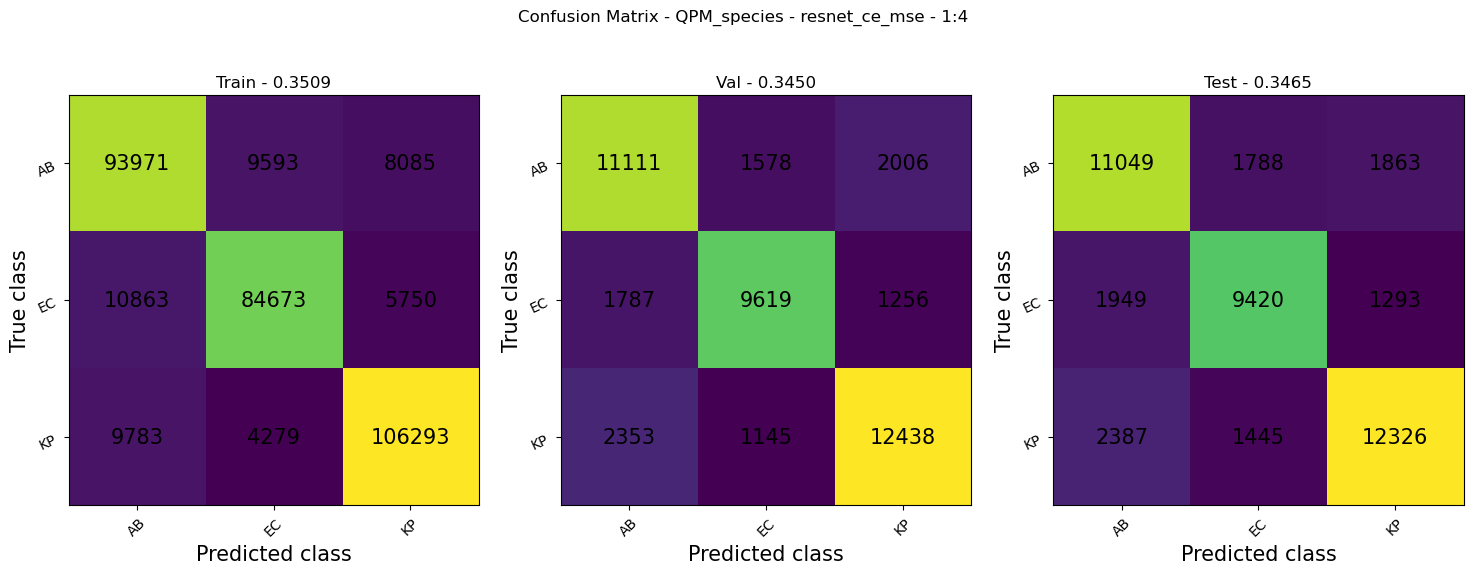

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(43520, 2) (5270, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(43520, 2) (5270, 2)


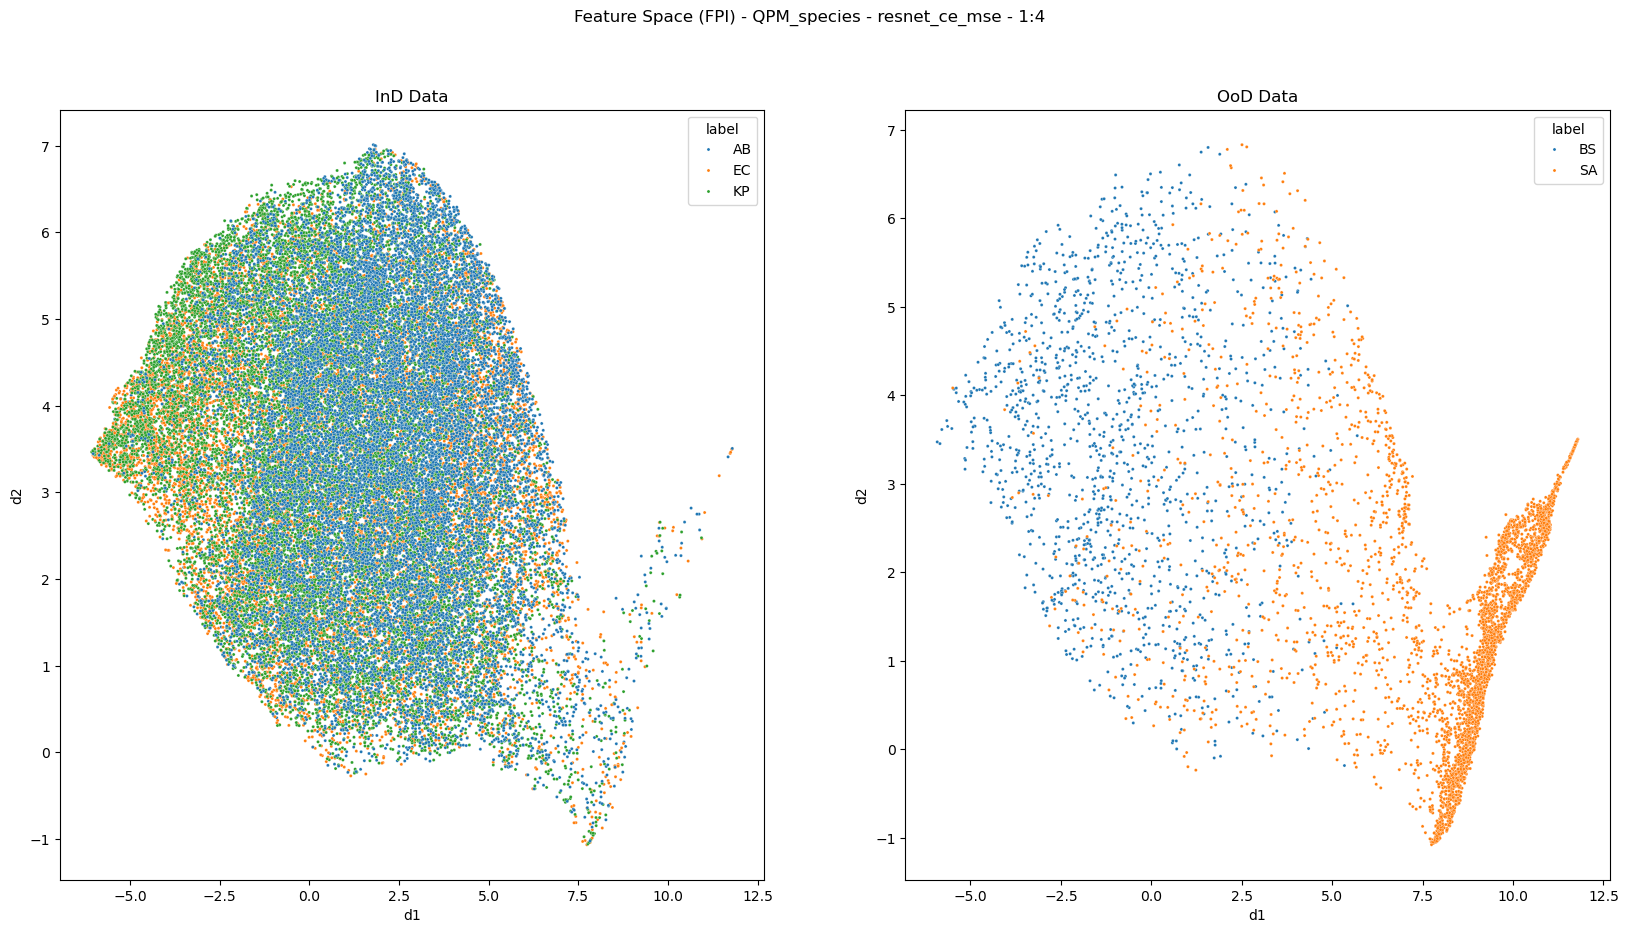

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

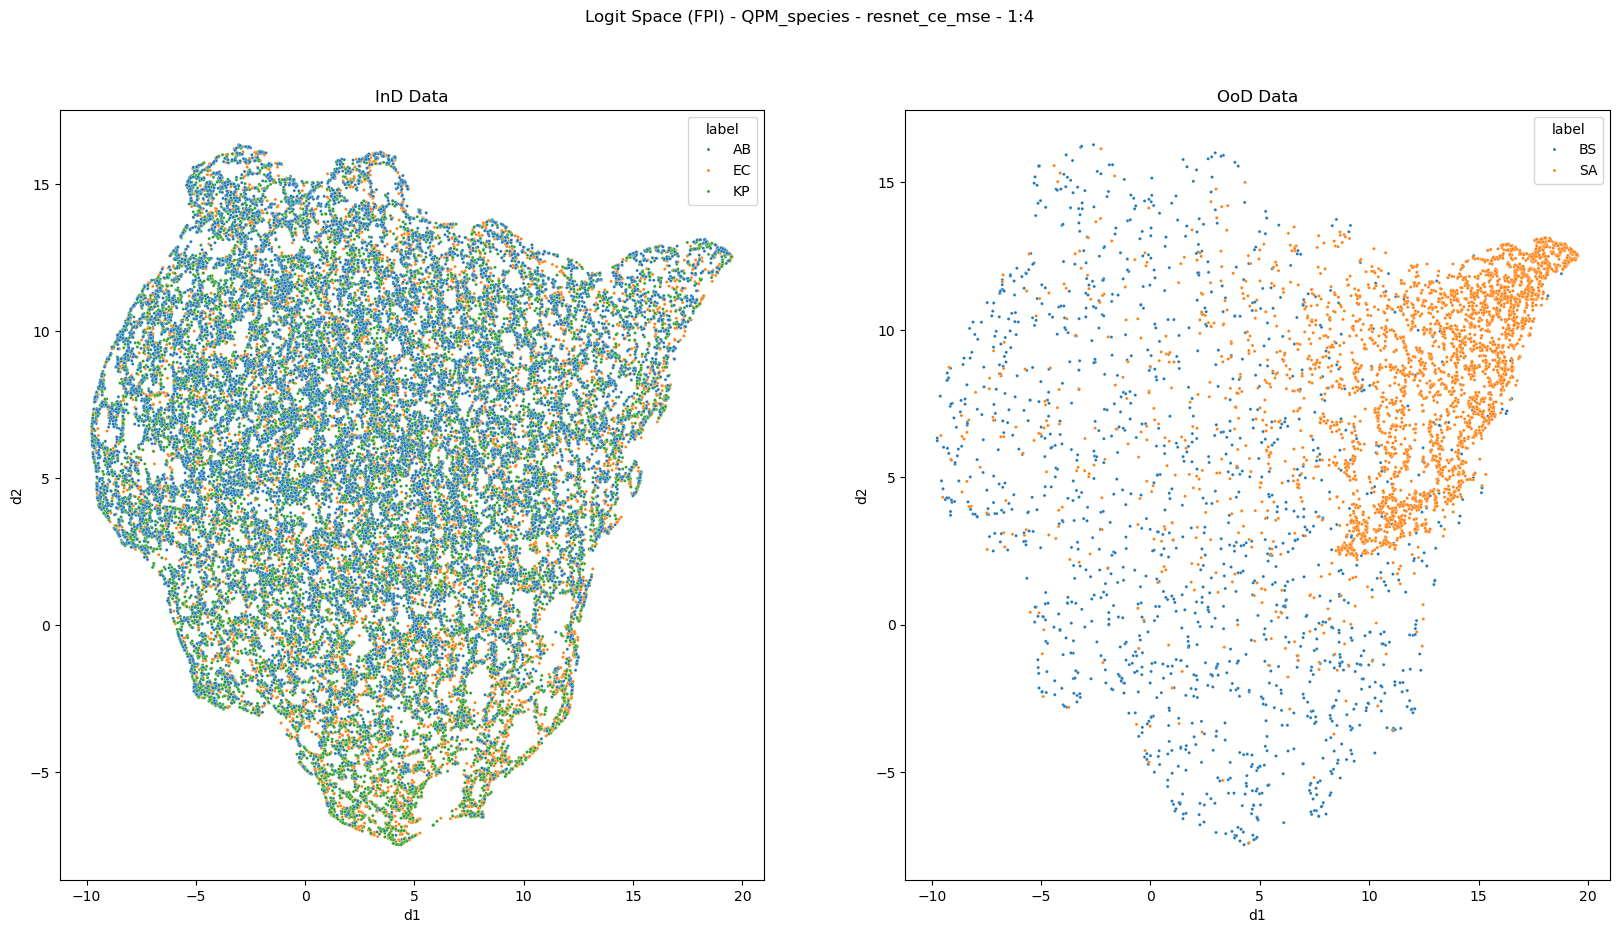

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

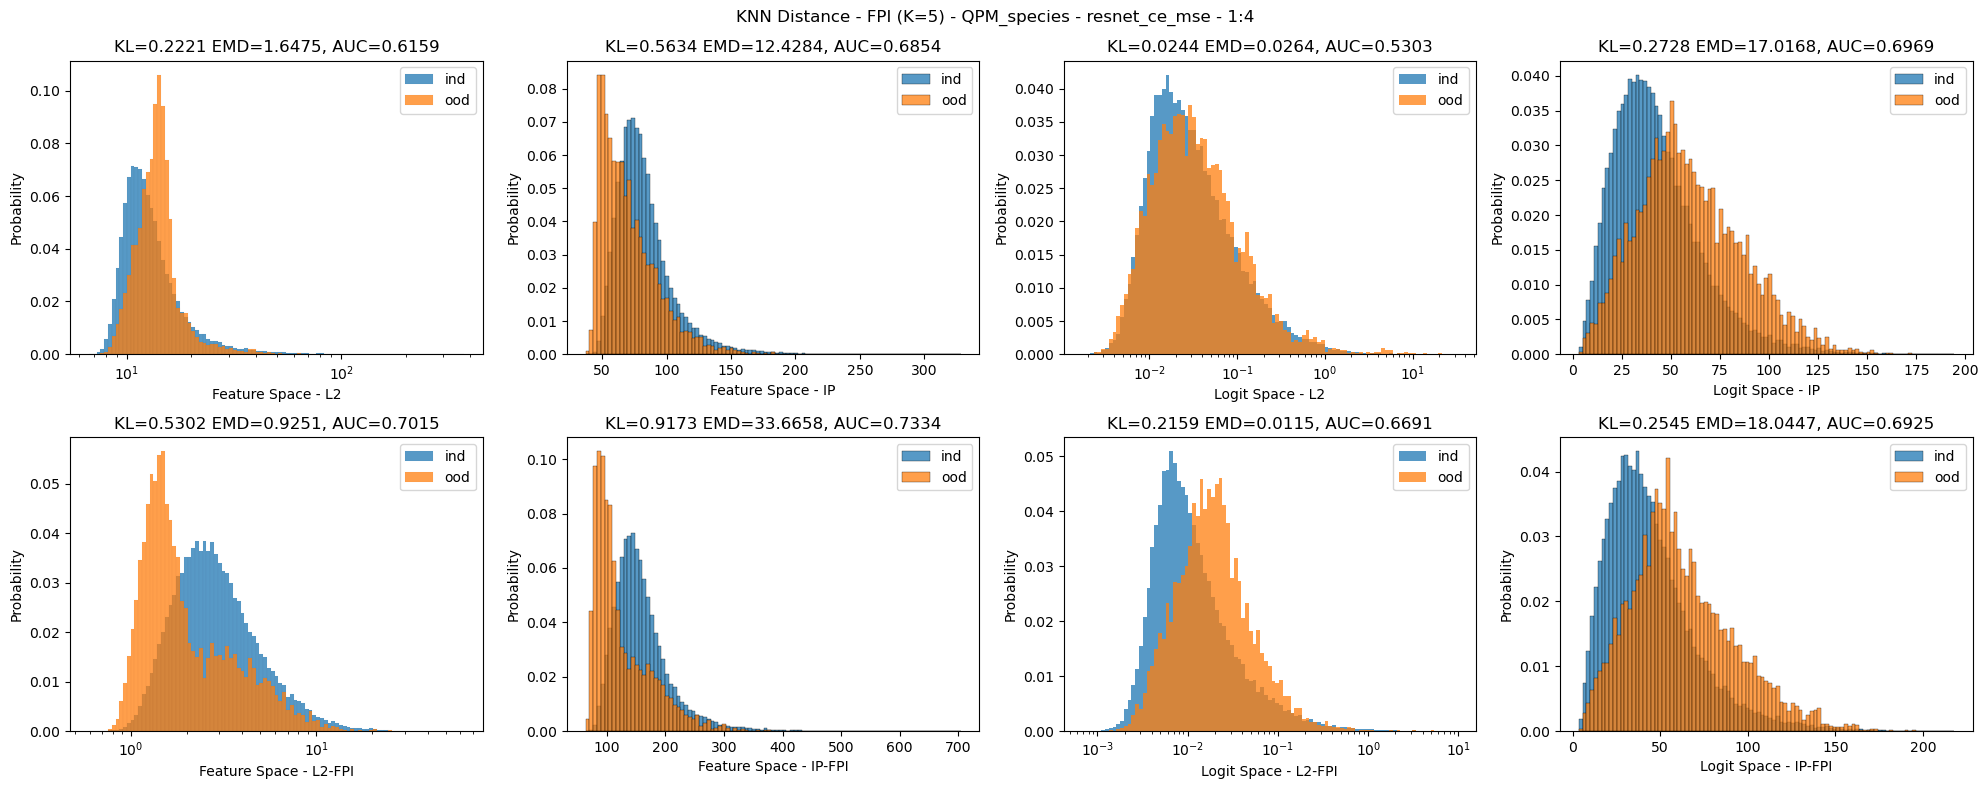

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

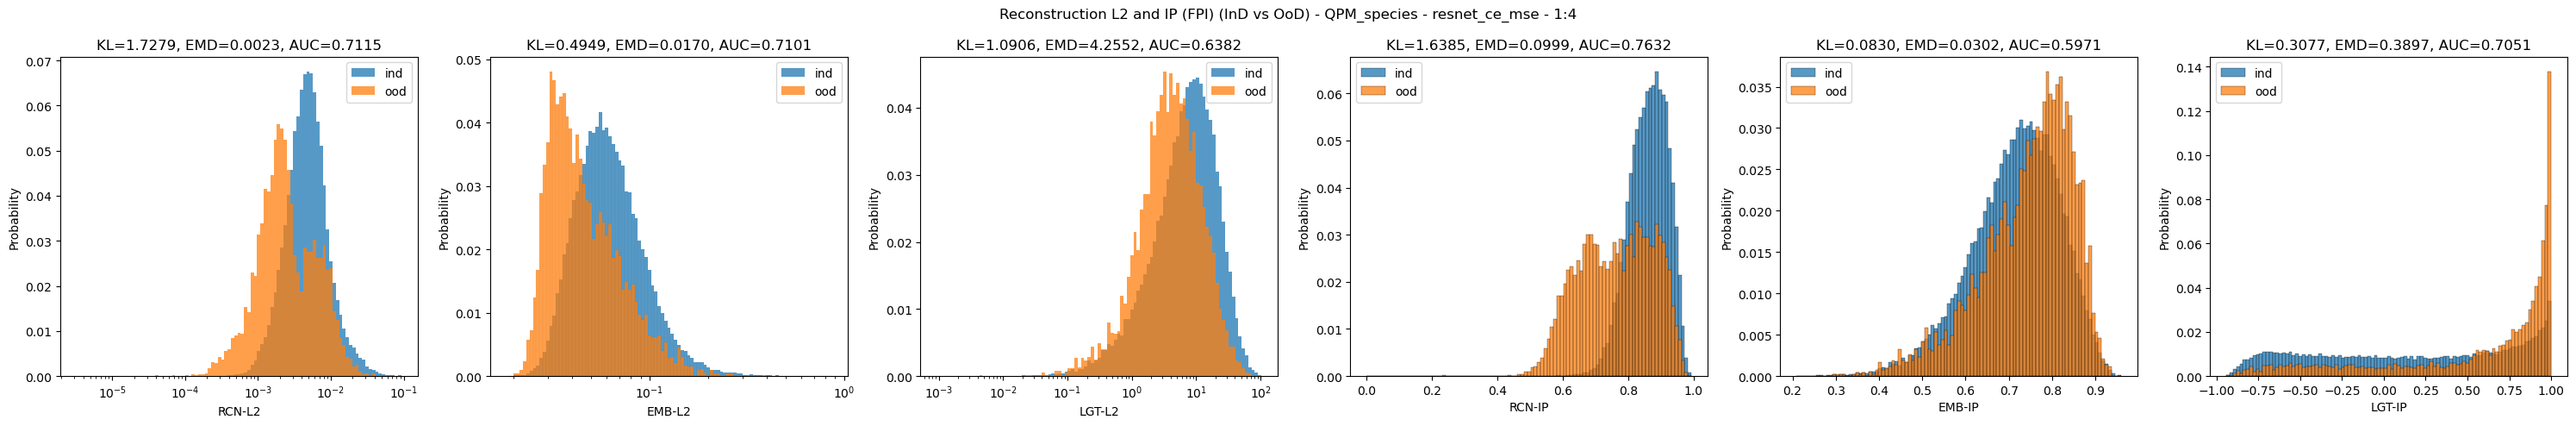

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

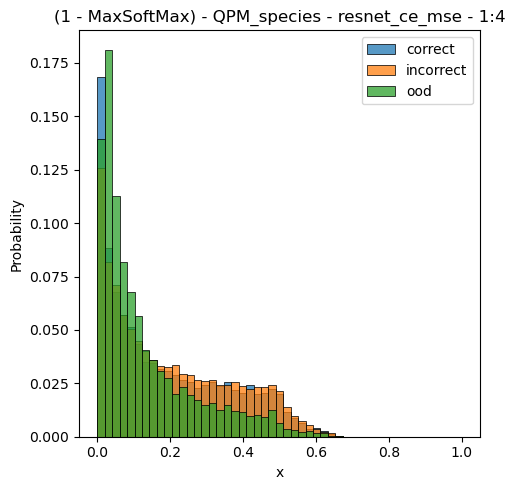

In [17]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()